In [1]:
%load_ext autoreload
%autoreload 2

import sys
print(sys.executable)

from pathlib import Path
import random
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x))
import tensorflow as tf
import pandas as pd
from utils import *
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import imdb
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import Flatten, Dense, Embedding, RNN, GRU, Bidirectional, Layer, Dropout
from tensorflow import keras

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(f"tensorflow version: {tf.__version__}")
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("tf running on gpu")
else:
    print("tf running on cpu")

/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/bin/python
tensorflow version: 2.1.0
tf running on gpu


found yoochoose cache
max_embedding_key: 52738
max_session_len: 262


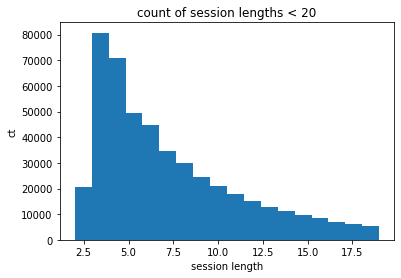

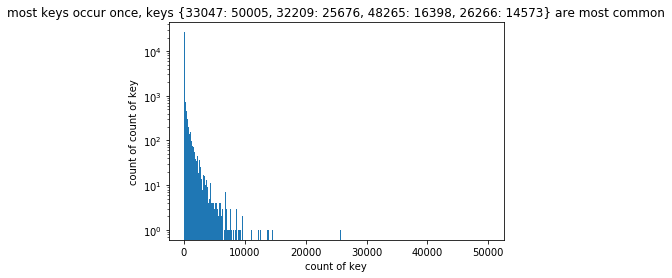

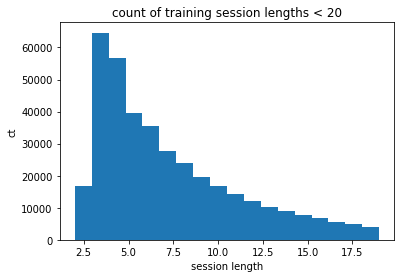

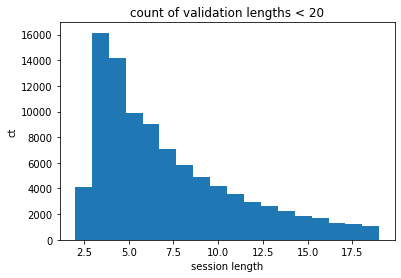

509696 examples
split into 407756 train, 101940 val, 0 test
[[3647, 3647], [2329, 2329, 1047, 2329], [56, 56, 56], [250, 250, 6884], [136, 36427, 36428, 36420, 7608, 7608, 288, 535], [46353, 46353, 12899, 11676], [46967, 46932, 46944, 45814, 22101, 12139, 46937, 47482, 47531, 46944, 47482, 47531], [4788, 248, 248, 248], [121, 43182, 121, 43182, 43182, 43182], [802, 28344, 802, 28344], [45316, 201, 419, 45299, 201], [4514, 1137, 818, 3513, 3319, 3513, 3513, 3513], [5765, 49304, 49304, 3447, 49304, 49304], [30744, 30740, 30740], [9760, 8779, 8779, 5862, 9760, 5862, 5862, 8779], [37900, 37870, 37900, 37882, 36718, 37870, 37900], [44606, 44618, 44606, 44618], [32209, 32209, 39239, 1075, 1075, 30930, 39287, 39296, 3034, 30930, 39296, 32209, 1075, 3034], [45224, 916, 63, 45224, 916, 63], [4956, 1192, 1189, 4956, 6884, 1189, 1189, 1189], [296, 2924, 296, 296, 296, 296], [3734, 492, 3734, 3735, 3734, 3734, 3735, 3735, 3734, 3735, 7410, 6795], [18752, 46296, 46299, 18752, 46296, 46299], [42450,

In [2]:
dataset, column_names, keymap = load_yoochoose_dataset(reinitialize=False)
num_sessions = len(dataset)

max_embedding_key = len(keymap)-1
max_session_len = max([len(i) for i in dataset])

print(f"max_embedding_key: {max_embedding_key}")
print(f"max_session_len: {max_session_len}")

plt.hist([len(session) for session in dataset if len(session) < 20], bins=18)
plt.xlabel("session length")
plt.ylabel("ct")
plt.title("count of session lengths < 20")
plt.show()

dataset = [[item[0] for item in session] for session in dataset]

key_counts = Counter(more_itertools.flatten(dataset))
key_count_frequencies = list(dict(key_counts).values())
plt.hist(key_count_frequencies, bins=400, log=True)
plt.xlabel("count of key")
plt.ylabel("count of count of key")
most_common = {k: v for k, v in key_counts.most_common(4)}
plt.title(f"most keys occur once, keys {most_common} are most common")
plt.show()

(x_train,), (x_val,), (x_test,) = train_val_test_split(dataset, train_perc=.8, val_perc=.2, test_perc=0)

plt.hist([len(session) for session in x_train if len(session) < 20], bins=18)
plt.xlabel("session length")
plt.ylabel("ct")
plt.title("count of training session lengths < 20")
plt.show()

plt.hist([len(session) for session in x_val if len(session) < 20], bins=18)
plt.xlabel("session length")
plt.ylabel("ct")
plt.title("count of validation lengths < 20")
plt.show()

print(f"{len(dataset)} examples")
print(f"split into {len(x_train)} train, {len(x_val)} val, {len(x_test)} test")

print(x_train[:200])
print(x_val[:200])

In [3]:
"""
model notes:

Embedding layer:
    lower dimensional embedding + dropout

attention:
    given a variable length vector A of fixed length vectors, construct a fixed length vector where each element is the output of a tanh * sigmoid. the sigmoid is a gate on the tanh that determines how important that vector is A. Importance is calculated from sigmoid of the dot product between the vector with the trainable importance vector
    thus, attention is fundamentally a fully connected layer gated with sigmoid based on how similar the input is at that vector to the trainable importance vector.
    attention masking: 
        there is still the problem that the output of attention has to be a fixed length vector. 
        to do this, the goal is to pad the attention vector with zeros
        to do this, pad the output of u_{it}^T u_w with -infs so that the output of the softmax would be 0 and that these values won't affect the final ah

clustering:
    a softmax function with a stronger max
    take the inputs to clustering, pass them through a fully connected with the size of the output being the number of clusters, and hard softmax it. the hard softmax values will be the cluster that the vector belongs in. 

final attention layer on the clusters:
    do a softmax on the cluster embedding dot a importance vector and a softmax on the embedding dot the same importance vector. use those softmaxes to compute a weighted sum of the cluster embedding with the importance vector.

loss: 
    nce loss
"""
""

''

In [7]:
class LocalAttention(tf.keras.layers.Layer):
    def __init__(self, max_session_len, embedding_size):
        super(LocalAttention, self).__init__()

        print("max_session_len", max_session_len, "embedding_size", embedding_size)
        self.max_session_len = max_session_len
        self.embedding_size = embedding_size
    
    # def build(self, input_shape):
        self.tanh_layer = Dense(
            self.embedding_size,
            activation='tanh',
            kernel_initializer='glorot_uniform',
            name="tanh_layer")
            # hidden layer = tanh(Wx + b)
            # hidden layer dim: [num_outputs, max_session_len, embedding_size]
        
        u_shape = [self.embedding_size]
        self.u = self.add_weight("importance", shape=u_shape)

    def call(self, values):
        batch_size, cur_session_len, item_shape = values.shape[0],values.shape[1],values.shape[2:]

        item_dims = len(item_shape)
        # print("values", values)
        # values shape = [batch_size, cur_sess_len]+item_shape

        tanh_layer = self.tanh_layer(values)
        # print("tanh_layer", tanh_layer)
        # tanh shape = [batch_size, cur_sess_len, embedding_size]

        similarity_vector = tf.tensordot(tanh_layer, self.u, axes=([2], [0]))
        # similarity_vector shape = [batch_size, cur_sess_len]
        # print("similarity_vector", similarity_vector)

        # padding out the similarity_vector with -infinity values
        # padded_sim = tf.fill(dims=[self.max_session_len], value=-np.inf)
        # this_session_len = values.shape[0]
        # padded_sim[:this_session_len] = similarity_vector
        # padded_sim shape = max_session_len

        weights = tf.nn.softmax(similarity_vector, axis=1)
        # weights shape = [batch_size, cur_session_len]
        # print("weights", weights)

        values_transpose_axes = [i+2 for i in range(item_dims)]+[0, 1]
        inv_values_transpose_axes = [item_dims, item_dims+1]+[i for i in range(item_dims)]
        weighted_inputs = tf.transpose(
            tf.transpose(values, perm=values_transpose_axes)*weights,
            perm=inv_values_transpose_axes
        )
        # weighted_inputs shape = [batch_size, cur_session_len]+item_shape
        # print("weighted_inputs", weighted_inputs)

        output = tf.math.reduce_sum(weighted_inputs, axis=1)
        # outputs shape = [batch_size, item_shape]
        # print("output", output)

        # output_pad_shape = [batch_size, self.max_session_len-cur_session_len]+item_shape
        # print("output_pad_shape", output_pad_shape)
        # output_pad = tf.zeros(output_pad_shape, dtype=tf.float32)

        # padded_output = tf.concat((output, output_pad), axis=2)

        # attention_weights shape == (batch_size, max_length, 1)
        # attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        # context_vector = attention_weights * values
        # context_vector = tf.reduce_sum(context_vector, axis=1)
        return output

class TestModel(Model):
    def __init__(self, max_embedding_key, max_session_len, embedding_size, gru_size, dense2_size, dense3_size):
        super(TestModel, self).__init__()
        self.word_embedding_mtx = tf.Variable(tf.random.uniform([max_embedding_key, embedding_size], -1, 1, dtype=tf.float32))
        self.rnn = Bidirectional(GRU(gru_size, return_sequences=True), merge_mode="concat")
        self.attention1 = LocalAttention(max_session_len, gru_size)
        self.dense2 = Dense(
            dense2_size, 
            activation="linear", 
            kernel_initializer='he_normal')
        self.dense3 = Dense(
            dense3_size, 
            activation="linear", 
            kernel_initializer='he_normal')
        self.sigmoid_layer = Dense(
            max_embedding_key, 
            activation="softmax", 
            name="softmax_dense")

#         self.nce_weights = tf.Variable(tf.random.truncated_normal([max_embedding_key, dense2_size],
#                                                     stddev=1.0 / (dense2_size ** 0.5)))
#         self.nce_bias = tf.Variable(tf.zeros([max_embedding_key]))

    def call(self, x, training=False):
        
        word_embeddings = tf.nn.embedding_lookup(self.word_embedding_mtx, x)
        rnn_output = self.rnn(word_embeddings)
        
        if training:
            attention_output = Dropout(.5)(self.attention1(rnn_output))
            dense2 = Dropout(.5)(tf.keras.layers.LeakyReLU()(self.dense2(attention_output)))
            dense3 = Dropout(.5)(tf.keras.layers.LeakyReLU()(self.dense3(dense2)))
#             return tf.reduce_mean(tf.nn.nce_loss(
        else:
            attention_output = self.attention1(rnn_output)
            dense2 = tf.keras.layers.LeakyReLU()(self.dense2(attention_output))
            dense3 = tf.keras.layers.LeakyReLU()(self.dense3(dense2))

        return self.sigmoid_layer(dense3)
        
    def get_loss(self, y_true, logits):
#         print(y_true.shape, y_pred.shape)
        ce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)(y_true, logits)
        return ce_loss

#         return tf.nn.nce_loss(weights, biases, labels, inputs, num)

In [8]:
from tqdm import tqdm

train_batch_size = 1024
val_batch_size = 256 # train vs val batch size must be different as same batch size = 
print("train_batch_size", train_batch_size)
print("val_batch_size", val_batch_size)

# splitting up long sessions by sampling them. a long session length is one without batch_size examples.
x_train = sample_long_sessions(x_train, train_batch_size)
x_val = sample_long_sessions(x_val, val_batch_size)

# model.fit(x_train_p, y_train_p, batch_size=batch_size, epochs=4, validation_data=[x_val, y_val])

# row_id_to_idx = {k: v for v, k in enumerate(set(clicks_df["sessionId"])|set(buys_df["sessionId"]))}
# col_id_to_idx = {k: v for v, k in enumerate(set(clicks_df["itemId"])|set(buys_df["itemId"]))}

# matrix_shape = (len(row_id_to_idx), len(col_id_to_idx))

# row_indices = [row_id_to_idx[row_id] for row_id in clicks_df["sessionId"]]
# col_indices = [col_id_to_idx[col_id] for col_id in clicks_df["itemId"]]
# elements = np.ones(len(col_indices), dtype=np.int8)
# viewed_matrix = csr_matrix((elements, (row_indices, col_indices)), shape=matrix_shape)

# row_indices = [row_id_to_idx[row_id] for row_id in buys_df["sessionId"]]
# col_indices = [col_id_to_idx[col_id] for col_id in buys_df["itemId"]]
# elements = np.ones(len(col_indices), dtype=np.int8)
# buys_matrix = csr_matrix((elements, (row_indices, col_indices)), shape=matrix_shape)

# interaction_matrix = 2*buys_matrix-viewed_matrix
model = TestModel(
    max_embedding_key=max_embedding_key, 
    max_session_len=max_session_len, 
    embedding_size=64,
    gru_size=128,
    dense2_size=512,
    dense3_size=256
)

class VectorizableNotDumbSparseTopKCategoricalAccuracy(Metric):
    """
    the tensorflow one doesn't work with ties
    this took 3 hours to write
    """
    def __init__(self, k):
        super(VectorizableNotDumbSparseTopKCategoricalAccuracy, self).__init__()
        self.k = k
        self.acc_num = self.add_weight("acc_num", shape=[1], dtype=tf.int32)
        self.acc_denom = self.add_weight("acc_num", shape=[1], dtype=tf.int32)
    
    def update_state(self, true_ys, logits):
        pred_labels = tf.math.top_k(logits, k=self.k)[1]
        true_label = tf.cast(tf.expand_dims(true_ys, axis=1), tf.int32)

        num_correct = tf.math.reduce_sum(tf.cast(pred_labels==true_label, tf.int32), axis=1)
        vectorized_in_op = tf.cast(num_correct > 0, tf.int32)

        self.acc_num += tf.reduce_sum(vectorized_in_op)
        self.acc_denom += len(true_ys)

    def reset_states(self):
        tf.keras.backend.set_value(
            self.acc_num, np.zeros()
        )
        self.acc_num = 0
        self.acc_denom = 0
    
    def result(self):
        return tf.math.divide_no_nan(self.acc_num, self.acc_denom)


loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=.001)

# train_loss = tf.keras.metrics.SparseCategoricalCrossentropy(name='train_loss')
train_accs = [
    tf.keras.metrics.SparseCategoricalAccuracy(),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=50),
#     VectorizableNotDumbSparseTopKCategoricalAccuracy(k=5),
#     VectorizableNotDumbSparseTopKCategoricalAccuracy(k=10),
#     VectorizableNotDumbSparseTopKCategoricalAccuracy(k=50)
]

# test_loss = tf.keras.metrics.SparseCategoricalCrossentropy(name='test_loss')
test_accs = [
    tf.keras.metrics.SparseCategoricalAccuracy(),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=50),
#     VectorizableNotDumbSparseTopKCategoricalAccuracy(k=5),
#     VectorizableNotDumbSparseTopKCategoricalAccuracy(k=10),
#     VectorizableNotDumbSparseTopKCategoricalAccuracy(k=50)
]

@tf.function
def train_step(sessions, labels):
    with tf.GradientTape() as tape:
        predictions = model(sessions, training=True)
        loss = model.get_loss(y_true=labels, logits=predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
#     print("median gradients", [(layer.name, np.median(grad.numpy())) for grad, layer in zip(gradients, model.trainable_variables)])
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # train_loss(loss)
    for train_acc in train_accs:
        train_acc.update_state(labels, predictions)

    return predictions

@tf.function
def test_step(sessions, labels):
    predictions = model(sessions, training=False)
#     t_loss = loss_object(labels, predictions)

    # test_loss(t_loss)
    for test_acc in test_accs:
        test_acc.update_state(labels, predictions)

EPOCHS = 100
num_x = len(x_train)

for epoch in range(EPOCHS):
    print(f"epoch {epoch}/{EPOCHS}")
    # Reset the metrics at the start of the next epoch
    for train_acc in train_accs:
        train_acc.reset_states()
    for test_acc in test_accs:
        test_acc.reset_states()

    for i, batch_sess in enumerate(batchify_bin_by_sess_len(x_train, batch_size=train_batch_size)):
        batch_labels = batch_sess[:, -1]
        batch_sess = batch_sess[:, :-1]
#         print("cur sess len", batch_sess[0].shape)
#         for i in range(400):
        predictions = train_step(tf.constant(batch_sess), tf.constant(batch_labels))
        # print(model.variables)
#             tf.print(f"batch {i}/~{int(num_x/batch_size)} train acc: {top1_train_acc.result()} top10acc: {top10_train_acc.result()} session length: {len(batch_sess[0])}")

#                 print("labels", batch_labels)
#                 print("preds", tf.argmax(predictions, axis=1).numpy())
#             counted_preds = Counter(tf.argmax(predictions, axis=1).numpy())
#             if len(counted_preds) == 1:
#                 print(f"MODEL ONLY PREDICTING {list(counted_preds)[0]}")
#             else:
#                 print(f"predictions: {counted_preds}")
#             top1_train_acc.reset_states()
#             top10_train_acc.reset_states()
#         sys.exit()

    for i, batch_sess in enumerate(batchify_bin_by_sess_len(x_val, batch_size=val_batch_size)):
        # batch_sess, batch_labels = augment_negative_examples(batch_sess, max_embedding_key)
        batch_labels = batch_sess[:, -1]
        batch_sess = batch_sess[:, :-1]
        test_step(tf.constant(batch_sess), tf.constant(batch_labels))

    print(f"Epoch {epoch+1}")
    print(f"train acc: {train_accs[0].result()} top5 train {train_accs[1].result()} top10 train {train_accs[2].result()} top50 train {train_accs[3].result()}")
    print(f"test acc: {test_accs[0].result()} top5 test {test_accs[1].result()} top10 test {test_accs[2].result()} top50 test {test_accs[3].result()}")


100%|██████████| 27/27 [00:00<00:00, 1651.13it/s]

train_batch_size 1024
val_batch_size 256
sampling from long sessions...
didn't find any long sessions
sampling from long sessions...


didn't find any long sessions
max_session_len 262 embedding_size 128
epoch 0/100
Epoch 1
train acc: 0.024373477324843407 top5 train 0.03748224303126335 top10 train 0.046443790197372437 top50 train 0.0945870503783226
test acc: 0.03902202099561691 top5 test 0.04904064163565636 top10 test 0.061315979808568954 top50 test 0.13665802776813507
epoch 1/100
Epoch 2
train acc: 0.05667106434702873 top5 train 0.06261921674013138 top10 train 0.07063210010528564 top50 train 0.14465300738811493
test acc: 0.06824805587530136 top5 test 0.07107148319482803 top10 test 0.07693085819482803 top50 test 0.148063063621521
epoch 2/100
Epoch 3
train acc: 0.07374441623687744 top5 train 0.07732345908880234 top10 train 0.08107751607894897 top50 train 0.1559177190065384
test acc: 0.07397587597370148 top5 test 0.07778092473745346 top10 test 0.08019956201314926 top50 test 0.16008540987968445
epoch 3/100
Epoch 4
train acc: 0.07755427807569504 top5 train 0.08050680160522461 top10 train 0.08405286073684692 top50 train 0.

Epoch 30
train acc: 0.08615057170391083 top5 train 0.2894607484340668 top10 train 0.4762023091316223 top50 train 0.857530951499939
test acc: 0.08451060205698013 top5 test 0.2513459324836731 top10 test 0.3987613320350647 top50 test 0.823176383972168
epoch 30/100
Epoch 31
train acc: 0.08642704784870148 top5 train 0.2963118851184845 top10 train 0.49428266286849976 top50 train 0.8663098812103271
test acc: 0.08456120640039444 top5 test 0.25643619894981384 top10 test 0.40269795060157776 top50 test 0.8135524392127991
epoch 31/100
Epoch 32
train acc: 0.08625710010528564 top5 train 0.28109273314476013 top10 train 0.4725852310657501 top50 train 0.8543958067893982
test acc: 0.08452072739601135 top5 test 0.28723081946372986 top10 test 0.4619596004486084 top50 test 0.8472514748573303
epoch 32/100
Epoch 33
train acc: 0.0864473432302475 top5 train 0.3155412971973419 top10 train 0.5218445658683777 top50 train 0.8742567896842957
test acc: 0.08433856815099716 top5 test 0.2828691601753235 top10 test 0.46

Epoch 62
train acc: 0.08642704784870148 top5 train 0.6431412100791931 top10 train 0.8907086849212646 top50 train 0.9931919574737549
test acc: 0.08420701324939728 top5 test 0.6506638526916504 top10 test 0.8862431049346924 top50 test 0.994970440864563
epoch 62/100
Epoch 63
train acc: 0.08619368821382523 top5 train 0.6761997938156128 top10 train 0.9069424867630005 top50 train 0.9952567219734192
test acc: 0.0842171311378479 top5 test 0.6753460764884949 top10 test 0.8937925100326538 top50 test 0.9953954815864563
epoch 63/100
Epoch 64
train acc: 0.08627232164144516 top5 train 0.7207589149475098 top10 train 0.9246677160263062 top50 train 0.9967278838157654
test acc: 0.08433856815099716 top5 test 0.7242146730422974 top10 test 0.9250222444534302 top50 test 0.9982290267944336
epoch 64/100
Epoch 65
train acc: 0.08624695986509323 top5 train 0.7396661639213562 top10 train 0.9392045736312866 top50 train 0.9980595707893372
test acc: 0.08449036628007889 top5 test 0.7079724073410034 top10 test 0.930952

Epoch 94
train acc: 0.08703581243753433 top5 train 0.8551313877105713 top10 train 0.9869977831840515 top50 train 0.999954342842102
test acc: 0.08521899580955505 top5 test 0.8466644883155823 top10 test 0.9856399893760681 top50 test 0.9999898672103882
epoch 94/100
Epoch 95
train acc: 0.0866781622171402 top5 train 0.8601486682891846 top10 train 0.9874594211578369 top50 train 0.9999340772628784
test acc: 0.08474335819482803 top5 test 0.8520280122756958 top10 test 0.9875222444534302 top50 test 0.9999696612358093
epoch 95/100
Epoch 96
train acc: 0.08666802197694778 top5 train 0.8770850300788879 top10 train 0.9904043078422546 top50 train 0.999959409236908
test acc: 0.08476360142230988 top5 test 0.8854740262031555 top10 test 0.9908820390701294 top50 test 0.9999898672103882
epoch 96/100
Epoch 97
train acc: 0.08681514114141464 top5 train 0.8901024460792542 top10 train 0.9916218519210815 top50 train 0.9999695420265198
test acc: 0.08504695445299149 top5 test 0.8858281970024109 top10 test 0.9902647

In [14]:
num = 0
denom = 0
for i, sess in tqdm(enumerate(x_train)):
    y = sess[-1]
    x = sess[:-1]
    pred = model.call([x])
    pred = pred.numpy()[0]
    if y in np.arange(max_embedding_key)[pred != 0]:
        num += 1
    denom += 1
    if i % 100 == 1:
        print(num/denom)
#     print(len(pred[0]))
#     print(sum(pred[0].numpy()==0))
    
#     print(sum(pred[0] * (pred[0] != 0)))
#     print(y, np.argpartition(pred[0], -1)[:-1])



0it [00:00, ?it/s]

11it [00:00, 101.08it/s]

22it [00:00, 101.57it/s]

0.0




32it [00:00, 100.50it/s]

43it [00:00, 100.75it/s]

54it [00:00, 101.32it/s]

65it [00:00, 101.87it/s]

76it [00:00, 102.13it/s]

87it [00:00, 102.41it/s]

97it [00:00, 101.27it/s]

108it [00:01, 101.12it/s]

119it [00:01, 101.24it/s]

0.13725490196078433




130it [00:01, 101.61it/s]

141it [00:01, 101.94it/s]

152it [00:01, 102.12it/s]

163it [00:01, 99.88it/s] 

174it [00:01, 100.58it/s]

185it [00:01, 100.95it/s]

196it [00:01, 100.66it/s]

207it [00:02, 100.98it/s]

218it [00:02, 99.06it/s] 

0.15346534653465346




229it [00:02, 99.59it/s]

240it [00:02, 100.26it/s]

251it [00:02, 100.50it/s]

262it [00:02, 100.94it/s]

273it [00:02, 98.74it/s] 

283it [00:02, 98.85it/s]

294it [00:02, 99.73it/s]

305it [00:03, 100.39it/s]

316it [00:03, 100.46it/s]

0.17880794701986755




327it [00:03, 100.67it/s]

338it [00:03, 99.91it/s] 

349it [00:03, 100.27it/s]

360it [00:03, 100.87it/s]

371it [00:03, 101.10it/s]

382it [00:03, 100.45it/s]

393it [00:03, 100.59it/s]

404it [00:04, 100.33it/s]

415it [00:04, 100.64it/s]

0.17164179104477612




426it [00:04, 100.54it/s]

437it [00:04, 100.96it/s]

448it [00:04, 101.54it/s]

459it [00:04, 100.60it/s]

470it [00:04, 101.14it/s]

481it [00:04, 101.52it/s]

492it [00:04, 101.47it/s]
2731it [00:46, 101.23it/s]

503it [00:04, 101.31it/s]

514it [00:05, 101.13it/s]

0.17330677290836655




525it [00:05, 99.93it/s] 

536it [00:05, 100.27it/s]

547it [00:05, 100.68it/s]

558it [00:05, 101.17it/s]

569it [00:05, 101.66it/s]

580it [00:05, 100.33it/s]

591it [00:05, 100.40it/s]

602it [00:05, 100.83it/s]

613it [00:06, 101.00it/s]

0.1777408637873754




624it [00:06, 100.91it/s]

635it [00:06, 100.95it/s]

646it [00:06, 100.17it/s]

657it [00:06, 100.89it/s]

668it [00:06, 101.39it/s]

679it [00:06, 101.73it/s]

690it [00:06, 101.81it/s]

701it [00:06, 100.23it/s]

712it [00:07, 100.59it/s]

0.17236467236467237




723it [00:07, 100.06it/s]

734it [00:07, 100.62it/s]

745it [00:07, 99.57it/s] 

756it [00:07, 99.64it/s]

767it [00:07, 99.95it/s]

778it [00:07, 100.53it/s]

789it [00:07, 101.01it/s]

800it [00:07, 101.14it/s]

811it [00:08, 101.29it/s]

0.17830423940149626




822it [00:08, 99.41it/s] 

833it [00:08, 100.17it/s]

844it [00:08, 100.79it/s]

855it [00:08, 101.36it/s]

866it [00:08, 101.44it/s]

877it [00:08, 101.46it/s]

888it [00:08, 101.49it/s]

899it [00:08, 102.00it/s]

910it [00:09, 102.27it/s]

921it [00:09, 101.41it/s]

0.18736141906873613




932it [00:09, 101.55it/s]

943it [00:09, 100.09it/s]

954it [00:09, 100.23it/s]

965it [00:09, 100.99it/s]

976it [00:09, 101.56it/s]

987it [00:09, 101.94it/s]

998it [00:09, 102.24it/s]

1009it [00:10, 101.50it/s]

1020it [00:10, 101.22it/s]

0.18662674650698602




1031it [00:10, 101.03it/s]

1042it [00:10, 101.22it/s]

1053it [00:10, 101.48it/s]

1064it [00:10, 100.73it/s]

1075it [00:10, 101.00it/s]

1086it [00:10, 101.35it/s]

1097it [00:10, 101.53it/s]

1108it [00:10, 101.68it/s]

1119it [00:11, 101.67it/s]

0.18784029038112524




1130it [00:11, 100.42it/s]

1141it [00:11, 100.33it/s]

1152it [00:11, 101.06it/s]

1163it [00:11, 101.47it/s]

1174it [00:11, 101.91it/s]

1185it [00:11, 100.85it/s]

1196it [00:11, 101.11it/s]

1207it [00:11, 101.38it/s]

1218it [00:12, 100.83it/s]

0.18469217970049917




1229it [00:12, 100.27it/s]

1240it [00:12, 101.05it/s]

1251it [00:12, 100.12it/s]

1262it [00:12, 100.56it/s]

1273it [00:12, 101.20it/s]

1284it [00:12, 101.62it/s]

1295it [00:12, 101.88it/s]

1306it [00:12, 100.41it/s]

1317it [00:13, 100.81it/s]

0.18740399385560677




1328it [00:13, 100.63it/s]

1339it [00:13, 101.29it/s]

1350it [00:13, 101.31it/s]

1361it [00:13, 101.60it/s]

1372it [00:13, 100.84it/s]

1383it [00:13, 100.48it/s]

1394it [00:13, 100.87it/s]

1405it [00:13, 101.21it/s]

1416it [00:14, 101.33it/s]

0.1875891583452211




1427it [00:14, 99.95it/s] 

1438it [00:14, 100.56it/s]

1449it [00:14, 100.80it/s]

1460it [00:14, 101.23it/s]

1471it [00:14, 101.13it/s]

1482it [00:14, 101.70it/s]

1493it [00:14, 100.82it/s]

1504it [00:14, 100.00it/s]

1515it [00:15, 100.34it/s]

0.18242343541944075




1526it [00:15, 100.38it/s]

1537it [00:15, 100.09it/s]

1548it [00:15, 99.15it/s] 

1559it [00:15, 99.90it/s]

1570it [00:15, 100.56it/s]

1581it [00:15, 100.37it/s]

1592it [00:15, 100.34it/s]

1603it [00:15, 100.81it/s]

1614it [00:16, 99.93it/s] 

0.18476903870162298




1624it [00:16, 99.82it/s]

1634it [00:16, 99.66it/s]

1645it [00:16, 100.44it/s]

1656it [00:16, 100.83it/s]

1667it [00:16, 99.96it/s] 

1677it [00:16, 99.82it/s]

1688it [00:16, 100.49it/s]

1699it [00:16, 100.76it/s]

1710it [00:16, 100.77it/s]

1721it [00:17, 101.07it/s]

0.1862514688601645




1732it [00:17, 99.44it/s] 

1742it [00:17, 99.18it/s]

1753it [00:17, 99.99it/s]

1764it [00:17, 100.55it/s]

1775it [00:17, 100.95it/s]

1786it [00:17, 100.19it/s]

1797it [00:17, 100.53it/s]

1808it [00:17, 101.23it/s]

1819it [00:18, 101.50it/s]

0.1825749167591565




1830it [00:18, 100.93it/s]

1841it [00:18, 100.00it/s]

1852it [00:18, 99.55it/s] 

1863it [00:18, 100.03it/s]

1874it [00:18, 100.90it/s]

1885it [00:18, 101.11it/s]

1896it [00:18, 101.23it/s]

1907it [00:18, 100.24it/s]

1918it [00:19, 100.53it/s]

0.17981072555205047




1929it [00:19, 99.42it/s] 

1940it [00:19, 99.78it/s]

1951it [00:19, 100.26it/s]

1962it [00:19, 100.71it/s]

1973it [00:19, 99.83it/s] 

1984it [00:19, 100.30it/s]

1995it [00:19, 100.41it/s]

2006it [00:19, 100.82it/s]

2017it [00:20, 101.32it/s]

0.18031968031968032




2028it [00:20, 100.14it/s]

2039it [00:20, 100.41it/s]

2050it [00:20, 100.87it/s]

2061it [00:20, 101.04it/s]

2072it [00:20, 101.35it/s]

2083it [00:20, 101.59it/s]

2094it [00:20, 100.39it/s]

2105it [00:20, 100.76it/s]

2116it [00:20, 101.27it/s]

0.18315889628924834




2127it [00:21, 100.65it/s]

2138it [00:21, 101.00it/s]

2149it [00:21, 100.24it/s]

2160it [00:21, 100.48it/s]

2171it [00:21, 100.62it/s]

2182it [00:21, 101.12it/s]

2193it [00:21, 101.45it/s]

2204it [00:21, 101.07it/s]

2215it [00:21, 100.21it/s]

0.18346957311534967




2226it [00:22, 99.41it/s] 

2237it [00:22, 99.96it/s]

2248it [00:22, 100.50it/s]

2259it [00:22, 100.44it/s]

2270it [00:22, 99.76it/s] 

2280it [00:22, 99.75it/s]

2291it [00:22, 100.14it/s]

2302it [00:22, 100.48it/s]

2313it [00:22, 100.96it/s]

0.1841876629018245




2324it [00:23, 100.91it/s]

2335it [00:23, 99.87it/s] 

2346it [00:23, 100.56it/s]

2357it [00:23, 100.84it/s]

2368it [00:23, 101.25it/s]

2379it [00:23, 101.44it/s]

2390it [00:23, 100.77it/s]

2401it [00:23, 100.78it/s]

2412it [00:23, 101.32it/s]

0.18734388009991673




2423it [00:24, 101.00it/s]

2434it [00:24, 101.03it/s]

2445it [00:24, 101.65it/s]

2456it [00:24, 100.63it/s]

2467it [00:24, 101.28it/s]

2478it [00:24, 100.78it/s]

2489it [00:24, 100.88it/s]

2500it [00:24, 101.11it/s]

2511it [00:24, 100.72it/s]

2522it [00:25, 101.09it/s]

0.18665067945643485




2533it [00:25, 100.62it/s]

2544it [00:25, 101.31it/s]

2555it [00:25, 101.80it/s]

2566it [00:25, 102.17it/s]

2577it [00:25, 100.76it/s]

2588it [00:25, 101.48it/s]

2599it [00:25, 101.94it/s]

2610it [00:25, 102.16it/s]

2621it [00:26, 101.25it/s]

0.18985395849346656




2632it [00:26, 100.19it/s]

2643it [00:26, 100.36it/s]

2654it [00:26, 100.70it/s]

2665it [00:26, 101.12it/s]

2676it [00:26, 100.66it/s]

2687it [00:26, 100.92it/s]

2698it [00:26, 98.97it/s] 

2709it [00:26, 99.55it/s]

2720it [00:26, 100.27it/s]

0.19022945965951146




2731it [00:27, 99.96it/s] 

2742it [00:27, 100.01it/s]

2753it [00:27, 99.60it/s] 

2764it [00:27, 100.08it/s]

2775it [00:27, 100.70it/s]

2786it [00:27, 101.04it/s]

2797it [00:27, 101.21it/s]

2808it [00:27, 101.34it/s]

2819it [00:27, 100.48it/s]

0.1887937187723055




2830it [00:28, 100.30it/s]

2841it [00:28, 100.69it/s]

2852it [00:28, 100.96it/s]

2863it [00:28, 101.30it/s]

2874it [00:28, 100.13it/s]

2885it [00:28, 100.87it/s]

2896it [00:28, 101.58it/s]

2907it [00:28, 101.72it/s]

2918it [00:28, 102.18it/s]

0.18711233631977947




2929it [00:29, 101.81it/s]

2940it [00:29, 100.23it/s]

2951it [00:29, 101.06it/s]

2962it [00:29, 101.50it/s]

2973it [00:29, 101.61it/s]

2984it [00:29, 101.71it/s]

2995it [00:29, 100.95it/s]

3006it [00:29, 100.62it/s]

3017it [00:29, 101.34it/s]

0.18887408394403732




3028it [00:30, 100.88it/s]

3039it [00:30, 100.84it/s]

3050it [00:30, 101.11it/s]

3061it [00:30, 100.27it/s]

3072it [00:30, 100.79it/s]

3083it [00:30, 101.24it/s]

3094it [00:30, 101.11it/s]

3105it [00:30, 101.19it/s]

3116it [00:30, 100.74it/s]

0.18762088974854932




3127it [00:31, 100.42it/s]

3138it [00:31, 100.45it/s]

3149it [00:31, 100.29it/s]

3160it [00:31, 100.62it/s]

3171it [00:31, 101.08it/s]

3182it [00:31, 100.27it/s]

3193it [00:31, 100.85it/s]

3204it [00:31, 100.76it/s]

3215it [00:31, 101.19it/s]

0.18831980012492192




3226it [00:32, 101.31it/s]

3237it [00:32, 99.91it/s] 

3248it [00:32, 100.37it/s]

3259it [00:32, 100.68it/s]

3270it [00:32, 100.79it/s]

3281it [00:32, 100.79it/s]

3292it [00:32, 100.96it/s]

3303it [00:32, 100.07it/s]

3314it [00:32, 99.88it/s] 

0.1901877649909146




3325it [00:32, 100.27it/s]

3336it [00:33, 100.60it/s]

3347it [00:33, 101.16it/s]

3358it [00:33, 99.91it/s] 

3368it [00:33, 99.51it/s]

3379it [00:33, 100.27it/s]

3390it [00:33, 100.85it/s]

3401it [00:33, 101.28it/s]

3412it [00:33, 101.37it/s]

0.18871252204585537




3423it [00:33, 100.62it/s]

3434it [00:34, 100.66it/s]

3445it [00:34, 100.83it/s]

3456it [00:34, 101.19it/s]

3467it [00:34, 100.69it/s]

3478it [00:34, 100.28it/s]

3489it [00:34, 100.41it/s]

3500it [00:34, 100.92it/s]

3511it [00:34, 100.99it/s]

3522it [00:34, 101.23it/s]

0.1881781838949172




3533it [00:35, 101.01it/s]

3544it [00:35, 99.88it/s] 

3555it [00:35, 100.51it/s]

3566it [00:35, 100.73it/s]

3577it [00:35, 101.35it/s]

3588it [00:35, 101.68it/s]

3599it [00:35, 101.11it/s]

3610it [00:35, 100.20it/s]

3621it [00:35, 101.00it/s]

0.18684064408661855




3632it [00:36, 98.62it/s] 

3643it [00:36, 99.60it/s]

3654it [00:36, 100.52it/s]

3665it [00:36, 100.09it/s]

3676it [00:36, 100.48it/s]

3687it [00:36, 100.91it/s]

3698it [00:36, 101.28it/s]

3709it [00:36, 101.13it/s]

3720it [00:36, 99.51it/s] 

0.18557536466774716




3730it [00:37, 99.15it/s]

3741it [00:37, 99.56it/s]

3752it [00:37, 99.79it/s]

3763it [00:37, 100.41it/s]

3774it [00:37, 100.95it/s]

3785it [00:37, 98.59it/s] 

3796it [00:37, 99.67it/s]

3807it [00:37, 100.17it/s]

3818it [00:37, 100.94it/s]

0.1849026827985271




3829it [00:38, 101.28it/s]

3840it [00:38, 99.80it/s] 

3850it [00:38, 99.84it/s]

3861it [00:38, 100.34it/s]

3872it [00:38, 100.84it/s]

3883it [00:38, 101.24it/s]

3894it [00:38, 101.37it/s]

3905it [00:38, 100.38it/s]

3916it [00:38, 100.67it/s]

0.18272680676576114




3927it [00:38, 100.78it/s]

3938it [00:39, 100.95it/s]

3949it [00:39, 100.86it/s]

3960it [00:39, 98.39it/s] 

3971it [00:39, 99.31it/s]

3982it [00:39, 100.05it/s]

3993it [00:39, 100.45it/s]

4004it [00:39, 100.44it/s]

4015it [00:39, 100.03it/s]

0.1816591704147926




4026it [00:39, 99.45it/s] 

4037it [00:40, 99.88it/s]

4048it [00:40, 100.27it/s]

4059it [00:40, 100.48it/s]

4070it [00:40, 100.70it/s]

4081it [00:40, 99.07it/s] 

4092it [00:40, 100.00it/s]

4103it [00:40, 100.77it/s]

4114it [00:40, 100.95it/s]

0.18161872257435396




4125it [00:40, 101.10it/s]

4136it [00:41, 101.49it/s]

4147it [00:41, 100.13it/s]

4158it [00:41, 100.71it/s]

4169it [00:41, 101.07it/s]

4180it [00:41, 101.19it/s]

4191it [00:41, 101.66it/s]

4202it [00:41, 99.28it/s] 

4213it [00:41, 99.84it/s]

0.18277010947168015




4223it [00:41, 99.52it/s]

4234it [00:42, 100.15it/s]

4245it [00:42, 100.26it/s]

4256it [00:42, 100.69it/s]

4267it [00:42, 99.48it/s] 

4278it [00:42, 100.31it/s]

4289it [00:42, 100.84it/s]

4300it [00:42, 101.30it/s]

4311it [00:42, 100.79it/s]

0.18433286843328683




4322it [00:42, 100.01it/s]

4333it [00:43, 100.42it/s]

4344it [00:43, 100.61it/s]

4355it [00:43, 101.10it/s]

4366it [00:43, 101.53it/s]

4377it [00:43, 102.01it/s]

4388it [00:43, 101.01it/s]

4399it [00:43, 101.28it/s]

4410it [00:43, 101.44it/s]

4421it [00:43, 101.54it/s]

0.18264425261244888




4432it [00:44, 101.48it/s]

4443it [00:44, 99.77it/s] 

4454it [00:44, 100.44it/s]

4465it [00:44, 100.55it/s]

4476it [00:44, 101.12it/s]

4487it [00:44, 101.69it/s]

4498it [00:44, 101.93it/s]

4509it [00:44, 100.87it/s]

4520it [00:44, 101.22it/s]

0.18258551754775657




4531it [00:44, 101.08it/s]

4542it [00:45, 100.69it/s]

4553it [00:45, 100.72it/s]

4564it [00:45, 100.37it/s]

4575it [00:45, 100.72it/s]

4586it [00:45, 101.41it/s]

4597it [00:45, 101.51it/s]

4608it [00:45, 101.37it/s]

4619it [00:45, 99.99it/s] 

0.181877444589309




4630it [00:45, 99.52it/s]

4641it [00:46, 100.29it/s]

4652it [00:46, 100.91it/s]

4663it [00:46, 101.50it/s]

4674it [00:46, 101.91it/s]

4685it [00:46, 101.50it/s]

4696it [00:46, 101.08it/s]

4707it [00:46, 101.29it/s]

4718it [00:46, 101.29it/s]

0.18162484049340705




4729it [00:46, 101.28it/s]

4740it [00:47, 101.37it/s]

4751it [00:47, 100.01it/s]

4762it [00:47, 100.52it/s]

4773it [00:47, 100.73it/s]

4784it [00:47, 101.26it/s]

4795it [00:47, 101.46it/s]

4806it [00:47, 101.07it/s]

4817it [00:47, 100.75it/s]

0.18179925031236985




4828it [00:47, 101.01it/s]

4839it [00:48, 101.35it/s]

4850it [00:48, 101.39it/s]

4861it [00:48, 101.78it/s]

4872it [00:48, 101.05it/s]

4883it [00:48, 101.40it/s]

4894it [00:48, 101.66it/s]

4905it [00:48, 101.74it/s]

4916it [00:48, 101.91it/s]

0.18257853937168503




4927it [00:48, 101.00it/s]

4938it [00:49, 100.39it/s]

4949it [00:49, 99.70it/s] 

4960it [00:49, 100.48it/s]

4971it [00:49, 101.05it/s]

4982it [00:49, 101.46it/s]

4993it [00:49, 100.70it/s]

5004it [00:49, 100.67it/s]

5015it [00:49, 100.99it/s]

0.18172730907636944




5026it [00:49, 100.96it/s]

5037it [00:49, 101.36it/s]

5048it [00:50, 100.24it/s]

5059it [00:50, 100.41it/s]

5070it [00:50, 100.63it/s]

5081it [00:50, 101.06it/s]

5092it [00:50, 101.59it/s]

5103it [00:50, 101.78it/s]

5114it [00:50, 100.72it/s]

0.18188945511564092




5125it [00:50, 100.40it/s]

5136it [00:50, 101.13it/s]

5147it [00:51, 100.93it/s]

5158it [00:51, 100.83it/s]

5169it [00:51, 100.26it/s]

5180it [00:51, 100.64it/s]

5191it [00:51, 101.31it/s]

5202it [00:51, 101.69it/s]

5213it [00:51, 101.61it/s]

0.1835832372164552




5224it [00:51, 101.38it/s]

5235it [00:51, 100.23it/s]

5246it [00:52, 99.71it/s] 

5256it [00:52, 99.47it/s]

5267it [00:52, 100.18it/s]

5278it [00:52, 100.81it/s]

5289it [00:52, 101.13it/s]

5300it [00:52, 99.91it/s] 

5311it [00:52, 100.77it/s]

5322it [00:52, 101.29it/s]

0.18464730290456433




5333it [00:52, 101.39it/s]

5344it [00:53, 101.30it/s]

5355it [00:53, 100.30it/s]

5366it [00:53, 100.69it/s]

5377it [00:53, 100.62it/s]

5388it [00:53, 101.17it/s]

5399it [00:53, 101.29it/s]

5410it [00:53, 101.12it/s]

5421it [00:53, 100.58it/s]

0.18456127360236949




5432it [00:53, 100.48it/s]

5443it [00:54, 100.68it/s]

5454it [00:54, 98.41it/s] 

5465it [00:54, 99.26it/s]

5475it [00:54, 98.95it/s]

5486it [00:54, 99.83it/s]

5497it [00:54, 100.32it/s]

5508it [00:54, 100.76it/s]

5519it [00:54, 101.17it/s]

0.18429661941112324




5530it [00:54, 101.04it/s]

5541it [00:55, 100.29it/s]

5552it [00:55, 100.41it/s]

5563it [00:55, 100.76it/s]

5574it [00:55, 101.01it/s]

5585it [00:55, 101.03it/s]

5596it [00:55, 100.16it/s]

5607it [00:55, 100.64it/s]

5618it [00:55, 100.68it/s]

0.18368439842913245




5629it [00:55, 100.53it/s]

5640it [00:55, 101.26it/s]

5651it [00:56, 101.37it/s]

5662it [00:56, 100.66it/s]

5673it [00:56, 101.19it/s]

5684it [00:56, 99.21it/s] 

5695it [00:56, 99.98it/s]

5706it [00:56, 100.59it/s]

5717it [00:56, 100.05it/s]

0.1839705366538057




5728it [00:56, 100.25it/s]

5739it [00:56, 100.98it/s]

5750it [00:57, 100.38it/s]

5761it [00:57, 100.72it/s]

5772it [00:57, 100.11it/s]

5783it [00:57, 99.93it/s] 

5794it [00:57, 100.18it/s]

5805it [00:57, 100.58it/s]

5816it [00:57, 101.06it/s]

0.18338503964150293




5827it [00:57, 100.69it/s]

5838it [00:57, 100.00it/s]

5849it [00:58, 100.78it/s]

5860it [00:58, 100.36it/s]

5871it [00:58, 100.28it/s]

5882it [00:58, 100.66it/s]

5893it [00:58, 100.66it/s]

5904it [00:58, 99.73it/s] 

5915it [00:58, 100.29it/s]

0.18417485598102337




5926it [00:58, 100.44it/s]

5937it [00:58, 100.86it/s]

5948it [00:59, 101.23it/s]

5959it [00:59, 99.97it/s] 

5970it [00:59, 100.51it/s]

5981it [00:59, 100.75it/s]

5992it [00:59, 101.19it/s]

6003it [00:59, 101.40it/s]

6014it [00:59, 99.83it/s] 

0.1846051316227924




6024it [00:59, 99.86it/s]

6035it [00:59, 100.13it/s]

6046it [01:00, 100.76it/s]

6057it [01:00, 100.92it/s]

6068it [01:00, 101.03it/s]

6079it [01:00, 99.28it/s] 

6090it [01:00, 100.12it/s]

6101it [01:00, 100.98it/s]

6112it [01:00, 101.35it/s]

0.18534906588003933




6123it [01:00, 101.60it/s]

6134it [01:00, 101.57it/s]

6145it [01:01, 100.40it/s]

6156it [01:01, 100.44it/s]

6167it [01:01, 100.84it/s]

6178it [01:01, 101.33it/s]

6189it [01:01, 101.63it/s]

6200it [01:01, 100.66it/s]

6211it [01:01, 100.75it/s]

6222it [01:01, 101.09it/s]

0.18413415027410512




6233it [01:01, 100.78it/s]

6244it [01:01, 101.20it/s]

6255it [01:02, 101.00it/s]

6266it [01:02, 100.50it/s]

6277it [01:02, 101.14it/s]

6288it [01:02, 101.71it/s]

6299it [01:02, 102.01it/s]

6310it [01:02, 101.87it/s]

6321it [01:02, 100.30it/s]

0.18470326880355442




6332it [01:02, 100.28it/s]

6343it [01:02, 100.80it/s]

6354it [01:03, 100.76it/s]

6365it [01:03, 100.95it/s]

6376it [01:03, 100.96it/s]

6387it [01:03, 100.58it/s]

6398it [01:03, 101.17it/s]

6409it [01:03, 101.37it/s]

6420it [01:03, 101.39it/s]

0.18494220556076227




6431it [01:03, 101.30it/s]

6442it [01:03, 100.19it/s]

6453it [01:04, 100.25it/s]

6464it [01:04, 100.13it/s]

6475it [01:04, 99.93it/s] 

6486it [01:04, 100.77it/s]

6497it [01:04, 100.99it/s]

6508it [01:04, 100.55it/s]

6519it [01:04, 100.74it/s]

0.18363580436788682




6530it [01:04, 100.66it/s]

6541it [01:04, 101.02it/s]

6552it [01:05, 101.31it/s]

6563it [01:05, 100.29it/s]

6574it [01:05, 100.36it/s]

6585it [01:05, 100.48it/s]

6596it [01:05, 100.48it/s]

6607it [01:05, 100.45it/s]

6618it [01:05, 100.61it/s]

0.18418661011814602




6629it [01:05, 99.79it/s] 

6640it [01:05, 100.16it/s]

6651it [01:06, 100.64it/s]

6662it [01:06, 100.57it/s]

6673it [01:06, 100.91it/s]

6684it [01:06, 100.18it/s]

6695it [01:06, 100.84it/s]

6706it [01:06, 101.44it/s]

6717it [01:06, 101.81it/s]

0.18442256042972247




6728it [01:06, 101.35it/s]

6739it [01:06, 100.81it/s]

6750it [01:07, 100.56it/s]

6761it [01:07, 100.65it/s]

6772it [01:07, 100.87it/s]

6783it [01:07, 101.13it/s]

6794it [01:07, 101.10it/s]

6805it [01:07, 100.20it/s]

6816it [01:07, 100.24it/s]

0.18450455748309322




6827it [01:07, 100.16it/s]

6838it [01:07, 100.52it/s]

6849it [01:07, 100.90it/s]

6860it [01:08, 100.34it/s]

6871it [01:08, 100.32it/s]

6882it [01:08, 100.56it/s]

6893it [01:08, 101.10it/s]

6904it [01:08, 101.50it/s]

6915it [01:08, 101.38it/s]

0.185018835120255




6926it [01:08, 100.42it/s]

6937it [01:08, 101.07it/s]

6948it [01:08, 101.69it/s]

6959it [01:09, 101.69it/s]

6970it [01:09, 101.89it/s]

6981it [01:09, 101.91it/s]

6992it [01:09, 100.95it/s]

7003it [01:09, 101.35it/s]

7014it [01:09, 101.81it/s]

0.1842330762639246




7025it [01:09, 101.48it/s]

7036it [01:09, 101.74it/s]

7047it [01:09, 101.22it/s]

7058it [01:10, 101.76it/s]

7069it [01:10, 101.61it/s]

7080it [01:10, 101.90it/s]

7091it [01:10, 102.21it/s]

7102it [01:10, 102.37it/s]

7113it [01:10, 101.25it/s]

0.18417347226133485




7124it [01:10, 101.59it/s]

7135it [01:10, 101.48it/s]

7146it [01:10, 101.76it/s]

7157it [01:11, 101.59it/s]

7168it [01:11, 100.67it/s]

7179it [01:11, 100.73it/s]

7190it [01:11, 100.68it/s]

7201it [01:11, 101.13it/s]

7212it [01:11, 101.17it/s]

0.1842543737850597




7223it [01:11, 100.77it/s]

7234it [01:11, 100.13it/s]

7245it [01:11, 100.18it/s]

7256it [01:12, 100.80it/s]

7267it [01:12, 100.93it/s]

7278it [01:12, 101.26it/s]

7289it [01:12, 99.45it/s] 

7300it [01:12, 100.24it/s]

7311it [01:12, 100.96it/s]

7322it [01:12, 101.05it/s]

0.18460695699808272




7333it [01:12, 101.48it/s]

7344it [01:12, 101.58it/s]

7355it [01:12, 100.67it/s]

7366it [01:13, 100.48it/s]

7377it [01:13, 100.22it/s]

7388it [01:13, 100.85it/s]

7399it [01:13, 101.38it/s]

7410it [01:13, 100.40it/s]

7421it [01:13, 101.13it/s]

0.1856255066198325




7432it [01:13, 101.29it/s]

7443it [01:13, 101.69it/s]

7454it [01:13, 102.13it/s]

7465it [01:14, 102.07it/s]

7476it [01:14, 100.91it/s]

7487it [01:14, 101.09it/s]

7498it [01:14, 101.23it/s]

7509it [01:14, 101.43it/s]

7520it [01:14, 101.22it/s]

0.18528392428685683




7531it [01:14, 99.99it/s] 

7542it [01:14, 100.46it/s]

7553it [01:14, 100.94it/s]

7564it [01:15, 101.34it/s]

7575it [01:15, 100.76it/s]

7586it [01:15, 100.78it/s]

7597it [01:15, 99.91it/s] 

7608it [01:15, 100.60it/s]

7619it [01:15, 101.15it/s]

0.18429360694554064




7630it [01:15, 101.32it/s]

7641it [01:15, 101.61it/s]

7652it [01:15, 100.77it/s]

7663it [01:16, 101.27it/s]

7674it [01:16, 101.38it/s]

7685it [01:16, 101.78it/s]

7696it [01:16, 102.17it/s]

7707it [01:16, 102.34it/s]

7718it [01:16, 100.07it/s]

0.18384835107764216




7729it [01:16, 100.46it/s]

7740it [01:16, 100.83it/s]

7751it [01:16, 101.07it/s]

7762it [01:17, 101.22it/s]

7773it [01:17, 100.15it/s]

7784it [01:17, 100.10it/s]

7795it [01:17, 100.89it/s]

7806it [01:17, 100.91it/s]

7817it [01:17, 101.12it/s]

0.1839271981543194




7828it [01:17, 100.86it/s]

7839it [01:17, 99.85it/s] 

7850it [01:17, 100.31it/s]

7861it [01:18, 101.07it/s]

7872it [01:18, 101.52it/s]

7883it [01:18, 101.79it/s]

7894it [01:18, 99.92it/s] 

7905it [01:18, 100.69it/s]

7916it [01:18, 101.39it/s]

0.18273854720323968




7927it [01:18, 101.55it/s]

7938it [01:18, 101.60it/s]

7949it [01:18, 101.53it/s]

7960it [01:18, 100.80it/s]

7971it [01:19, 101.11it/s]

7982it [01:19, 101.53it/s]

7993it [01:19, 101.86it/s]

8004it [01:19, 102.18it/s]

8015it [01:19, 101.58it/s]

0.18220444888777806




8026it [01:19, 101.14it/s]

8037it [01:19, 101.04it/s]

8048it [01:19, 100.69it/s]

8059it [01:19, 101.21it/s]

8070it [01:20, 101.68it/s]

8081it [01:20, 99.92it/s] 

8092it [01:20, 100.26it/s]

8103it [01:20, 100.70it/s]

8114it [01:20, 101.07it/s]

0.18205381387311775




8125it [01:20, 101.26it/s]

8136it [01:20, 99.56it/s] 

8146it [01:20, 99.47it/s]

8157it [01:20, 99.99it/s]

8168it [01:21, 100.66it/s]

8179it [01:21, 100.51it/s]

8190it [01:21, 100.66it/s]

8201it [01:21, 99.86it/s] 

8212it [01:21, 100.35it/s]

0.18178493050475494




8223it [01:21, 100.69it/s]

8234it [01:21, 101.16it/s]

8245it [01:21, 101.56it/s]

8256it [01:21, 100.31it/s]

8267it [01:22, 100.39it/s]

8278it [01:22, 100.35it/s]

8289it [01:22, 100.41it/s]

8300it [01:22, 100.87it/s]

8311it [01:22, 101.19it/s]

8322it [01:22, 100.57it/s]

0.18188388340158998




8333it [01:22, 100.61it/s]

8344it [01:22, 100.97it/s]

8355it [01:22, 101.27it/s]

8366it [01:23, 101.48it/s]

8377it [01:23, 100.53it/s]

8388it [01:23, 100.75it/s]

8399it [01:23, 99.89it/s] 

8410it [01:23, 100.59it/s]

8421it [01:23, 100.50it/s]

0.18198048083789575




8432it [01:23, 100.84it/s]

8443it [01:23, 100.14it/s]

8454it [01:23, 100.48it/s]

8465it [01:23, 100.92it/s]

8476it [01:24, 100.55it/s]

8487it [01:24, 100.51it/s]

8498it [01:24, 99.90it/s] 

8509it [01:24, 100.68it/s]

8520it [01:24, 100.91it/s]

0.1823100446953658




8531it [01:24, 101.15it/s]

8542it [01:24, 101.51it/s]

8553it [01:24, 101.33it/s]

8564it [01:24, 100.19it/s]

8575it [01:25, 100.23it/s]

8586it [01:25, 100.64it/s]

8597it [01:25, 100.72it/s]

8608it [01:25, 100.64it/s]

8619it [01:25, 99.17it/s] 

0.18251569402464543




8630it [01:25, 99.77it/s]

8641it [01:25, 100.42it/s]

8652it [01:25, 100.79it/s]

8663it [01:25, 101.17it/s]

8674it [01:26, 101.13it/s]

8685it [01:26, 100.42it/s]

8696it [01:26, 100.58it/s]

8707it [01:26, 100.69it/s]

8718it [01:26, 101.24it/s]

0.18283153298092392




8729it [01:26, 101.26it/s]

8740it [01:26, 100.59it/s]

8751it [01:26, 100.48it/s]

8762it [01:26, 100.74it/s]

8773it [01:27, 100.95it/s]

8784it [01:27, 100.61it/s]

8795it [01:27, 100.49it/s]

8806it [01:27, 99.95it/s] 

8817it [01:27, 100.52it/s]

0.18291297432401726




8828it [01:27, 101.00it/s]

8839it [01:27, 100.76it/s]

8850it [01:27, 100.91it/s]

8861it [01:27, 99.49it/s] 

8872it [01:28, 99.93it/s]

8882it [01:28, 99.54it/s]

8893it [01:28, 99.94it/s]

8904it [01:28, 100.74it/s]

8915it [01:28, 101.41it/s]

0.18366659177712874




8926it [01:28, 100.25it/s]

8937it [01:28, 100.24it/s]

8948it [01:28, 100.74it/s]

8959it [01:28, 101.05it/s]

8970it [01:29, 101.12it/s]

8981it [01:29, 100.32it/s]

8992it [01:29, 100.26it/s]

9003it [01:29, 100.85it/s]

9014it [01:29, 101.50it/s]

0.18318151521884027




9025it [01:29, 101.79it/s]

9036it [01:29, 102.10it/s]

9047it [01:29, 100.82it/s]

9058it [01:29, 100.91it/s]

9069it [01:29, 100.88it/s]

9080it [01:30, 100.62it/s]

9091it [01:30, 101.04it/s]

9102it [01:30, 100.62it/s]

9113it [01:30, 100.26it/s]

0.18270709734124368




9124it [01:30, 100.62it/s]

9135it [01:30, 101.34it/s]

9146it [01:30, 101.74it/s]

9157it [01:30, 101.68it/s]

9168it [01:30, 100.62it/s]

9179it [01:31, 100.69it/s]

9190it [01:31, 100.91it/s]

9201it [01:31, 101.06it/s]

9212it [01:31, 101.31it/s]

0.18213431862638557




9223it [01:31, 100.19it/s]

9234it [01:31, 100.82it/s]

9245it [01:31, 101.27it/s]

9256it [01:31, 101.16it/s]

9267it [01:31, 101.72it/s]

9278it [01:32, 101.90it/s]

9289it [01:32, 101.02it/s]

9300it [01:32, 101.47it/s]

9311it [01:32, 101.76it/s]

9322it [01:32, 102.09it/s]

0.18168135884755968




9333it [01:32, 102.18it/s]

9344it [01:32, 101.08it/s]

9355it [01:32, 100.87it/s]

9366it [01:32, 101.22it/s]

9377it [01:33, 101.42it/s]

9388it [01:33, 100.99it/s]

9399it [01:33, 101.18it/s]

9410it [01:33, 100.15it/s]

9421it [01:33, 100.62it/s]

0.1816634758562008




9432it [01:33, 100.86it/s]

9443it [01:33, 100.25it/s]

9454it [01:33, 100.39it/s]

9465it [01:33, 99.88it/s] 

9476it [01:34, 100.13it/s]

9487it [01:34, 100.39it/s]

9498it [01:34, 100.88it/s]

9509it [01:34, 101.34it/s]

9520it [01:34, 101.71it/s]

0.1812250052620501




9531it [01:34, 99.15it/s] 

9542it [01:34, 99.75it/s]

9553it [01:34, 100.60it/s]

9564it [01:34, 101.08it/s]

9575it [01:35, 101.36it/s]

9586it [01:35, 99.94it/s] 

9597it [01:35, 100.12it/s]

9608it [01:35, 100.71it/s]

9619it [01:35, 101.41it/s]

0.18110810247865028




9630it [01:35, 101.76it/s]

9641it [01:35, 102.17it/s]

9652it [01:35, 101.12it/s]

9663it [01:35, 101.44it/s]

9674it [01:35, 101.54it/s]

9685it [01:36, 101.30it/s]

9696it [01:36, 101.04it/s]

9707it [01:36, 100.07it/s]

9718it [01:36, 99.92it/s] 

0.181302824159967




9729it [01:36, 100.46it/s]

9740it [01:36, 101.21it/s]

9751it [01:36, 101.76it/s]

9762it [01:36, 101.96it/s]

9773it [01:36, 100.94it/s]

9784it [01:37, 100.54it/s]

9795it [01:37, 100.90it/s]

9806it [01:37, 101.00it/s]

9817it [01:37, 101.36it/s]

0.1807794327688227




9828it [01:37, 100.34it/s]

9839it [01:37, 100.79it/s]

9850it [01:37, 101.38it/s]

9861it [01:37, 101.48it/s]

9872it [01:37, 101.56it/s]

9883it [01:38, 101.66it/s]

9894it [01:38, 100.35it/s]

9905it [01:38, 100.58it/s]

9916it [01:38, 100.95it/s]

0.17996364370834175




9927it [01:38, 101.04it/s]

9938it [01:38, 101.46it/s]

9949it [01:38, 100.79it/s]

9960it [01:38, 100.74it/s]

9971it [01:38, 101.07it/s]

9982it [01:39, 101.44it/s]

9993it [01:39, 101.50it/s]

10004it [01:39, 101.66it/s]

10015it [01:39, 100.47it/s]

0.1799640071985603




10026it [01:39, 100.90it/s]

10037it [01:39, 101.42it/s]

10048it [01:39, 101.42it/s]

10059it [01:39, 101.49it/s]

10070it [01:39, 100.89it/s]

10081it [01:40, 99.47it/s] 

10091it [01:40, 98.40it/s]

10102it [01:40, 99.39it/s]

10113it [01:40, 100.09it/s]

0.18026133438922987




10124it [01:40, 100.31it/s]

10135it [01:40, 98.15it/s] 

10146it [01:40, 99.32it/s]

10157it [01:40, 99.94it/s]

10168it [01:40, 100.66it/s]

10179it [01:41, 100.41it/s]

10190it [01:41, 94.26it/s] 

10200it [01:41, 93.03it/s]

10211it [01:41, 95.70it/s]

0.1798666928053323




10221it [01:41, 92.74it/s]

10231it [01:41, 88.85it/s]

10240it [01:41, 88.78it/s]

10250it [01:41, 91.26it/s]

10261it [01:41, 93.88it/s]

10272it [01:42, 95.65it/s]

10282it [01:42, 86.72it/s]

10291it [01:42, 84.77it/s]

10300it [01:42, 83.70it/s]

10309it [01:42, 82.37it/s]

10318it [01:42, 83.70it/s]

0.1795767812075325




10327it [01:42, 81.87it/s]

10336it [01:42, 83.50it/s]

10346it [01:42, 87.24it/s]

10356it [01:43, 90.69it/s]

10366it [01:43, 92.60it/s]

10377it [01:43, 94.72it/s]

10387it [01:43, 92.01it/s]

10397it [01:43, 87.97it/s]

10406it [01:43, 87.63it/s]

10415it [01:43, 86.83it/s]

0.17929244376081524




10425it [01:43, 89.43it/s]

10436it [01:43, 92.84it/s]

10447it [01:44, 95.39it/s]

10457it [01:44, 96.40it/s]

10468it [01:44, 97.57it/s]

10479it [01:44, 98.72it/s]

10490it [01:44, 99.40it/s]

10500it [01:44, 97.82it/s]

10510it [01:44, 90.10it/s]

0.17929918110836032




10520it [01:44, 87.16it/s]

10530it [01:44, 88.75it/s]

10540it [01:45, 89.30it/s]

10550it [01:45, 89.78it/s]

10560it [01:45, 91.50it/s]

10570it [01:45, 90.37it/s]

10580it [01:45, 89.59it/s]

10589it [01:45, 87.26it/s]

10599it [01:45, 90.41it/s]

10610it [01:45, 93.63it/s]

10621it [01:45, 95.64it/s]

0.17921146953405018




10631it [01:45, 95.84it/s]

10641it [01:46, 96.67it/s]

10652it [01:46, 97.87it/s]

10663it [01:46, 99.01it/s]

10674it [01:46, 99.77it/s]

10684it [01:46, 99.56it/s]

10695it [01:46, 100.02it/s]

10706it [01:46, 100.48it/s]

10717it [01:46, 100.75it/s]

0.17949915903569427




10728it [01:46, 100.23it/s]

10739it [01:47, 100.51it/s]

10750it [01:47, 96.38it/s] 

10761it [01:47, 97.93it/s]

10772it [01:47, 99.00it/s]

10783it [01:47, 99.78it/s]

10794it [01:47, 100.41it/s]

10805it [01:47, 99.59it/s] 

10815it [01:47, 99.50it/s]

0.17913349379744492




10826it [01:47, 99.98it/s]

10837it [01:48, 100.34it/s]

10848it [01:48, 100.70it/s]

10859it [01:48, 101.07it/s]

10870it [01:48, 99.78it/s] 

10881it [01:48, 100.68it/s]

10892it [01:48, 101.25it/s]

10903it [01:48, 101.64it/s]

10914it [01:48, 101.78it/s]

0.17923316822601357




10925it [01:48, 100.66it/s]

10936it [01:49, 100.66it/s]

10947it [01:49, 99.95it/s] 

10958it [01:49, 100.50it/s]

10969it [01:49, 100.63it/s]

10980it [01:49, 100.89it/s]

10991it [01:49, 100.09it/s]

11002it [01:49, 100.86it/s]

11013it [01:49, 100.77it/s]

0.1791492455917106




11024it [01:49, 100.39it/s]

11035it [01:50, 100.38it/s]

11046it [01:50, 99.65it/s] 

11057it [01:50, 100.28it/s]

11068it [01:50, 100.63it/s]

11079it [01:50, 101.24it/s]

11090it [01:50, 101.59it/s]

11101it [01:50, 102.03it/s]

11112it [01:50, 101.16it/s]

0.1788866870834084




11123it [01:50, 101.39it/s]

11134it [01:50, 101.89it/s]

11145it [01:51, 101.16it/s]

11156it [01:51, 101.60it/s]

11167it [01:51, 101.13it/s]

11178it [01:51, 100.93it/s]

11189it [01:51, 100.27it/s]

11200it [01:51, 100.77it/s]

11211it [01:51, 101.04it/s]

11222it [01:51, 100.93it/s]

0.178093197643278




11233it [01:51, 100.16it/s]

11244it [01:52, 100.32it/s]

11255it [01:52, 99.31it/s] 

11266it [01:52, 99.81it/s]

11277it [01:52, 100.48it/s]

11288it [01:52, 98.16it/s] 

11298it [01:52, 98.25it/s]

11309it [01:52, 99.38it/s]

11319it [01:52, 99.19it/s]

0.17775614935409662




11330it [01:52, 99.72it/s]

11341it [01:53, 100.50it/s]

11352it [01:53, 98.89it/s] 

11363it [01:53, 99.75it/s]

11374it [01:53, 100.43it/s]

11385it [01:53, 101.08it/s]

11396it [01:53, 101.52it/s]

11407it [01:53, 100.52it/s]

11418it [01:53, 100.67it/s]

0.17760042097877565




11429it [01:53, 101.08it/s]

11440it [01:54, 101.12it/s]

11451it [01:54, 101.17it/s]

11462it [01:54, 101.44it/s]

11473it [01:54, 100.47it/s]

11484it [01:54, 100.80it/s]

11495it [01:54, 101.38it/s]

11506it [01:54, 101.84it/s]

11517it [01:54, 101.50it/s]

0.17762128325508608




11528it [01:54, 100.76it/s]

11539it [01:55, 100.84it/s]

11550it [01:55, 100.41it/s]

11561it [01:55, 100.73it/s]

11572it [01:55, 101.02it/s]

11583it [01:55, 101.40it/s]

11594it [01:55, 100.22it/s]

11605it [01:55, 100.77it/s]

11616it [01:55, 100.59it/s]

0.17755559386312705




11627it [01:55, 100.96it/s]

11638it [01:56, 101.51it/s]

11649it [01:56, 98.99it/s] 

11660it [01:56, 99.50it/s]

11671it [01:56, 99.85it/s]

11681it [01:56, 98.96it/s]

11692it [01:56, 99.96it/s]

11703it [01:56, 100.67it/s]

11714it [01:56, 99.73it/s] 

0.17757648265253803




11725it [01:56, 100.03it/s]

11736it [01:56, 100.47it/s]

11747it [01:57, 100.65it/s]

11758it [01:57, 100.54it/s]

11769it [01:57, 99.55it/s] 

11779it [01:57, 99.14it/s]

11790it [01:57, 100.07it/s]

11801it [01:57, 100.75it/s]

11812it [01:57, 101.31it/s]

0.17742755465175394




11823it [01:57, 101.51it/s]

11834it [01:57, 100.69it/s]

11845it [01:58, 101.17it/s]

11856it [01:58, 100.93it/s]

11867it [01:58, 101.05it/s]

11878it [01:58, 101.50it/s]

11889it [01:58, 101.20it/s]

11900it [01:58, 100.57it/s]

11911it [01:58, 100.51it/s]

11922it [01:58, 100.65it/s]

0.1772811292219795




11933it [01:58, 99.91it/s] 

11944it [01:59, 100.55it/s]

11955it [01:59, 99.51it/s] 

11966it [01:59, 100.14it/s]

11977it [01:59, 100.69it/s]

11988it [01:59, 100.83it/s]

11999it [01:59, 101.44it/s]

12010it [01:59, 101.38it/s]

12021it [01:59, 101.18it/s]

0.17738710214964173




12032it [01:59, 101.56it/s]

12043it [02:00, 101.84it/s]

12054it [02:00, 100.51it/s]

12065it [02:00, 100.85it/s]

12076it [02:00, 99.84it/s] 

12087it [02:00, 100.13it/s]

12098it [02:00, 100.26it/s]

12109it [02:00, 100.66it/s]

12120it [02:00, 101.05it/s]

0.1774086927780532




12131it [02:00, 100.49it/s]

12142it [02:01, 100.90it/s]

12153it [02:01, 100.34it/s]

12164it [02:01, 101.04it/s]

12175it [02:01, 101.21it/s]

12186it [02:01, 101.36it/s]

12197it [02:01, 100.63it/s]

12208it [02:01, 100.84it/s]

12219it [02:01, 101.25it/s]

0.17734797574168168




12230it [02:01, 101.16it/s]

12241it [02:01, 101.25it/s]

12252it [02:02, 99.59it/s] 

12263it [02:02, 99.87it/s]

12274it [02:02, 100.55it/s]

12285it [02:02, 101.19it/s]

12296it [02:02, 101.41it/s]

12307it [02:02, 100.88it/s]

12318it [02:02, 100.30it/s]

0.17793854657779223




12329it [02:02, 99.69it/s] 

12340it [02:02, 100.28it/s]

12351it [02:03, 100.51it/s]

12362it [02:03, 100.77it/s]

12373it [02:03, 100.37it/s]

12384it [02:03, 100.64it/s]

12395it [02:03, 101.23it/s]

12406it [02:03, 100.77it/s]

12417it [02:03, 101.01it/s]

0.1777132720528947




12428it [02:03, 101.14it/s]

12439it [02:03, 100.64it/s]

12450it [02:04, 100.79it/s]

12461it [02:04, 100.72it/s]

12472it [02:04, 101.04it/s]

12483it [02:04, 101.25it/s]

12494it [02:04, 100.13it/s]

12505it [02:04, 100.11it/s]

12516it [02:04, 100.63it/s]

0.1778115501519757




12527it [02:04, 100.36it/s]

12538it [02:04, 100.55it/s]

12549it [02:05, 100.99it/s]

12560it [02:05, 100.13it/s]

12571it [02:05, 100.56it/s]

12582it [02:05, 100.73it/s]

12593it [02:05, 100.99it/s]

12604it [02:05, 101.17it/s]

12615it [02:05, 100.32it/s]

0.17806697349627043




12626it [02:05, 98.80it/s] 

12637it [02:05, 99.85it/s]

12648it [02:06, 100.71it/s]

12659it [02:06, 100.99it/s]

12670it [02:06, 101.27it/s]

12681it [02:06, 100.18it/s]

12692it [02:06, 100.72it/s]

12703it [02:06, 101.25it/s]

12714it [02:06, 101.82it/s]

0.17768855298378208




12725it [02:06, 101.25it/s]

12736it [02:06, 100.49it/s]

12747it [02:07, 100.80it/s]

12758it [02:07, 100.06it/s]

12769it [02:07, 100.59it/s]

12780it [02:07, 100.98it/s]

12791it [02:07, 101.49it/s]

12802it [02:07, 100.92it/s]

12813it [02:07, 100.71it/s]

0.1782533979065771




12824it [02:07, 101.01it/s]

12835it [02:07, 101.16it/s]

12846it [02:08, 101.44it/s]

12857it [02:08, 100.38it/s]

12868it [02:08, 100.40it/s]

12879it [02:08, 100.70it/s]

12890it [02:08, 101.25it/s]

12901it [02:08, 101.50it/s]

12912it [02:08, 101.72it/s]

0.1780344132692606




12923it [02:08, 99.15it/s] 

12934it [02:08, 99.91it/s]

12945it [02:09, 97.15it/s]

12955it [02:09, 97.92it/s]

12966it [02:09, 98.88it/s]

12976it [02:09, 98.68it/s]

12987it [02:09, 99.42it/s]

12998it [02:09, 100.04it/s]

13009it [02:09, 96.91it/s] 

13020it [02:09, 98.69it/s]

0.17751115213044147




13030it [02:09, 98.73it/s]

13040it [02:09, 98.45it/s]

13051it [02:10, 99.62it/s]

13061it [02:10, 99.27it/s]

13072it [02:10, 99.90it/s]

13082it [02:10, 99.89it/s]

13092it [02:10, 99.88it/s]

13102it [02:10, 99.46it/s]

13113it [02:10, 100.54it/s]

0.1780644176461609




13124it [02:10, 99.88it/s] 

13135it [02:10, 100.19it/s]

13146it [02:11, 100.51it/s]

13157it [02:11, 99.16it/s] 

13168it [02:11, 99.83it/s]

13179it [02:11, 99.60it/s]

13190it [02:11, 100.14it/s]

13201it [02:11, 100.72it/s]

13212it [02:11, 101.14it/s]

0.17838206332373882




13223it [02:11, 100.15it/s]

13234it [02:11, 100.71it/s]

13245it [02:12, 101.38it/s]

13256it [02:12, 100.61it/s]

13267it [02:12, 101.01it/s]

13278it [02:12, 99.37it/s] 

13289it [02:12, 100.41it/s]

13300it [02:12, 101.18it/s]

13311it [02:12, 101.65it/s]

13322it [02:12, 102.11it/s]

0.17861975642760486




13333it [02:12, 102.13it/s]

13344it [02:12, 101.05it/s]

13355it [02:13, 100.35it/s]

13366it [02:13, 100.78it/s]

13377it [02:13, 100.96it/s]

13388it [02:13, 101.40it/s]

13399it [02:13, 100.73it/s]

13410it [02:13, 101.01it/s]

13421it [02:13, 101.28it/s]

0.1785554394866438




13432it [02:13, 101.29it/s]

13443it [02:13, 101.58it/s]

13454it [02:14, 101.74it/s]

13465it [02:14, 100.48it/s]

13476it [02:14, 100.93it/s]

13487it [02:14, 101.26it/s]

13498it [02:14, 101.53it/s]

13509it [02:14, 101.03it/s]

13520it [02:14, 100.38it/s]

0.17826988594282328




13531it [02:14, 100.11it/s]

13542it [02:14, 100.98it/s]

13553it [02:15, 101.67it/s]

13564it [02:15, 101.71it/s]

13575it [02:15, 102.04it/s]

13586it [02:15, 100.84it/s]

13597it [02:15, 101.47it/s]

13608it [02:15, 101.87it/s]

13619it [02:15, 102.12it/s]

0.17820908689898543




13630it [02:15, 101.43it/s]

13641it [02:15, 100.56it/s]

13652it [02:16, 100.80it/s]

13663it [02:16, 100.19it/s]

13674it [02:16, 100.61it/s]

13685it [02:16, 100.42it/s]

13696it [02:16, 100.85it/s]

13707it [02:16, 100.03it/s]

13718it [02:16, 100.46it/s]

0.178587067581375




13729it [02:16, 100.54it/s]

13740it [02:16, 100.66it/s]

13751it [02:17, 101.16it/s]

13762it [02:17, 100.15it/s]

13773it [02:17, 100.39it/s]

13784it [02:17, 100.29it/s]

13795it [02:17, 100.89it/s]

13806it [02:17, 101.02it/s]

13817it [02:17, 100.97it/s]

0.1786697580060861




13828it [02:17, 99.58it/s] 

13839it [02:17, 100.29it/s]

13850it [02:17, 100.76it/s]

13861it [02:18, 100.79it/s]

13872it [02:18, 100.78it/s]

13883it [02:18, 99.18it/s] 

13894it [02:18, 99.84it/s]

13905it [02:18, 100.40it/s]

13916it [02:18, 101.06it/s]

0.17817580204287153




13927it [02:18, 100.85it/s]

13938it [02:18, 101.11it/s]

13949it [02:18, 100.54it/s]

13960it [02:19, 100.42it/s]

13971it [02:19, 101.04it/s]

13982it [02:19, 101.32it/s]

13993it [02:19, 101.74it/s]

14004it [02:19, 100.84it/s]

14015it [02:19, 101.08it/s]

0.17826024853592343




14026it [02:19, 100.63it/s]

14037it [02:19, 101.21it/s]

14048it [02:19, 101.78it/s]

14059it [02:20, 102.16it/s]

14070it [02:20, 99.43it/s] 

14081it [02:20, 100.29it/s]

14092it [02:20, 100.35it/s]

14103it [02:20, 100.75it/s]

14114it [02:20, 101.18it/s]

0.1782016735214863




14125it [02:20, 100.50it/s]

14136it [02:20, 100.76it/s]

14147it [02:20, 101.11it/s]

14158it [02:21, 101.43it/s]

14169it [02:21, 101.06it/s]

14180it [02:21, 100.89it/s]

14191it [02:21, 100.27it/s]

14202it [02:21, 100.79it/s]

14213it [02:21, 101.11it/s]

0.17786227291930715




14224it [02:21, 101.26it/s]

14235it [02:21, 101.68it/s]

14246it [02:21, 100.99it/s]

14257it [02:22, 101.18it/s]

14268it [02:22, 100.79it/s]

14279it [02:22, 101.10it/s]

14290it [02:22, 100.18it/s]

14301it [02:22, 100.91it/s]

14312it [02:22, 98.73it/s] 

0.17801706055097188




14323it [02:22, 99.44it/s]

14334it [02:22, 99.93it/s]

14345it [02:22, 100.45it/s]

14356it [02:23, 101.25it/s]

14367it [02:23, 100.67it/s]

14378it [02:23, 101.15it/s]

14389it [02:23, 101.27it/s]

14400it [02:23, 101.85it/s]

14411it [02:23, 102.20it/s]

14422it [02:23, 102.51it/s]

0.17816969865296486




14433it [02:23, 100.39it/s]

14444it [02:23, 100.66it/s]

14455it [02:23, 101.19it/s]

14466it [02:24, 100.39it/s]

14477it [02:24, 100.97it/s]

14488it [02:24, 100.33it/s]

14499it [02:24, 100.78it/s]

14510it [02:24, 101.01it/s]

14521it [02:24, 101.26it/s]

0.17825127568611226




14532it [02:24, 100.60it/s]

14543it [02:24, 100.64it/s]

14554it [02:24, 100.32it/s]

14565it [02:25, 100.84it/s]

14576it [02:25, 100.71it/s]

14587it [02:25, 100.98it/s]

14598it [02:25, 100.91it/s]

14609it [02:25, 100.38it/s]

14620it [02:25, 101.08it/s]

0.17771538145459526




14631it [02:25, 101.14it/s]

14642it [02:25, 100.76it/s]

14653it [02:25, 101.02it/s]

14664it [02:26, 100.95it/s]

14675it [02:26, 99.73it/s] 

14686it [02:26, 99.83it/s]

14697it [02:26, 100.58it/s]

14708it [02:26, 101.15it/s]

14719it [02:26, 101.03it/s]

0.17732281322269078




14730it [02:26, 100.20it/s]

14741it [02:26, 100.56it/s]

14752it [02:26, 100.66it/s]

14763it [02:27, 100.79it/s]

14774it [02:27, 101.03it/s]

14785it [02:27, 101.46it/s]

14796it [02:27, 100.38it/s]

14807it [02:27, 100.54it/s]

14818it [02:27, 101.28it/s]

0.17707066612619915




14829it [02:27, 101.55it/s]

14840it [02:27, 101.95it/s]

14851it [02:27, 100.41it/s]

14862it [02:28, 100.86it/s]

14873it [02:28, 100.66it/s]

14884it [02:28, 101.36it/s]

14895it [02:28, 101.60it/s]

14906it [02:28, 102.09it/s]

14917it [02:28, 100.58it/s]

0.1770232183599517




14928it [02:28, 100.65it/s]

14939it [02:28, 100.93it/s]

14950it [02:28, 101.10it/s]

14961it [02:29, 100.83it/s]

14972it [02:29, 99.51it/s] 

14983it [02:29, 100.11it/s]

14994it [02:29, 100.50it/s]

15005it [02:29, 100.91it/s]

15016it [02:29, 101.13it/s]

0.17710971870417277




15027it [02:29, 101.19it/s]

15038it [02:29, 100.52it/s]

15049it [02:29, 100.86it/s]

15060it [02:29, 101.30it/s]

15071it [02:30, 101.33it/s]

15082it [02:30, 101.42it/s]

15093it [02:30, 100.64it/s]

15104it [02:30, 100.75it/s]

15115it [02:30, 100.59it/s]

0.17693020791948086




15126it [02:30, 100.92it/s]

15137it [02:30, 101.28it/s]

15148it [02:30, 101.23it/s]

15159it [02:30, 100.23it/s]

15170it [02:31, 100.62it/s]

15181it [02:31, 101.05it/s]

15192it [02:31, 101.19it/s]

15203it [02:31, 101.69it/s]

15214it [02:31, 101.48it/s]

0.17714774371793185




15225it [02:31, 101.58it/s]

15236it [02:31, 102.00it/s]

15247it [02:31, 101.52it/s]

15258it [02:31, 101.66it/s]

15269it [02:32, 101.66it/s]

15280it [02:32, 100.25it/s]

15291it [02:32, 100.81it/s]

15302it [02:32, 101.14it/s]

15313it [02:32, 101.12it/s]

0.17697033067572868




15324it [02:32, 101.29it/s]

15335it [02:32, 100.64it/s]

15346it [02:32, 100.24it/s]

15357it [02:32, 100.68it/s]

15368it [02:33, 101.05it/s]

15379it [02:33, 100.39it/s]

15390it [02:33, 100.84it/s]

15401it [02:33, 100.05it/s]

15412it [02:33, 100.59it/s]

0.176860148032723




15423it [02:33, 101.07it/s]

15434it [02:33, 100.86it/s]

15445it [02:33, 101.09it/s]

15456it [02:33, 100.19it/s]

15467it [02:34, 100.46it/s]

15478it [02:34, 99.91it/s] 

15489it [02:34, 100.47it/s]

15500it [02:34, 100.85it/s]

15511it [02:34, 101.16it/s]

15522it [02:34, 100.42it/s]

0.17720294155592828




15533it [02:34, 100.73it/s]

15544it [02:34, 101.18it/s]

15555it [02:34, 101.32it/s]

15566it [02:35, 101.64it/s]

15577it [02:35, 100.42it/s]

15588it [02:35, 100.41it/s]

15599it [02:35, 100.74it/s]

15610it [02:35, 101.09it/s]

15621it [02:35, 101.45it/s]

0.17728496346622227




15632it [02:35, 101.14it/s]

15643it [02:35, 98.85it/s] 

15653it [02:35, 98.98it/s]

15664it [02:35, 99.41it/s]

15675it [02:36, 99.94it/s]

15686it [02:36, 100.45it/s]

15697it [02:36, 100.46it/s]

15708it [02:36, 100.53it/s]

15719it [02:36, 100.87it/s]

0.1773022544898739




15730it [02:36, 100.67it/s]

15741it [02:36, 101.08it/s]

15752it [02:36, 101.19it/s]

15763it [02:36, 100.03it/s]

15774it [02:37, 99.86it/s] 

15785it [02:37, 100.06it/s]

15796it [02:37, 100.53it/s]

15807it [02:37, 100.79it/s]

15818it [02:37, 100.11it/s]

0.17725604353879257




15829it [02:37, 100.24it/s]

15840it [02:37, 100.92it/s]

15851it [02:37, 101.40it/s]

15862it [02:37, 101.90it/s]

15873it [02:38, 102.34it/s]

15884it [02:38, 100.33it/s]

15895it [02:38, 100.70it/s]

15906it [02:38, 100.79it/s]

15917it [02:38, 101.00it/s]

0.17758772481448876




15928it [02:38, 101.06it/s]

15939it [02:38, 100.86it/s]

15950it [02:38, 101.21it/s]

15961it [02:38, 101.69it/s]

15972it [02:39, 101.58it/s]

15983it [02:39, 100.51it/s]

15994it [02:39, 100.46it/s]

16005it [02:39, 99.80it/s] 

16016it [02:39, 100.44it/s]

0.17766529183852017




16027it [02:39, 100.67it/s]

16038it [02:39, 101.06it/s]

16049it [02:39, 100.94it/s]

16060it [02:39, 100.35it/s]

16071it [02:40, 100.80it/s]

16082it [02:40, 100.36it/s]

16093it [02:40, 99.87it/s] 

16104it [02:40, 100.29it/s]

16115it [02:40, 100.84it/s]

0.17767979133026954




16126it [02:40, 99.82it/s] 

16137it [02:40, 100.46it/s]

16148it [02:40, 101.09it/s]

16159it [02:40, 101.42it/s]

16170it [02:41, 101.85it/s]

16181it [02:41, 100.63it/s]

16192it [02:41, 101.04it/s]

16203it [02:41, 100.72it/s]

16214it [02:41, 100.92it/s]

0.17763239106283174




16225it [02:41, 100.97it/s]

16236it [02:41, 101.32it/s]

16247it [02:41, 100.50it/s]

16258it [02:41, 101.01it/s]

16269it [02:41, 101.29it/s]

16280it [02:42, 100.98it/s]

16291it [02:42, 101.08it/s]

16302it [02:42, 99.93it/s] 

16313it [02:42, 100.30it/s]

0.17819899398846767




16324it [02:42, 100.51it/s]

16335it [02:42, 100.57it/s]

16346it [02:42, 101.00it/s]

16357it [02:42, 101.14it/s]

16368it [02:42, 100.34it/s]

16379it [02:43, 100.65it/s]

16390it [02:43, 100.51it/s]

16401it [02:43, 100.94it/s]

16412it [02:43, 101.01it/s]

0.17796610169491525




16423it [02:43, 100.15it/s]

16434it [02:43, 100.56it/s]

16445it [02:43, 101.10it/s]

16456it [02:43, 101.07it/s]

16467it [02:43, 101.31it/s]

16478it [02:44, 101.60it/s]

16489it [02:44, 100.80it/s]

16500it [02:44, 101.39it/s]

16511it [02:44, 101.29it/s]

16522it [02:44, 101.61it/s]

0.17791782814204338




16533it [02:44, 100.88it/s]

16544it [02:44, 100.12it/s]

16555it [02:44, 100.46it/s]

16566it [02:44, 100.70it/s]

16577it [02:45, 101.48it/s]

16588it [02:45, 100.21it/s]

16599it [02:45, 100.77it/s]

16610it [02:45, 98.83it/s] 

16621it [02:45, 99.58it/s]

0.17768943500783038




16632it [02:45, 100.37it/s]

16643it [02:45, 100.47it/s]

16654it [02:45, 100.83it/s]

16665it [02:45, 100.33it/s]

16676it [02:46, 100.78it/s]

16687it [02:46, 100.41it/s]

16698it [02:46, 100.87it/s]

16709it [02:46, 101.10it/s]

16720it [02:46, 101.60it/s]

0.17728415758591787




16731it [02:46, 99.82it/s] 

16741it [02:46, 99.72it/s]

16752it [02:46, 100.44it/s]

16763it [02:46, 100.75it/s]

16774it [02:47, 100.91it/s]

16785it [02:47, 100.43it/s]

16796it [02:47, 100.44it/s]

16807it [02:47, 100.53it/s]

16818it [02:47, 100.85it/s]

0.17652660397571718




16829it [02:47, 100.89it/s]

16840it [02:47, 100.95it/s]

16851it [02:47, 99.95it/s] 

16862it [02:47, 100.16it/s]

16873it [02:47, 100.85it/s]

16884it [02:48, 101.17it/s]

16895it [02:48, 101.34it/s]

16906it [02:48, 100.11it/s]

16917it [02:48, 100.22it/s]

0.17548219145663235




16928it [02:48, 100.66it/s]

16939it [02:48, 101.35it/s]

16950it [02:48, 101.84it/s]

16961it [02:48, 102.09it/s]

16972it [02:48, 100.94it/s]

16983it [02:49, 101.09it/s]

16994it [02:49, 100.57it/s]

17005it [02:49, 101.21it/s]

17016it [02:49, 101.63it/s]

0.174567697917892




17027it [02:49, 101.22it/s]

17038it [02:49, 100.49it/s]

17049it [02:49, 99.25it/s] 

17059it [02:49, 94.36it/s]

17069it [02:49, 91.30it/s]

17079it [02:50, 88.36it/s]

17088it [02:50, 86.20it/s]

17097it [02:50, 85.59it/s]

17106it [02:50, 85.22it/s]

17115it [02:50, 84.93it/s]

0.17442404397146533




17124it [02:50, 84.47it/s]

17133it [02:50, 83.66it/s]

17142it [02:50, 83.72it/s]

17151it [02:50, 83.86it/s]

17160it [02:51, 84.05it/s]

17169it [02:51, 83.45it/s]

17178it [02:51, 83.44it/s]

17187it [02:51, 82.54it/s]

17196it [02:51, 83.05it/s]

17205it [02:51, 83.26it/s]

17214it [02:51, 83.60it/s]

0.17457272410184863




17223it [02:51, 83.50it/s]

17232it [02:51, 82.37it/s]

17241it [02:52, 82.91it/s]

17250it [02:52, 83.07it/s]

17259it [02:52, 83.54it/s]

17268it [02:52, 83.83it/s]

17277it [02:52, 84.22it/s]

17286it [02:52, 82.82it/s]

17295it [02:52, 82.98it/s]

17304it [02:52, 83.16it/s]

17313it [02:52, 83.40it/s]

0.17391053057450007




17322it [02:53, 83.34it/s]

17331it [02:53, 82.46it/s]

17340it [02:53, 82.91it/s]

17349it [02:53, 83.34it/s]

17358it [02:53, 83.71it/s]

17367it [02:53, 83.88it/s]

17376it [02:53, 83.97it/s]

17385it [02:53, 83.11it/s]

17394it [02:53, 83.54it/s]

17403it [02:53, 83.81it/s]

17412it [02:54, 82.98it/s]

0.1736007355476382




17421it [02:54, 82.59it/s]

17430it [02:54, 82.57it/s]

17439it [02:54, 82.51it/s]

17448it [02:54, 83.18it/s]

17457it [02:54, 83.27it/s]

17466it [02:54, 83.65it/s]

17475it [02:54, 83.99it/s]

17484it [02:54, 82.76it/s]

17493it [02:55, 83.08it/s]

17502it [02:55, 82.46it/s]

17511it [02:55, 83.10it/s]

0.1734087532853388




17520it [02:55, 83.03it/s]

17529it [02:55, 83.09it/s]

17538it [02:55, 82.94it/s]

17547it [02:55, 83.18it/s]

17556it [02:55, 83.31it/s]

17565it [02:55, 83.69it/s]

17574it [02:56, 83.92it/s]

17583it [02:56, 82.34it/s]

17592it [02:56, 82.91it/s]

17601it [02:56, 81.38it/s]

17610it [02:56, 82.31it/s]

17619it [02:56, 83.11it/s]

0.17338938756959438




17628it [02:56, 83.26it/s]

17637it [02:56, 82.86it/s]

17646it [02:56, 82.64it/s]

17655it [02:57, 83.03it/s]

17664it [02:57, 83.19it/s]

17673it [02:57, 83.42it/s]

17682it [02:57, 82.58it/s]

17691it [02:57, 82.79it/s]

17700it [02:57, 83.41it/s]

17709it [02:57, 83.82it/s]

17718it [02:57, 84.19it/s]

0.1731442774827703




17727it [02:57, 83.76it/s]

17736it [02:57, 83.18it/s]

17745it [02:58, 83.40it/s]

17754it [02:58, 83.69it/s]

17763it [02:58, 83.79it/s]

17772it [02:58, 83.78it/s]

17781it [02:58, 83.38it/s]

17790it [02:58, 83.66it/s]

17799it [02:58, 83.84it/s]

17808it [02:58, 83.81it/s]

17817it [02:58, 83.87it/s]

0.17301426805976858




17826it [02:59, 83.81it/s]

17835it [02:59, 82.41it/s]

17844it [02:59, 83.15it/s]

17853it [02:59, 83.52it/s]

17862it [02:59, 83.66it/s]

17871it [02:59, 84.02it/s]

17880it [02:59, 83.06it/s]

17889it [02:59, 82.85it/s]

17898it [02:59, 83.37it/s]

17907it [03:00, 83.75it/s]

17916it [03:00, 83.24it/s]

0.17288571109373255




17925it [03:00, 83.24it/s]

17934it [03:00, 82.59it/s]

17943it [03:00, 83.05it/s]

17952it [03:00, 83.41it/s]

17961it [03:00, 83.61it/s]

17970it [03:00, 83.51it/s]

17979it [03:00, 83.17it/s]

17988it [03:01, 83.13it/s]

17997it [03:01, 82.94it/s]

18006it [03:01, 83.24it/s]

18015it [03:01, 83.71it/s]

0.1727585823797356




18024it [03:01, 83.58it/s]

18033it [03:01, 83.03it/s]

18042it [03:01, 83.20it/s]

18051it [03:01, 83.42it/s]

18060it [03:01, 83.58it/s]

18069it [03:01, 83.56it/s]

18078it [03:02, 83.33it/s]

18087it [03:02, 83.09it/s]

18096it [03:02, 83.42it/s]

18105it [03:02, 83.72it/s]

18114it [03:02, 84.07it/s]

0.1728538283062645




18123it [03:02, 83.86it/s]

18132it [03:02, 83.34it/s]

18141it [03:02, 83.52it/s]

18150it [03:02, 83.41it/s]

18159it [03:03, 83.76it/s]

18168it [03:03, 83.52it/s]

18177it [03:03, 83.94it/s]

18186it [03:03, 83.15it/s]

18195it [03:03, 83.49it/s]

18204it [03:03, 83.72it/s]

18213it [03:03, 83.98it/s]

0.17300296670695528




18222it [03:03, 83.98it/s]

18231it [03:03, 83.13it/s]

18240it [03:04, 83.35it/s]

18249it [03:04, 83.20it/s]

18258it [03:04, 83.53it/s]

18267it [03:04, 83.60it/s]

18276it [03:04, 83.94it/s]

18285it [03:04, 83.36it/s]

18294it [03:04, 83.44it/s]

18303it [03:04, 83.68it/s]

18312it [03:04, 83.73it/s]

0.17271336465960005




18321it [03:05, 83.20it/s]

18330it [03:05, 82.46it/s]

18339it [03:05, 82.40it/s]

18348it [03:05, 82.91it/s]

18357it [03:05, 83.30it/s]

18366it [03:05, 83.63it/s]

18375it [03:05, 83.92it/s]

18384it [03:05, 83.15it/s]

18393it [03:05, 82.85it/s]

18402it [03:05, 82.57it/s]

18411it [03:06, 82.51it/s]

0.17280730355396154




18420it [03:06, 82.39it/s]

18429it [03:06, 82.67it/s]

18438it [03:06, 82.10it/s]

18447it [03:06, 82.62it/s]

18456it [03:06, 83.11it/s]

18465it [03:06, 83.47it/s]

18474it [03:06, 83.54it/s]

18483it [03:06, 82.92it/s]

18492it [03:07, 83.23it/s]

18501it [03:07, 82.80it/s]

18510it [03:07, 82.83it/s]

0.17295427521349044




18519it [03:07, 83.04it/s]

18528it [03:07, 83.06it/s]

18537it [03:07, 82.69it/s]

18546it [03:07, 83.22it/s]

18555it [03:07, 83.58it/s]

18564it [03:07, 83.40it/s]

18573it [03:08, 83.63it/s]

18582it [03:08, 82.71it/s]

18591it [03:08, 83.24it/s]

18600it [03:08, 83.51it/s]

18609it [03:08, 83.83it/s]

18618it [03:08, 84.08it/s]

0.1730996667025051




18627it [03:08, 84.01it/s]

18636it [03:08, 83.21it/s]

18645it [03:08, 83.42it/s]

18654it [03:09, 83.66it/s]

18663it [03:09, 83.50it/s]

18672it [03:09, 83.31it/s]

18681it [03:09, 82.51it/s]

18690it [03:09, 82.91it/s]

18699it [03:09, 83.35it/s]

18708it [03:09, 83.60it/s]

18717it [03:09, 83.82it/s]

0.17340391401989091




18726it [03:09, 83.73it/s]

18735it [03:09, 82.94it/s]

18744it [03:10, 82.52it/s]

18753it [03:10, 82.86it/s]

18762it [03:10, 82.91it/s]

18771it [03:10, 83.22it/s]

18780it [03:10, 82.74it/s]

18789it [03:10, 82.89it/s]

18798it [03:10, 83.58it/s]

18807it [03:10, 83.89it/s]

18816it [03:10, 84.22it/s]

0.1733858100202106




18825it [03:11, 83.92it/s]

18834it [03:11, 83.00it/s]

18843it [03:11, 83.25it/s]

18852it [03:11, 82.85it/s]

18861it [03:11, 83.50it/s]

18870it [03:11, 83.90it/s]

18879it [03:11, 83.50it/s]

18888it [03:11, 83.57it/s]

18897it [03:11, 83.87it/s]

18906it [03:12, 83.95it/s]

18915it [03:12, 83.82it/s]

0.1733149931224209




18924it [03:12, 82.99it/s]

18933it [03:12, 82.36it/s]

18942it [03:12, 83.19it/s]

18951it [03:12, 83.77it/s]

18960it [03:12, 84.08it/s]

18969it [03:12, 84.37it/s]

18978it [03:12, 84.46it/s]

18987it [03:13, 83.56it/s]

18996it [03:13, 83.11it/s]

19005it [03:13, 83.30it/s]

19014it [03:13, 83.57it/s]

0.17324492158720134




19023it [03:13, 83.62it/s]

19032it [03:13, 82.79it/s]

19041it [03:13, 82.90it/s]

19050it [03:13, 83.33it/s]

19059it [03:13, 83.62it/s]

19068it [03:13, 83.65it/s]

19077it [03:14, 83.30it/s]

19086it [03:14, 82.63it/s]

19095it [03:14, 83.17it/s]

19104it [03:14, 83.06it/s]

19113it [03:14, 83.54it/s]

0.17301853209088053




19122it [03:14, 83.73it/s]

19131it [03:14, 81.98it/s]

19140it [03:14, 82.63it/s]

19149it [03:14, 83.20it/s]

19158it [03:15, 83.72it/s]

19167it [03:15, 83.67it/s]

19176it [03:15, 83.34it/s]

19185it [03:15, 82.44it/s]

19194it [03:15, 82.85it/s]

19203it [03:15, 83.12it/s]

19212it [03:15, 83.51it/s]

0.172794500572857




19221it [03:15, 83.54it/s]

19230it [03:15, 82.76it/s]

19239it [03:16, 83.26it/s]

19248it [03:16, 83.11it/s]

19257it [03:16, 82.56it/s]

19266it [03:16, 82.82it/s]

19275it [03:16, 83.21it/s]

19284it [03:16, 82.75it/s]

19293it [03:16, 83.28it/s]

19302it [03:16, 83.65it/s]

19311it [03:16, 83.79it/s]

0.17272821469277794




19320it [03:17, 83.73it/s]

19329it [03:17, 82.84it/s]

19338it [03:17, 83.05it/s]

19347it [03:17, 83.21it/s]

19356it [03:17, 83.45it/s]

19365it [03:17, 83.49it/s]

19374it [03:17, 83.70it/s]

19383it [03:17, 82.89it/s]

19392it [03:17, 83.05it/s]

19401it [03:17, 83.07it/s]

19410it [03:18, 83.07it/s]



0.17271415318008454


19419it [03:18, 83.58it/s]

19428it [03:18, 82.30it/s]

19437it [03:18, 82.79it/s]

19446it [03:18, 83.14it/s]

19455it [03:18, 83.26it/s]

19464it [03:18, 83.56it/s]

19473it [03:18, 83.19it/s]

19482it [03:18, 82.35it/s]

19491it [03:19, 82.88it/s]

19500it [03:19, 82.89it/s]

19509it [03:19, 83.14it/s]

19518it [03:19, 83.12it/s]

0.17280278945749153




19527it [03:19, 82.81it/s]

19536it [03:19, 82.87it/s]

19545it [03:19, 83.52it/s]

19554it [03:19, 83.53it/s]

19563it [03:19, 83.67it/s]

19572it [03:20, 84.06it/s]

19581it [03:20, 82.96it/s]

19590it [03:20, 83.01it/s]

19599it [03:20, 83.01it/s]

19608it [03:20, 83.33it/s]

19617it [03:20, 83.42it/s]

0.17258443016018774




19626it [03:20, 83.48it/s]

19635it [03:20, 82.56it/s]

19644it [03:20, 83.09it/s]

19653it [03:21, 83.45it/s]

19662it [03:21, 83.84it/s]

19671it [03:21, 83.23it/s]

19680it [03:21, 83.02it/s]

19689it [03:21, 83.10it/s]

19698it [03:21, 83.64it/s]

19707it [03:21, 83.97it/s]

19716it [03:21, 84.20it/s]

0.17221601867830677




19725it [03:21, 84.07it/s]

19734it [03:21, 82.69it/s]

19743it [03:22, 82.80it/s]

19752it [03:22, 82.96it/s]

19761it [03:22, 83.29it/s]

19770it [03:22, 83.44it/s]

19779it [03:22, 82.89it/s]

19788it [03:22, 82.53it/s]

19797it [03:22, 83.11it/s]

19806it [03:22, 83.47it/s]

19815it [03:22, 83.78it/s]

0.1721038278961721




19824it [03:23, 83.00it/s]

19833it [03:23, 81.82it/s]

19842it [03:23, 82.39it/s]

19851it [03:23, 82.57it/s]

19860it [03:23, 83.10it/s]

19869it [03:23, 83.72it/s]

19878it [03:23, 83.56it/s]

19887it [03:23, 83.49it/s]

19896it [03:23, 83.90it/s]

19905it [03:24, 83.76it/s]

19914it [03:24, 83.75it/s]

0.172143503165511




19923it [03:24, 83.83it/s]

19932it [03:24, 82.88it/s]

19941it [03:24, 82.73it/s]

19950it [03:24, 82.84it/s]

19959it [03:24, 82.98it/s]

19968it [03:24, 83.47it/s]

19977it [03:24, 83.40it/s]

19986it [03:25, 83.04it/s]

19995it [03:25, 83.06it/s]

20004it [03:25, 83.21it/s]

20013it [03:25, 83.49it/s]

0.1720827917208279




20022it [03:25, 83.60it/s]

20031it [03:25, 81.96it/s]

20040it [03:25, 82.60it/s]

20049it [03:25, 83.16it/s]

20058it [03:25, 83.55it/s]

20067it [03:25, 83.80it/s]

20076it [03:26, 83.72it/s]

20085it [03:26, 82.86it/s]

20094it [03:26, 83.04it/s]

20103it [03:26, 83.32it/s]

20112it [03:26, 83.55it/s]

0.1720226843100189




20121it [03:26, 83.08it/s]

20130it [03:26, 82.54it/s]

20139it [03:26, 82.87it/s]

20148it [03:26, 82.75it/s]

20157it [03:27, 83.26it/s]

20166it [03:27, 83.28it/s]

20175it [03:27, 83.35it/s]

20184it [03:27, 82.57it/s]

20193it [03:27, 83.22it/s]

20202it [03:27, 83.77it/s]

20211it [03:27, 84.04it/s]

0.1719136719136719




20220it [03:27, 84.09it/s]

20229it [03:27, 83.15it/s]

20238it [03:28, 82.99it/s]

20247it [03:28, 82.67it/s]

20256it [03:28, 83.28it/s]

20265it [03:28, 83.70it/s]

20274it [03:28, 83.95it/s]

20283it [03:28, 83.30it/s]

20292it [03:28, 83.25it/s]

20301it [03:28, 83.46it/s]

20310it [03:28, 83.72it/s]



0.17195350211801794


20319it [03:29, 83.81it/s]

20328it [03:29, 83.05it/s]

20337it [03:29, 83.25it/s]

20346it [03:29, 83.73it/s]

20355it [03:29, 83.73it/s]

20364it [03:29, 83.89it/s]

20373it [03:29, 83.61it/s]

20382it [03:29, 82.93it/s]

20391it [03:29, 83.33it/s]

20400it [03:29, 83.79it/s]

20409it [03:30, 83.31it/s]

20418it [03:30, 83.48it/s]

0.17199294186844427




20427it [03:30, 82.81it/s]

20436it [03:30, 82.69it/s]

20445it [03:30, 83.26it/s]

20454it [03:30, 83.71it/s]

20463it [03:30, 84.08it/s]

20472it [03:30, 84.23it/s]

20481it [03:30, 83.33it/s]

20490it [03:31, 83.56it/s]

20499it [03:31, 83.66it/s]

20508it [03:31, 83.56it/s]

20517it [03:31, 83.71it/s]

0.1717393425031704




20526it [03:31, 83.64it/s]

20535it [03:31, 82.91it/s]

20544it [03:31, 83.51it/s]

20553it [03:31, 83.66it/s]

20562it [03:31, 83.59it/s]

20571it [03:32, 83.47it/s]

20580it [03:32, 82.52it/s]

20589it [03:32, 83.04it/s]

20598it [03:32, 82.88it/s]

20607it [03:32, 83.37it/s]

20616it [03:32, 83.83it/s]

0.1711969711678478




20625it [03:32, 83.53it/s]

20634it [03:32, 82.71it/s]

20643it [03:32, 82.98it/s]

20652it [03:33, 83.21it/s]

20661it [03:33, 83.56it/s]

20670it [03:33, 83.94it/s]

20679it [03:33, 83.62it/s]

20688it [03:33, 83.71it/s]

20697it [03:33, 84.21it/s]

20706it [03:33, 84.41it/s]

20715it [03:33, 84.67it/s]

0.1708047531639455




20724it [03:33, 84.49it/s]

20733it [03:33, 83.43it/s]

20742it [03:34, 83.58it/s]

20751it [03:34, 83.79it/s]

20760it [03:34, 84.03it/s]

20769it [03:34, 83.99it/s]

20778it [03:34, 83.81it/s]

20787it [03:34, 82.91it/s]

20796it [03:34, 83.44it/s]

20805it [03:34, 83.72it/s]

20814it [03:34, 83.93it/s]

0.17084895683107393




20823it [03:35, 84.02it/s]

20832it [03:35, 83.30it/s]

20841it [03:35, 82.86it/s]

20850it [03:35, 83.11it/s]

20859it [03:35, 83.47it/s]

20868it [03:35, 83.76it/s]

20877it [03:35, 83.90it/s]

20886it [03:35, 83.21it/s]

20895it [03:35, 83.41it/s]

20904it [03:36, 83.25it/s]

20913it [03:36, 83.58it/s]

0.17060568366663478




20922it [03:36, 83.68it/s]

20931it [03:36, 82.96it/s]

20940it [03:36, 83.40it/s]

20949it [03:36, 83.50it/s]

20958it [03:36, 83.86it/s]

20967it [03:36, 84.04it/s]

20976it [03:36, 83.80it/s]

20985it [03:36, 82.62it/s]

20994it [03:37, 80.57it/s]

21003it [03:37, 80.20it/s]

21012it [03:37, 80.76it/s]

0.17050757070755165




21021it [03:37, 81.47it/s]

21030it [03:37, 80.21it/s]

21039it [03:37, 76.23it/s]

21047it [03:37, 75.00it/s]

21055it [03:37, 63.80it/s]

21062it [03:38, 64.23it/s]

21069it [03:38, 65.45it/s]

21077it [03:38, 67.34it/s]

21086it [03:38, 71.14it/s]

21095it [03:38, 73.52it/s]

21104it [03:38, 75.66it/s]

21113it [03:38, 77.29it/s]

0.1700786655293337




21121it [03:38, 78.01it/s]

21129it [03:38, 78.18it/s]

21138it [03:39, 79.20it/s]

21146it [03:39, 77.91it/s]

21155it [03:39, 79.56it/s]

21164it [03:39, 80.09it/s]

21173it [03:39, 80.62it/s]

21182it [03:39, 81.20it/s]

21191it [03:39, 82.07it/s]

21200it [03:39, 81.54it/s]

21209it [03:39, 79.03it/s]



0.16998396377700217


21218it [03:40, 80.45it/s]

21227it [03:40, 80.29it/s]

21236it [03:40, 81.13it/s]

21245it [03:40, 81.83it/s]

21254it [03:40, 81.98it/s]

21263it [03:40, 81.32it/s]

21272it [03:40, 82.38it/s]

21281it [03:40, 82.71it/s]

21290it [03:40, 83.23it/s]

21299it [03:41, 83.49it/s]

21308it [03:41, 82.55it/s]

21317it [03:41, 82.86it/s]

0.16989015115951553




21326it [03:41, 83.07it/s]

21335it [03:41, 83.01it/s]

21344it [03:41, 83.43it/s]

21353it [03:41, 83.57it/s]

21362it [03:41, 81.79it/s]

21371it [03:41, 82.11it/s]

21380it [03:41, 82.33it/s]

21389it [03:42, 82.64it/s]

21398it [03:42, 83.04it/s]

21407it [03:42, 82.39it/s]

21416it [03:42, 81.46it/s]

0.1696103167928231




21425it [03:42, 81.93it/s]

21434it [03:42, 82.55it/s]

21443it [03:42, 83.00it/s]

21452it [03:42, 83.22it/s]

21461it [03:42, 82.61it/s]

21470it [03:43, 82.37it/s]

21479it [03:43, 83.02it/s]

21488it [03:43, 83.10it/s]

21497it [03:43, 83.34it/s]

21506it [03:43, 82.86it/s]

21515it [03:43, 82.43it/s]

0.16942609989768392




21524it [03:43, 82.83it/s]

21533it [03:43, 82.95it/s]

21542it [03:43, 83.31it/s]

21551it [03:44, 83.11it/s]

21560it [03:44, 81.94it/s]

21569it [03:44, 82.79it/s]

21578it [03:44, 83.32it/s]

21587it [03:44, 83.88it/s]

21596it [03:44, 84.23it/s]

21605it [03:44, 84.04it/s]

21614it [03:44, 82.82it/s]

0.16915100453661697




21623it [03:44, 83.12it/s]

21632it [03:45, 83.47it/s]

21641it [03:45, 83.28it/s]

21650it [03:45, 83.61it/s]

21659it [03:45, 81.70it/s]

21668it [03:45, 82.52it/s]

21677it [03:45, 83.22it/s]

21686it [03:45, 83.66it/s]

21695it [03:45, 84.00it/s]

21704it [03:45, 84.00it/s]

21713it [03:46, 82.94it/s]

0.1691549165975486




21722it [03:46, 82.68it/s]

21731it [03:46, 82.89it/s]

21740it [03:46, 83.25it/s]

21749it [03:46, 83.30it/s]

21758it [03:46, 82.69it/s]

21767it [03:46, 83.30it/s]

21776it [03:46, 83.76it/s]

21785it [03:46, 83.86it/s]

21794it [03:46, 84.11it/s]

21803it [03:47, 83.27it/s]

21812it [03:47, 82.84it/s]

0.16938812952940097




21821it [03:47, 82.56it/s]

21830it [03:47, 82.97it/s]

21839it [03:47, 83.21it/s]

21848it [03:47, 83.70it/s]

21857it [03:47, 83.01it/s]

21866it [03:47, 83.36it/s]

21875it [03:47, 83.74it/s]

21884it [03:48, 83.96it/s]

21893it [03:48, 83.85it/s]

21902it [03:48, 83.91it/s]

21911it [03:48, 83.27it/s]

0.16971052871883846




21920it [03:48, 83.38it/s]

21929it [03:48, 83.73it/s]

21938it [03:48, 83.86it/s]

21947it [03:48, 83.92it/s]

21956it [03:48, 83.20it/s]

21965it [03:49, 83.39it/s]

21974it [03:49, 82.65it/s]

21983it [03:49, 82.18it/s]

21992it [03:49, 81.98it/s]

22001it [03:49, 82.59it/s]

22010it [03:49, 82.09it/s]

0.16966639396418506




22019it [03:49, 82.72it/s]

22028it [03:49, 83.09it/s]

22037it [03:49, 83.11it/s]

22046it [03:50, 83.52it/s]

22055it [03:50, 82.53it/s]

22064it [03:50, 82.74it/s]

22073it [03:50, 82.57it/s]

22082it [03:50, 82.86it/s]

22091it [03:50, 82.91it/s]

22100it [03:50, 83.28it/s]

22109it [03:50, 82.48it/s]

22118it [03:50, 82.75it/s]

0.16962265858293368




22127it [03:50, 82.80it/s]

22136it [03:51, 82.94it/s]

22145it [03:51, 83.32it/s]

22154it [03:51, 83.04it/s]

22163it [03:51, 82.94it/s]

22172it [03:51, 82.98it/s]

22181it [03:51, 83.64it/s]

22190it [03:51, 84.00it/s]

22199it [03:51, 84.09it/s]

22208it [03:51, 83.12it/s]

22217it [03:52, 83.03it/s]

0.16957931717863256




22226it [03:52, 82.64it/s]

22235it [03:52, 82.67it/s]

22244it [03:52, 83.08it/s]

22253it [03:52, 83.22it/s]

22262it [03:52, 82.94it/s]

22271it [03:52, 83.44it/s]

22280it [03:52, 83.75it/s]

22289it [03:52, 84.07it/s]

22298it [03:53, 84.27it/s]

22307it [03:53, 83.14it/s]

22316it [03:53, 83.41it/s]

0.16962604250739843




22325it [03:53, 83.63it/s]

22334it [03:53, 83.85it/s]

22343it [03:53, 84.02it/s]

22352it [03:53, 83.91it/s]

22361it [03:53, 82.82it/s]

22370it [03:53, 83.14it/s]

22379it [03:54, 83.47it/s]

22388it [03:54, 83.49it/s]

22397it [03:54, 83.58it/s]

22406it [03:54, 83.03it/s]

22415it [03:54, 83.28it/s]

0.16967235068297473




22424it [03:54, 83.55it/s]

22433it [03:54, 83.84it/s]

22442it [03:54, 83.60it/s]

22451it [03:54, 83.57it/s]

22460it [03:54, 82.70it/s]

22469it [03:55, 83.22it/s]

22478it [03:55, 83.78it/s]

22487it [03:55, 84.09it/s]

22496it [03:55, 84.34it/s]

22505it [03:55, 83.85it/s]

22514it [03:55, 83.85it/s]

0.17007377122033596




22523it [03:55, 83.70it/s]

22532it [03:55, 83.92it/s]

22541it [03:55, 84.21it/s]

22550it [03:56, 84.40it/s]

22559it [03:56, 83.26it/s]

22568it [03:56, 82.90it/s]

22577it [03:56, 82.55it/s]

22586it [03:56, 82.72it/s]

22595it [03:56, 83.12it/s]

22604it [03:56, 83.01it/s]

22613it [03:56, 83.10it/s]

0.16976373772232545




22622it [03:56, 83.35it/s]

22631it [03:57, 83.37it/s]

22640it [03:57, 83.28it/s]

22649it [03:57, 83.39it/s]

22658it [03:57, 82.85it/s]

22667it [03:57, 83.25it/s]

22676it [03:57, 83.62it/s]

22685it [03:57, 83.85it/s]

22694it [03:57, 83.99it/s]

22703it [03:57, 83.86it/s]

22712it [03:57, 82.88it/s]

0.1698528763985552




22721it [03:58, 83.18it/s]

22730it [03:58, 83.71it/s]

22739it [03:58, 83.59it/s]

22748it [03:58, 83.14it/s]

22757it [03:58, 82.91it/s]

22766it [03:58, 83.15it/s]

22775it [03:58, 83.35it/s]

22784it [03:58, 83.78it/s]

22793it [03:58, 83.74it/s]

22802it [03:59, 83.84it/s]

22811it [03:59, 83.25it/s]

0.1695465310060521




22820it [03:59, 82.96it/s]

22829it [03:59, 83.21it/s]

22838it [03:59, 83.42it/s]

22847it [03:59, 83.64it/s]

22856it [03:59, 83.09it/s]

22865it [03:59, 83.23it/s]

22874it [03:59, 83.29it/s]

22883it [04:00, 82.92it/s]

22892it [04:00, 81.75it/s]

22901it [04:00, 82.54it/s]

22910it [04:00, 82.14it/s]

0.1697231682822461




22919it [04:00, 82.52it/s]

22928it [04:00, 82.98it/s]

22937it [04:00, 83.33it/s]

22946it [04:00, 83.29it/s]

22955it [04:00, 83.15it/s]

22964it [04:01, 83.21it/s]

22973it [04:01, 83.00it/s]

22982it [04:01, 83.14it/s]

22991it [04:01, 83.44it/s]

23000it [04:01, 83.89it/s]

23009it [04:01, 83.34it/s]

23018it [04:01, 83.32it/s]

0.1695939483523172




23027it [04:01, 83.41it/s]

23036it [04:01, 83.27it/s]

23045it [04:01, 83.44it/s]

23054it [04:02, 82.36it/s]

23063it [04:02, 82.77it/s]

23072it [04:02, 83.15it/s]

23081it [04:02, 83.20it/s]

23090it [04:02, 83.59it/s]

23099it [04:02, 83.86it/s]

23108it [04:02, 82.88it/s]

23117it [04:02, 83.09it/s]

0.16946584711280407




23126it [04:02, 83.34it/s]

23135it [04:03, 83.54it/s]

23144it [04:03, 83.56it/s]

23153it [04:03, 83.91it/s]

23162it [04:03, 83.56it/s]

23171it [04:03, 83.96it/s]

23180it [04:03, 84.13it/s]

23189it [04:03, 84.43it/s]

23198it [04:03, 84.49it/s]

23207it [04:03, 83.66it/s]

23216it [04:04, 83.65it/s]

0.1698129471597276




23225it [04:04, 83.15it/s]

23234it [04:04, 83.30it/s]

23243it [04:04, 83.46it/s]

23252it [04:04, 83.61it/s]

23261it [04:04, 82.55it/s]

23270it [04:04, 83.06it/s]

23279it [04:04, 83.28it/s]

23288it [04:04, 82.91it/s]

23297it [04:05, 83.22it/s]

23306it [04:05, 82.61it/s]

23315it [04:05, 82.68it/s]

0.16947043172259893




23324it [04:05, 82.50it/s]

23333it [04:05, 83.07it/s]

23342it [04:05, 83.51it/s]

23351it [04:05, 83.80it/s]

23360it [04:05, 83.05it/s]

23369it [04:05, 81.98it/s]

23378it [04:05, 82.82it/s]

23387it [04:06, 83.42it/s]

23396it [04:06, 83.96it/s]

23405it [04:06, 83.40it/s]

23414it [04:06, 83.10it/s]

0.16938723186052473




23423it [04:06, 83.22it/s]

23432it [04:06, 83.54it/s]

23441it [04:06, 83.79it/s]

23450it [04:06, 83.84it/s]

23459it [04:06, 83.12it/s]

23468it [04:07, 83.08it/s]

23477it [04:07, 83.20it/s]

23486it [04:07, 83.44it/s]

23495it [04:07, 83.84it/s]

23504it [04:07, 83.74it/s]

23513it [04:07, 83.30it/s]

0.16917709131137776




23522it [04:07, 83.33it/s]

23531it [04:07, 83.46it/s]

23540it [04:07, 83.70it/s]

23549it [04:08, 83.86it/s]

23558it [04:08, 82.53it/s]

23567it [04:08, 82.37it/s]

23576it [04:08, 82.90it/s]

23585it [04:08, 82.90it/s]

23594it [04:08, 83.52it/s]

23603it [04:08, 83.78it/s]

23612it [04:08, 82.98it/s]

0.16918057791712568




23621it [04:08, 83.17it/s]

23630it [04:09, 83.25it/s]

23639it [04:09, 83.36it/s]

23648it [04:09, 83.63it/s]

23657it [04:09, 82.98it/s]

23666it [04:09, 83.30it/s]

23675it [04:09, 83.61it/s]

23684it [04:09, 83.79it/s]

23693it [04:09, 83.99it/s]

23702it [04:09, 83.99it/s]

23711it [04:09, 83.17it/s]

0.16893089190785587




23720it [04:10, 82.97it/s]

23729it [04:10, 83.43it/s]

23738it [04:10, 83.41it/s]

23747it [04:10, 83.78it/s]

23756it [04:10, 83.33it/s]

23765it [04:10, 83.68it/s]

23774it [04:10, 83.85it/s]

23783it [04:10, 83.83it/s]

23792it [04:10, 83.95it/s]

23801it [04:11, 84.12it/s]

23810it [04:11, 83.14it/s]

0.16868330392404




23819it [04:11, 83.45it/s]

23828it [04:11, 83.82it/s]

23837it [04:11, 84.12it/s]

23846it [04:11, 84.06it/s]

23855it [04:11, 82.64it/s]

23864it [04:11, 82.92it/s]

23873it [04:11, 83.39it/s]

23882it [04:12, 83.12it/s]

23891it [04:12, 83.37it/s]

23900it [04:12, 83.29it/s]

23909it [04:12, 82.04it/s]

23918it [04:12, 81.76it/s]

0.16873065015479877




23927it [04:12, 82.44it/s]

23936it [04:12, 82.91it/s]

23945it [04:12, 83.26it/s]

23954it [04:12, 83.04it/s]

23963it [04:13, 82.91it/s]

23972it [04:13, 82.94it/s]

23981it [04:13, 83.28it/s]

23990it [04:13, 83.39it/s]

23999it [04:13, 83.63it/s]

24008it [04:13, 82.68it/s]

24017it [04:13, 82.53it/s]

0.1686526122823098




24026it [04:13, 82.38it/s]

24035it [04:13, 82.91it/s]

24044it [04:13, 83.08it/s]

24053it [04:14, 82.45it/s]

24062it [04:14, 82.71it/s]

24071it [04:14, 83.03it/s]

24080it [04:14, 83.40it/s]

24089it [04:14, 83.58it/s]

24098it [04:14, 83.93it/s]

24107it [04:14, 83.06it/s]

24116it [04:14, 83.14it/s]

0.16882416396979505




24125it [04:14, 83.15it/s]

24134it [04:15, 83.56it/s]

24143it [04:15, 83.67it/s]

24152it [04:15, 83.82it/s]

24161it [04:15, 82.89it/s]

24170it [04:15, 83.20it/s]

24179it [04:15, 83.17it/s]

24188it [04:15, 83.57it/s]

24197it [04:15, 83.71it/s]

24206it [04:15, 83.16it/s]

24215it [04:16, 83.38it/s]

0.16891166019337245




24224it [04:16, 83.10it/s]

24233it [04:16, 83.35it/s]

24242it [04:16, 83.56it/s]

24251it [04:16, 83.66it/s]

24260it [04:16, 82.74it/s]

24269it [04:16, 83.19it/s]

24278it [04:16, 83.51it/s]

24287it [04:16, 83.62it/s]

24296it [04:17, 83.19it/s]

24305it [04:17, 82.36it/s]

24314it [04:17, 82.97it/s]

0.16895728746605218




24323it [04:17, 83.14it/s]

24332it [04:17, 83.61it/s]

24341it [04:17, 83.97it/s]

24350it [04:17, 84.22it/s]

24359it [04:17, 82.93it/s]

24368it [04:17, 83.36it/s]

24377it [04:17, 83.82it/s]

24386it [04:18, 83.17it/s]

24395it [04:18, 83.50it/s]

24404it [04:18, 81.89it/s]

24413it [04:18, 82.06it/s]

0.1688796000327842




24422it [04:18, 82.54it/s]

24431it [04:18, 83.27it/s]

24440it [04:18, 83.72it/s]

24449it [04:18, 83.95it/s]

24458it [04:18, 83.13it/s]

24467it [04:19, 83.30it/s]

24476it [04:19, 82.95it/s]

24485it [04:19, 83.35it/s]

24494it [04:19, 83.83it/s]

24503it [04:19, 83.77it/s]

24512it [04:19, 83.08it/s]

0.16868010774630643




24521it [04:19, 83.37it/s]

24530it [04:19, 83.67it/s]

24539it [04:19, 83.52it/s]

24548it [04:20, 83.67it/s]

24557it [04:20, 82.99it/s]

24566it [04:20, 83.23it/s]

24575it [04:20, 83.06it/s]

24584it [04:20, 83.11it/s]

24593it [04:20, 83.56it/s]

24602it [04:20, 83.40it/s]

24611it [04:20, 82.09it/s]

0.16844159011462484




24620it [04:20, 82.16it/s]

24629it [04:21, 82.93it/s]

24638it [04:21, 82.78it/s]

24647it [04:21, 82.75it/s]

24656it [04:21, 81.67it/s]

24665it [04:21, 82.48it/s]

24674it [04:21, 83.19it/s]

24683it [04:21, 83.19it/s]

24692it [04:21, 83.53it/s]

24701it [04:21, 83.60it/s]

24710it [04:21, 82.61it/s]

0.16836693385151




24719it [04:22, 82.14it/s]

24728it [04:22, 82.58it/s]

24737it [04:22, 82.85it/s]

24746it [04:22, 83.27it/s]

24755it [04:22, 82.76it/s]

24764it [04:22, 83.30it/s]

24773it [04:22, 83.85it/s]

24782it [04:22, 84.12it/s]

24791it [04:22, 84.20it/s]

24800it [04:23, 84.15it/s]

24809it [04:23, 82.77it/s]

24818it [04:23, 83.13it/s]

0.16833319893556972




24827it [04:23, 83.40it/s]

24836it [04:23, 83.63it/s]

24845it [04:23, 83.90it/s]

24854it [04:23, 83.22it/s]

24863it [04:23, 83.32it/s]

24872it [04:23, 83.65it/s]

24881it [04:24, 83.32it/s]

24890it [04:24, 82.96it/s]

24899it [04:24, 83.14it/s]

24908it [04:24, 82.59it/s]

24917it [04:24, 83.04it/s]

0.16813910529274756




24926it [04:24, 83.33it/s]

24935it [04:24, 83.68it/s]

24944it [04:24, 83.94it/s]

24953it [04:24, 83.16it/s]

24962it [04:25, 83.29it/s]

24971it [04:25, 83.34it/s]

24980it [04:25, 83.66it/s]

24989it [04:25, 83.57it/s]

24998it [04:25, 83.97it/s]

25007it [04:25, 83.36it/s]

25016it [04:25, 83.89it/s]

0.16806655467562595




25025it [04:25, 84.10it/s]

25034it [04:25, 84.40it/s]

25043it [04:25, 84.67it/s]

25052it [04:26, 84.71it/s]

25061it [04:26, 83.55it/s]

25070it [04:26, 83.60it/s]

25079it [04:26, 84.04it/s]

25088it [04:26, 84.28it/s]

25097it [04:26, 84.19it/s]

25106it [04:26, 83.44it/s]

25115it [04:26, 83.37it/s]

0.16783523225241018




25124it [04:26, 83.47it/s]

25133it [04:27, 83.57it/s]

25142it [04:27, 83.34it/s]

25151it [04:27, 83.44it/s]

25160it [04:27, 82.71it/s]

25169it [04:27, 83.26it/s]

25178it [04:27, 83.70it/s]

25187it [04:27, 84.03it/s]

25196it [04:27, 84.03it/s]

25205it [04:27, 83.25it/s]

25214it [04:28, 83.44it/s]

0.16780414252837075




25223it [04:28, 82.96it/s]

25232it [04:28, 83.18it/s]

25241it [04:28, 83.07it/s]

25250it [04:28, 80.39it/s]

25259it [04:28, 80.53it/s]

25268it [04:28, 81.72it/s]

25277it [04:28, 82.48it/s]

25286it [04:28, 82.76it/s]

25295it [04:29, 82.27it/s]

25304it [04:29, 81.39it/s]

25313it [04:29, 82.31it/s]

0.1676547308513161




25322it [04:29, 82.67it/s]

25331it [04:29, 83.08it/s]

25340it [04:29, 83.15it/s]

25349it [04:29, 83.21it/s]

25358it [04:29, 82.49it/s]

25367it [04:29, 82.60it/s]

25376it [04:29, 83.27it/s]

25385it [04:30, 83.20it/s]

25394it [04:30, 83.51it/s]

25403it [04:30, 82.73it/s]

25412it [04:30, 82.80it/s]

0.16782143138335565




25421it [04:30, 83.01it/s]

25430it [04:30, 83.48it/s]

25439it [04:30, 83.15it/s]

25448it [04:30, 83.11it/s]

25457it [04:30, 82.44it/s]

25466it [04:31, 82.45it/s]

25475it [04:31, 82.99it/s]

25484it [04:31, 83.04it/s]

25493it [04:31, 83.43it/s]

25502it [04:31, 83.14it/s]

25511it [04:31, 82.28it/s]

0.16802603717355502




25520it [04:31, 82.20it/s]

25529it [04:31, 82.56it/s]

25538it [04:31, 83.22it/s]

25547it [04:32, 83.55it/s]

25556it [04:32, 82.46it/s]

25565it [04:32, 82.30it/s]

25574it [04:32, 82.84it/s]

25583it [04:32, 83.27it/s]

25592it [04:32, 83.56it/s]

25601it [04:32, 83.08it/s]

25610it [04:32, 83.09it/s]

0.16807280681196782




25619it [04:32, 83.11it/s]

25628it [04:33, 83.21it/s]

25637it [04:33, 83.21it/s]

25646it [04:33, 83.49it/s]

25655it [04:33, 82.43it/s]

25664it [04:33, 79.87it/s]

25673it [04:33, 81.13it/s]

25682it [04:33, 81.65it/s]

25691it [04:33, 82.22it/s]

25700it [04:33, 82.24it/s]

25709it [04:34, 82.64it/s]

25718it [04:34, 82.55it/s]

0.167846860166524




25727it [04:34, 83.03it/s]

25736it [04:34, 83.39it/s]

25745it [04:34, 83.76it/s]

25754it [04:34, 82.94it/s]

25763it [04:34, 83.11it/s]

25772it [04:34, 83.42it/s]

25781it [04:34, 83.64it/s]

25790it [04:34, 83.79it/s]

25799it [04:35, 82.70it/s]

25808it [04:35, 82.62it/s]

25817it [04:35, 82.75it/s]

0.16801023176497945




25826it [04:35, 82.88it/s]

25835it [04:35, 83.10it/s]

25844it [04:35, 83.66it/s]

25853it [04:35, 82.98it/s]

25862it [04:35, 83.40it/s]

25871it [04:35, 83.83it/s]

25880it [04:36, 83.97it/s]

25889it [04:36, 84.07it/s]

25898it [04:36, 84.05it/s]

25907it [04:36, 83.34it/s]

25916it [04:36, 83.48it/s]

0.16813373484672997




25925it [04:36, 83.53it/s]

25934it [04:36, 83.75it/s]

25943it [04:36, 83.60it/s]

25952it [04:36, 82.94it/s]

25961it [04:37, 82.68it/s]

25970it [04:37, 82.83it/s]

25979it [04:37, 83.48it/s]

25988it [04:37, 83.51it/s]

25997it [04:37, 83.49it/s]

26006it [04:37, 82.95it/s]

26015it [04:37, 83.02it/s]

0.16794861933697408




26024it [04:37, 83.39it/s]

26033it [04:37, 83.54it/s]

26042it [04:38, 83.88it/s]

26051it [04:38, 82.97it/s]

26060it [04:38, 83.42it/s]

26069it [04:38, 83.64it/s]

26078it [04:38, 83.95it/s]

26087it [04:38, 83.98it/s]

26096it [04:38, 84.05it/s]

26105it [04:38, 83.16it/s]

26114it [04:38, 83.21it/s]

0.16799478967128956




26123it [04:38, 83.49it/s]

26132it [04:39, 83.55it/s]

26141it [04:39, 83.80it/s]

26150it [04:39, 83.28it/s]

26159it [04:39, 83.00it/s]

26168it [04:39, 83.25it/s]

26177it [04:39, 83.60it/s]

26186it [04:39, 83.77it/s]

26195it [04:39, 83.06it/s]

26204it [04:39, 81.13it/s]

26213it [04:40, 82.13it/s]

0.16815510266391878




26222it [04:40, 82.44it/s]

26231it [04:40, 82.82it/s]

26240it [04:40, 83.14it/s]

26249it [04:40, 82.90it/s]

26258it [04:40, 82.86it/s]

26267it [04:40, 83.47it/s]

26276it [04:40, 83.44it/s]

26285it [04:40, 83.25it/s]

26294it [04:41, 83.67it/s]

26303it [04:41, 82.23it/s]

26312it [04:41, 82.77it/s]

0.16823815679416013




26321it [04:41, 83.26it/s]

26330it [04:41, 83.76it/s]

26339it [04:41, 84.15it/s]

26348it [04:41, 84.47it/s]

26357it [04:41, 82.29it/s]

26366it [04:41, 82.63it/s]

26375it [04:42, 82.91it/s]

26384it [04:42, 82.97it/s]

26393it [04:42, 83.37it/s]

26402it [04:42, 82.51it/s]

26411it [04:42, 82.68it/s]

0.16816907810014392




26420it [04:42, 82.31it/s]

26429it [04:42, 82.78it/s]

26438it [04:42, 83.25it/s]

26447it [04:42, 83.30it/s]

26456it [04:43, 81.33it/s]

26465it [04:43, 81.56it/s]

26474it [04:43, 82.30it/s]

26483it [04:43, 82.81it/s]

26492it [04:43, 83.41it/s]

26501it [04:43, 82.72it/s]

26510it [04:43, 83.23it/s]

26519it [04:43, 83.83it/s]

0.16802505471285187




26528it [04:43, 83.70it/s]

26537it [04:43, 84.09it/s]

26546it [04:44, 83.52it/s]

26555it [04:44, 82.76it/s]

26564it [04:44, 83.20it/s]

26573it [04:44, 83.34it/s]

26582it [04:44, 83.54it/s]

26591it [04:44, 83.55it/s]

26600it [04:44, 83.05it/s]

26609it [04:44, 82.87it/s]

26618it [04:44, 83.43it/s]

0.16807006991955492




26627it [04:45, 83.53it/s]

26636it [04:45, 83.62it/s]

26645it [04:45, 83.94it/s]

26654it [04:45, 83.10it/s]

26663it [04:45, 83.39it/s]

26672it [04:45, 83.65it/s]

26681it [04:45, 83.44it/s]

26690it [04:45, 83.80it/s]

26699it [04:45, 83.26it/s]

26708it [04:46, 83.40it/s]

26717it [04:46, 82.96it/s]

0.16800239682420792




26726it [04:46, 83.30it/s]

26735it [04:46, 83.67it/s]

26744it [04:46, 84.10it/s]

26753it [04:46, 82.20it/s]

26762it [04:46, 83.03it/s]

26771it [04:46, 83.71it/s]

26780it [04:46, 83.96it/s]

26789it [04:46, 84.35it/s]

26798it [04:47, 82.40it/s]

26807it [04:47, 82.38it/s]

26816it [04:47, 82.72it/s]

0.16789791806581597




26825it [04:47, 82.83it/s]

26834it [04:47, 83.12it/s]

26843it [04:47, 83.51it/s]

26852it [04:47, 82.87it/s]

26861it [04:47, 83.14it/s]

26870it [04:47, 83.73it/s]

26879it [04:48, 83.72it/s]

26888it [04:48, 84.06it/s]

26897it [04:48, 84.27it/s]

26906it [04:48, 82.97it/s]

26915it [04:48, 83.32it/s]

0.16798007583079325




26924it [04:48, 83.44it/s]

26933it [04:48, 83.55it/s]

26942it [04:48, 83.52it/s]

26951it [04:48, 82.78it/s]

26960it [04:49, 82.72it/s]

26969it [04:49, 82.59it/s]

26978it [04:49, 83.05it/s]

26987it [04:49, 83.25it/s]

26996it [04:49, 83.49it/s]

27005it [04:49, 82.64it/s]

27014it [04:49, 82.85it/s]

0.16772831642100586




27023it [04:49, 83.27it/s]

27032it [04:49, 83.76it/s]

27041it [04:50, 84.20it/s]

27050it [04:50, 83.55it/s]

27059it [04:50, 83.55it/s]

27068it [04:50, 83.49it/s]

27077it [04:50, 83.48it/s]

27086it [04:50, 82.95it/s]

27095it [04:50, 83.38it/s]

27104it [04:50, 82.48it/s]

27113it [04:50, 82.79it/s]

0.1676260054608516




27122it [04:50, 83.18it/s]

27131it [04:51, 83.18it/s]

27140it [04:51, 83.64it/s]

27149it [04:51, 82.60it/s]

27158it [04:51, 82.83it/s]

27167it [04:51, 83.09it/s]

27176it [04:51, 83.35it/s]

27185it [04:51, 83.31it/s]

27194it [04:51, 83.51it/s]

27203it [04:51, 83.13it/s]

27212it [04:52, 83.06it/s]

0.16748768472906403




27221it [04:52, 83.28it/s]

27230it [04:52, 83.52it/s]

27239it [04:52, 83.80it/s]

27248it [04:52, 83.45it/s]

27257it [04:52, 82.87it/s]

27266it [04:52, 83.32it/s]

27275it [04:52, 83.06it/s]

27284it [04:52, 83.39it/s]

27293it [04:53, 83.69it/s]

27302it [04:53, 82.76it/s]

27311it [04:53, 83.02it/s]

0.16760676873489122




27320it [04:53, 83.37it/s]

27329it [04:53, 83.91it/s]

27338it [04:53, 84.09it/s]

27347it [04:53, 84.03it/s]

27356it [04:53, 82.90it/s]

27365it [04:53, 83.43it/s]

27374it [04:54, 83.81it/s]

27383it [04:54, 83.76it/s]

27392it [04:54, 84.08it/s]

27401it [04:54, 83.30it/s]

27410it [04:54, 83.46it/s]



0.16739654039851107


27419it [04:54, 83.58it/s]

27428it [04:54, 83.55it/s]

27437it [04:54, 83.90it/s]

27446it [04:54, 83.56it/s]

27455it [04:54, 82.79it/s]

27464it [04:55, 81.52it/s]

27473it [04:55, 81.72it/s]

27482it [04:55, 82.11it/s]

27491it [04:55, 83.01it/s]

27500it [04:55, 82.86it/s]

27509it [04:55, 83.19it/s]

27518it [04:55, 83.55it/s]

0.16726056286815505




27527it [04:55, 83.39it/s]

27536it [04:55, 83.44it/s]

27545it [04:56, 83.63it/s]

27554it [04:56, 82.81it/s]

27563it [04:56, 83.02it/s]

27572it [04:56, 81.99it/s]

27581it [04:56, 82.82it/s]

27590it [04:56, 83.53it/s]

27599it [04:56, 83.10it/s]

27608it [04:56, 83.48it/s]

27617it [04:56, 83.99it/s]

0.16698065357582784




27626it [04:57, 83.71it/s]

27635it [04:57, 83.36it/s]

27644it [04:57, 83.59it/s]

27653it [04:57, 82.71it/s]

27662it [04:57, 82.99it/s]

27671it [04:57, 82.93it/s]

27680it [04:57, 83.47it/s]

27689it [04:57, 83.92it/s]

27698it [04:57, 83.63it/s]

27707it [04:58, 83.76it/s]

27716it [04:58, 83.82it/s]

0.16688325752653238




27725it [04:58, 83.12it/s]

27734it [04:58, 83.12it/s]

27743it [04:58, 83.40it/s]

27752it [04:58, 82.57it/s]

27761it [04:58, 83.07it/s]

27770it [04:58, 83.35it/s]

27779it [04:58, 83.70it/s]

27788it [04:58, 84.17it/s]

27797it [04:59, 84.09it/s]

27806it [04:59, 83.55it/s]

27815it [04:59, 83.64it/s]

0.16678656211783324




27824it [04:59, 83.52it/s]

27833it [04:59, 83.63it/s]

27842it [04:59, 83.81it/s]

27851it [04:59, 82.78it/s]

27860it [04:59, 82.92it/s]

27869it [04:59, 83.32it/s]

27878it [05:00, 83.64it/s]

27887it [05:00, 83.44it/s]

27896it [05:00, 83.67it/s]

27905it [05:00, 83.11it/s]

27914it [05:00, 83.29it/s]

0.16676223926600245




27923it [05:00, 83.31it/s]

27932it [05:00, 83.23it/s]

27941it [05:00, 83.50it/s]

27950it [05:00, 82.70it/s]

27959it [05:01, 83.11it/s]

27968it [05:01, 82.67it/s]

27977it [05:01, 83.00it/s]

27986it [05:01, 83.15it/s]

27995it [05:01, 83.59it/s]

28004it [05:01, 82.79it/s]

28013it [05:01, 83.05it/s]

0.166809513606171




28022it [05:01, 82.93it/s]

28031it [05:01, 83.15it/s]

28040it [05:02, 83.35it/s]

28049it [05:02, 82.33it/s]

28058it [05:02, 82.67it/s]

28067it [05:02, 82.95it/s]

28076it [05:02, 83.34it/s]

28085it [05:02, 83.54it/s]

28094it [05:02, 83.59it/s]

28103it [05:02, 82.78it/s]

28112it [05:02, 82.82it/s]

0.166856451498114




28121it [05:02, 83.09it/s]

28130it [05:03, 83.21it/s]

28139it [05:03, 83.20it/s]

28148it [05:03, 82.66it/s]

28157it [05:03, 83.06it/s]

28166it [05:03, 82.89it/s]

28175it [05:03, 83.31it/s]

28184it [05:03, 83.61it/s]

28193it [05:03, 83.79it/s]

28202it [05:03, 81.78it/s]

28211it [05:04, 81.84it/s]

0.16676122260832565




28220it [05:04, 82.57it/s]

28229it [05:04, 83.16it/s]

28238it [05:04, 83.21it/s]

28247it [05:04, 82.87it/s]

28256it [05:04, 82.65it/s]

28265it [05:04, 83.06it/s]

28274it [05:04, 83.43it/s]

28283it [05:04, 83.64it/s]

28292it [05:05, 83.88it/s]

28301it [05:05, 82.98it/s]

28310it [05:05, 83.31it/s]

0.16680799943466892




28319it [05:05, 83.50it/s]

28328it [05:05, 83.83it/s]

28337it [05:05, 84.22it/s]

28346it [05:05, 84.14it/s]

28355it [05:05, 83.38it/s]

28364it [05:05, 83.85it/s]

28373it [05:06, 84.27it/s]

28382it [05:06, 84.02it/s]

28391it [05:06, 84.06it/s]

28400it [05:06, 83.02it/s]

28409it [05:06, 83.24it/s]

28418it [05:06, 83.53it/s]

0.16696007323427928




28427it [05:06, 83.48it/s]

28436it [05:06, 83.72it/s]

28445it [05:06, 83.80it/s]

28454it [05:06, 82.97it/s]

28463it [05:07, 83.18it/s]

28472it [05:07, 83.09it/s]

28481it [05:07, 83.28it/s]

28490it [05:07, 83.51it/s]

28499it [05:07, 82.61it/s]

28508it [05:07, 82.62it/s]

28517it [05:07, 83.03it/s]

0.16676022735246648




28526it [05:07, 83.18it/s]

28535it [05:07, 83.26it/s]

28544it [05:08, 82.87it/s]

28553it [05:08, 81.99it/s]

28562it [05:08, 82.79it/s]

28571it [05:08, 83.42it/s]

28580it [05:08, 83.87it/s]

28589it [05:08, 84.08it/s]

28598it [05:08, 83.33it/s]

28607it [05:08, 83.30it/s]

28616it [05:08, 83.66it/s]

0.16684147961681




28625it [05:09, 83.92it/s]

28634it [05:09, 83.89it/s]

28643it [05:09, 84.20it/s]

28652it [05:09, 83.41it/s]

28661it [05:09, 83.38it/s]

28670it [05:09, 83.82it/s]

28679it [05:09, 84.13it/s]

28688it [05:09, 84.40it/s]

28697it [05:09, 84.11it/s]

28706it [05:10, 83.15it/s]

28715it [05:10, 82.80it/s]

0.16664343948156923




28724it [05:10, 83.02it/s]

28733it [05:10, 83.17it/s]

28742it [05:10, 83.13it/s]

28751it [05:10, 82.56it/s]

28760it [05:10, 83.02it/s]

28769it [05:10, 83.42it/s]

28778it [05:10, 83.45it/s]

28787it [05:10, 83.35it/s]

28796it [05:11, 82.98it/s]

28805it [05:11, 82.13it/s]

28814it [05:11, 82.25it/s]

0.16658565377404347




28823it [05:11, 82.59it/s]

28832it [05:11, 83.06it/s]

28841it [05:11, 83.39it/s]

28850it [05:11, 82.91it/s]

28859it [05:11, 83.27it/s]

28868it [05:11, 83.68it/s]

28877it [05:12, 84.03it/s]

28886it [05:12, 84.06it/s]

28895it [05:12, 84.30it/s]

28904it [05:12, 83.21it/s]

28913it [05:12, 83.47it/s]

0.16670126634834959




28922it [05:12, 83.56it/s]

28931it [05:12, 83.68it/s]

28940it [05:12, 83.82it/s]

28949it [05:12, 82.41it/s]

28958it [05:13, 82.83it/s]

28967it [05:13, 82.81it/s]

28976it [05:13, 82.91it/s]

28985it [05:13, 83.21it/s]

28994it [05:13, 83.72it/s]

29003it [05:13, 83.13it/s]

29012it [05:13, 83.06it/s]

0.1666436797462244




29021it [05:13, 83.15it/s]

29030it [05:13, 83.22it/s]

29039it [05:14, 83.74it/s]

29048it [05:14, 82.71it/s]

29057it [05:14, 83.29it/s]

29066it [05:14, 83.61it/s]

29075it [05:14, 84.01it/s]

29084it [05:14, 84.21it/s]

29093it [05:14, 84.44it/s]

29102it [05:14, 83.57it/s]

29111it [05:14, 83.83it/s]

0.16662085080063227




29120it [05:14, 83.99it/s]

29129it [05:15, 83.42it/s]

29138it [05:15, 83.89it/s]

29147it [05:15, 83.14it/s]

29156it [05:15, 82.77it/s]

29165it [05:15, 83.31it/s]

29174it [05:15, 83.78it/s]

29183it [05:15, 84.14it/s]

29192it [05:15, 84.31it/s]

29201it [05:15, 83.06it/s]

29210it [05:16, 83.16it/s]

0.1666324224368194




29219it [05:16, 83.08it/s]

29228it [05:16, 83.69it/s]

29237it [05:16, 83.99it/s]

29246it [05:16, 83.78it/s]

29255it [05:16, 82.83it/s]

29264it [05:16, 83.24it/s]

29273it [05:16, 83.46it/s]

29282it [05:16, 83.67it/s]

29291it [05:17, 83.77it/s]

29300it [05:17, 82.60it/s]

29309it [05:17, 83.18it/s]

29318it [05:17, 83.53it/s]

0.16660978772780016




29327it [05:17, 83.65it/s]

29336it [05:17, 83.80it/s]

29345it [05:17, 83.99it/s]

29354it [05:17, 83.12it/s]

29363it [05:17, 83.32it/s]

29372it [05:18, 83.64it/s]

29381it [05:18, 83.54it/s]

29390it [05:18, 84.04it/s]

29399it [05:18, 82.76it/s]

29408it [05:18, 83.07it/s]

29417it [05:18, 83.38it/s]

0.1666893408611659




29426it [05:18, 83.52it/s]

29435it [05:18, 83.82it/s]

29444it [05:18, 83.98it/s]

29453it [05:18, 83.28it/s]

29462it [05:19, 82.87it/s]

29471it [05:19, 82.57it/s]

29480it [05:19, 83.07it/s]

29489it [05:19, 83.47it/s]

29498it [05:19, 83.19it/s]

29507it [05:19, 83.25it/s]

29516it [05:19, 83.60it/s]

0.1669378347230696




29525it [05:19, 83.76it/s]

29534it [05:19, 83.99it/s]

29543it [05:20, 84.26it/s]

29552it [05:20, 82.90it/s]

29561it [05:20, 83.22it/s]

29570it [05:20, 83.33it/s]

29579it [05:20, 83.53it/s]

29588it [05:20, 83.73it/s]

29597it [05:20, 83.67it/s]

29606it [05:20, 82.98it/s]

29615it [05:20, 82.81it/s]

0.16715086818458214




29624it [05:21, 83.23it/s]

29633it [05:21, 83.20it/s]

29642it [05:21, 83.54it/s]

29651it [05:21, 82.86it/s]

29660it [05:21, 82.96it/s]

29669it [05:21, 83.16it/s]

29678it [05:21, 83.27it/s]

29687it [05:21, 83.13it/s]

29696it [05:21, 83.52it/s]

29705it [05:21, 82.88it/s]

29714it [05:22, 82.73it/s]

0.16692478620968285




29723it [05:22, 83.15it/s]

29732it [05:22, 83.51it/s]

29741it [05:22, 83.86it/s]

29750it [05:22, 83.18it/s]

29759it [05:22, 83.39it/s]

29768it [05:22, 83.69it/s]

29777it [05:22, 83.83it/s]

29786it [05:22, 83.94it/s]

29795it [05:23, 83.75it/s]

29804it [05:23, 82.78it/s]

29813it [05:23, 83.19it/s]

0.1669351050265083




29822it [05:23, 83.32it/s]

29831it [05:23, 83.52it/s]

29840it [05:23, 83.80it/s]

29849it [05:23, 83.36it/s]

29858it [05:23, 83.40it/s]

29867it [05:23, 83.65it/s]

29876it [05:24, 83.44it/s]

29885it [05:24, 83.10it/s]

29894it [05:24, 82.98it/s]

29903it [05:24, 82.19it/s]

29912it [05:24, 82.72it/s]

0.16704568256303925




29921it [05:24, 82.18it/s]

29930it [05:24, 82.92it/s]

29939it [05:24, 83.50it/s]

29948it [05:24, 83.10it/s]

29957it [05:25, 83.09it/s]

29966it [05:25, 83.00it/s]

29975it [05:25, 82.79it/s]

29984it [05:25, 83.15it/s]

29993it [05:25, 83.46it/s]

30002it [05:25, 82.78it/s]

30011it [05:25, 83.11it/s]

0.16695553629758017




30020it [05:25, 83.34it/s]

30029it [05:25, 83.83it/s]

30038it [05:25, 84.20it/s]

30047it [05:26, 83.92it/s]

30056it [05:26, 83.54it/s]

30065it [05:26, 83.33it/s]

30074it [05:26, 83.90it/s]

30083it [05:26, 84.18it/s]

30092it [05:26, 84.43it/s]

30101it [05:26, 83.66it/s]

30110it [05:26, 83.67it/s]



0.16683276858680487


30119it [05:26, 83.84it/s]

30128it [05:27, 83.70it/s]

30137it [05:27, 83.63it/s]

30146it [05:27, 83.80it/s]

30155it [05:27, 82.51it/s]

30164it [05:27, 82.88it/s]

30173it [05:27, 83.08it/s]

30182it [05:27, 83.41it/s]

30191it [05:27, 83.39it/s]

30200it [05:27, 82.64it/s]

30209it [05:28, 82.96it/s]

30218it [05:28, 83.11it/s]

0.16710813853387194




30227it [05:28, 83.42it/s]

30236it [05:28, 83.65it/s]

30245it [05:28, 83.53it/s]

30254it [05:28, 82.82it/s]

30263it [05:28, 83.12it/s]

30272it [05:28, 83.65it/s]

30281it [05:28, 84.05it/s]

30290it [05:29, 84.13it/s]

30299it [05:29, 83.42it/s]

30308it [05:29, 83.34it/s]

30317it [05:29, 83.54it/s]

0.1672166853673025




30326it [05:29, 83.70it/s]

30335it [05:29, 83.89it/s]

30344it [05:29, 84.03it/s]

30353it [05:29, 83.20it/s]

30362it [05:29, 83.56it/s]

30371it [05:29, 83.61it/s]

30380it [05:30, 83.23it/s]

30389it [05:30, 83.59it/s]

30398it [05:30, 83.11it/s]

30407it [05:30, 82.74it/s]

30416it [05:30, 83.08it/s]

0.16706137754095127




30425it [05:30, 83.33it/s]

30434it [05:30, 83.66it/s]

30443it [05:30, 83.80it/s]

30452it [05:30, 82.84it/s]

30461it [05:31, 83.31it/s]

30470it [05:31, 83.25it/s]

30479it [05:31, 83.57it/s]

30488it [05:31, 83.58it/s]

30497it [05:31, 83.69it/s]

30506it [05:31, 82.99it/s]

30515it [05:31, 83.12it/s]

0.166841518588945




30524it [05:31, 83.37it/s]

30533it [05:31, 83.26it/s]

30542it [05:32, 83.48it/s]

30551it [05:32, 82.69it/s]

30560it [05:32, 83.12it/s]

30569it [05:32, 83.35it/s]

30578it [05:32, 83.66it/s]

30587it [05:32, 83.67it/s]

30596it [05:32, 83.98it/s]

30605it [05:32, 83.18it/s]

30614it [05:32, 83.22it/s]

0.1667864845434939




30623it [05:33, 83.50it/s]

30632it [05:33, 82.95it/s]

30641it [05:33, 83.19it/s]

30650it [05:33, 81.50it/s]

30659it [05:33, 82.33it/s]

30668it [05:33, 83.04it/s]

30677it [05:33, 83.26it/s]

30686it [05:33, 83.40it/s]

30695it [05:33, 83.60it/s]

30704it [05:33, 83.03it/s]

30713it [05:34, 82.80it/s]

0.1666015243306625




30722it [05:34, 82.57it/s]

30731it [05:34, 82.88it/s]

30740it [05:34, 83.26it/s]

30749it [05:34, 82.28it/s]

30758it [05:34, 82.77it/s]

30767it [05:34, 83.16it/s]

30776it [05:34, 82.85it/s]

30785it [05:34, 83.02it/s]

30794it [05:35, 83.23it/s]

30803it [05:35, 82.49it/s]

30812it [05:35, 82.75it/s]

0.16670995389909746




30821it [05:35, 83.13it/s]

30830it [05:35, 83.34it/s]

30839it [05:35, 83.72it/s]

30848it [05:35, 83.03it/s]

30857it [05:35, 83.36it/s]

30866it [05:35, 83.58it/s]

30875it [05:36, 84.06it/s]

30884it [05:36, 84.17it/s]

30893it [05:36, 83.08it/s]

30902it [05:36, 81.92it/s]

30911it [05:36, 82.64it/s]

0.16665587987832503




30920it [05:36, 82.54it/s]

30929it [05:36, 82.63it/s]

30938it [05:36, 82.82it/s]

30947it [05:36, 82.63it/s]

30956it [05:37, 82.89it/s]

30965it [05:37, 82.86it/s]

30974it [05:37, 83.09it/s]

30983it [05:37, 83.30it/s]

30992it [05:37, 83.39it/s]

31001it [05:37, 82.28it/s]

31010it [05:37, 82.46it/s]

0.16689245855106122




31019it [05:37, 82.98it/s]

31028it [05:37, 83.12it/s]

31037it [05:37, 83.29it/s]

31046it [05:38, 82.72it/s]

31055it [05:38, 82.95it/s]

31064it [05:38, 83.22it/s]

31073it [05:38, 83.65it/s]

31082it [05:38, 83.94it/s]

31091it [05:38, 83.80it/s]

31100it [05:38, 82.58it/s]

31109it [05:38, 83.13it/s]

31118it [05:38, 83.41it/s]

0.16680599318371808




31127it [05:39, 83.34it/s]

31136it [05:39, 83.51it/s]

31145it [05:39, 81.88it/s]

31154it [05:39, 81.90it/s]

31163it [05:39, 82.58it/s]

31172it [05:39, 83.05it/s]

31181it [05:39, 83.11it/s]

31190it [05:39, 83.24it/s]

31199it [05:39, 82.55it/s]

31208it [05:40, 82.89it/s]

31217it [05:40, 83.08it/s]

0.16668803281840908




31226it [05:40, 83.32it/s]

31235it [05:40, 83.49it/s]

31244it [05:40, 83.69it/s]

31253it [05:40, 82.39it/s]

31262it [05:40, 82.86it/s]

31271it [05:40, 83.00it/s]

31280it [05:40, 83.18it/s]

31289it [05:41, 83.18it/s]

31298it [05:41, 82.05it/s]

31307it [05:41, 81.95it/s]

31316it [05:41, 82.53it/s]

0.16673056034758163




31325it [05:41, 82.94it/s]

31334it [05:41, 83.32it/s]

31343it [05:41, 83.43it/s]

31352it [05:41, 82.30it/s]

31361it [05:41, 82.93it/s]

31370it [05:42, 83.28it/s]

31379it [05:42, 83.36it/s]

31388it [05:42, 83.50it/s]

31397it [05:42, 82.64it/s]

31406it [05:42, 82.18it/s]

31415it [05:42, 82.53it/s]

0.16670912680720973




31424it [05:42, 83.14it/s]

31433it [05:42, 83.60it/s]

31442it [05:42, 83.86it/s]

31451it [05:42, 82.99it/s]

31460it [05:43, 83.17it/s]

31469it [05:43, 83.60it/s]

31478it [05:43, 83.81it/s]

31487it [05:43, 84.14it/s]

31496it [05:43, 83.44it/s]

31505it [05:43, 83.60it/s]

31514it [05:43, 83.74it/s]

0.1668465494254333




31523it [05:43, 83.54it/s]

31532it [05:43, 83.80it/s]

31541it [05:44, 83.80it/s]

31550it [05:44, 82.68it/s]

31559it [05:44, 83.37it/s]

31568it [05:44, 83.07it/s]

31577it [05:44, 83.47it/s]

31586it [05:44, 83.72it/s]

31595it [05:44, 83.52it/s]

31604it [05:44, 82.66it/s]

31613it [05:44, 82.57it/s]

0.1666350230998038




31622it [05:45, 82.91it/s]

31631it [05:45, 83.28it/s]

31640it [05:45, 83.34it/s]

31649it [05:45, 82.62it/s]

31658it [05:45, 82.95it/s]

31667it [05:45, 83.46it/s]

31676it [05:45, 83.33it/s]

31685it [05:45, 83.60it/s]

31694it [05:45, 83.42it/s]

31703it [05:46, 83.20it/s]

31712it [05:46, 82.74it/s]

0.16670872500157718




31721it [05:46, 83.22it/s]

31730it [05:46, 83.66it/s]

31739it [05:46, 84.14it/s]

31748it [05:46, 83.29it/s]

31757it [05:46, 83.47it/s]

31766it [05:46, 83.71it/s]

31775it [05:46, 84.07it/s]

31784it [05:46, 84.34it/s]

31793it [05:47, 83.87it/s]

31802it [05:47, 82.62it/s]

31811it [05:47, 83.06it/s]

0.16649896232941325




31820it [05:47, 83.02it/s]

31829it [05:47, 83.22it/s]

31838it [05:47, 83.58it/s]

31847it [05:47, 82.40it/s]

31856it [05:47, 82.80it/s]

31865it [05:47, 83.22it/s]

31874it [05:48, 83.66it/s]

31883it [05:48, 83.32it/s]

31892it [05:48, 83.74it/s]

31901it [05:48, 83.01it/s]

31910it [05:48, 83.20it/s]



0.16650993668108582


31919it [05:48, 83.51it/s]

31928it [05:48, 83.74it/s]

31937it [05:48, 83.64it/s]

31946it [05:48, 83.18it/s]

31955it [05:49, 83.33it/s]

31964it [05:49, 83.25it/s]

31973it [05:49, 83.51it/s]

31982it [05:49, 83.47it/s]

31991it [05:49, 83.50it/s]

32000it [05:49, 82.93it/s]

32009it [05:49, 83.42it/s]

32018it [05:49, 83.64it/s]

0.16633335416536466




32027it [05:49, 83.66it/s]

32036it [05:50, 83.69it/s]

32045it [05:50, 82.96it/s]

32054it [05:50, 83.18it/s]

32063it [05:50, 83.33it/s]

32072it [05:50, 83.35it/s]

32081it [05:50, 83.63it/s]

32090it [05:50, 84.00it/s]

32099it [05:50, 83.25it/s]

32108it [05:50, 83.51it/s]

32117it [05:50, 83.76it/s]

0.1661578717836895




32126it [05:51, 83.31it/s]

32135it [05:51, 83.49it/s]

32144it [05:51, 83.35it/s]

32153it [05:51, 83.12it/s]

32162it [05:51, 83.44it/s]

32171it [05:51, 83.45it/s]

32180it [05:51, 83.72it/s]

32189it [05:51, 83.84it/s]

32198it [05:51, 82.59it/s]

32207it [05:52, 82.95it/s]

32216it [05:52, 83.20it/s]

0.1660455872306068




32225it [05:52, 83.40it/s]

32234it [05:52, 83.11it/s]

32243it [05:52, 83.25it/s]

32252it [05:52, 82.74it/s]

32261it [05:52, 83.45it/s]

32270it [05:52, 83.81it/s]

32279it [05:52, 84.15it/s]

32288it [05:53, 84.00it/s]

32297it [05:53, 83.14it/s]

32306it [05:53, 83.30it/s]

32315it [05:53, 83.30it/s]

0.16590304005943904




32324it [05:53, 83.36it/s]

32333it [05:53, 83.53it/s]

32342it [05:53, 83.69it/s]

32351it [05:53, 82.37it/s]

32360it [05:53, 82.84it/s]

32369it [05:53, 82.95it/s]

32378it [05:54, 83.08it/s]

32387it [05:54, 83.43it/s]

32396it [05:54, 82.86it/s]

32405it [05:54, 83.30it/s]

32414it [05:54, 83.06it/s]

0.16585395963212146




32423it [05:54, 83.46it/s]

32432it [05:54, 83.62it/s]

32441it [05:54, 83.58it/s]

32450it [05:54, 82.99it/s]

32459it [05:55, 83.05it/s]

32468it [05:55, 83.43it/s]

32477it [05:55, 83.91it/s]

32486it [05:55, 84.06it/s]

32495it [05:55, 83.54it/s]

32504it [05:55, 83.03it/s]

32513it [05:55, 83.36it/s]

0.16589748323180112




32522it [05:55, 82.94it/s]

32531it [05:55, 83.37it/s]

32540it [05:56, 83.63it/s]

32549it [05:56, 82.13it/s]

32558it [05:56, 82.65it/s]

32567it [05:56, 81.29it/s]

32576it [05:56, 81.99it/s]

32585it [05:56, 82.56it/s]

32594it [05:56, 81.96it/s]

32603it [05:56, 82.32it/s]

32612it [05:56, 83.00it/s]

0.1658793939022146




32621it [05:57, 83.22it/s]

32630it [05:57, 82.88it/s]

32639it [05:57, 83.10it/s]

32648it [05:57, 82.33it/s]

32657it [05:57, 83.05it/s]

32666it [05:57, 83.45it/s]

32675it [05:57, 83.28it/s]

32684it [05:57, 83.51it/s]

32693it [05:57, 83.35it/s]

32702it [05:58, 82.44it/s]

32711it [05:58, 82.63it/s]

0.16576967769555379




32720it [05:58, 82.95it/s]

32729it [05:58, 83.17it/s]

32738it [05:58, 83.56it/s]

32747it [05:58, 82.49it/s]

32756it [05:58, 83.02it/s]

32765it [05:58, 83.23it/s]

32774it [05:58, 83.56it/s]

32783it [05:58, 83.87it/s]

32792it [05:59, 83.92it/s]

32801it [05:59, 82.94it/s]

32810it [05:59, 83.29it/s]

0.16578257423327847




32819it [05:59, 83.15it/s]

32828it [05:59, 83.23it/s]

32837it [05:59, 83.31it/s]

32846it [05:59, 82.58it/s]

32855it [05:59, 82.61it/s]

32864it [05:59, 82.91it/s]

32873it [06:00, 83.48it/s]

32882it [06:00, 83.51it/s]

32891it [06:00, 83.87it/s]

32900it [06:00, 82.95it/s]

32909it [06:00, 83.35it/s]

32918it [06:00, 83.76it/s]

0.16564342593155432




32927it [06:00, 83.81it/s]

32936it [06:00, 83.59it/s]

32945it [06:00, 83.21it/s]

32954it [06:01, 83.11it/s]

32963it [06:01, 82.04it/s]

32972it [06:01, 82.52it/s]

32981it [06:01, 82.69it/s]

32990it [06:01, 83.16it/s]

32999it [06:01, 82.34it/s]

33008it [06:01, 83.17it/s]

33017it [06:01, 83.21it/s]

0.16568692806496577




33026it [06:01, 83.36it/s]

33035it [06:02, 83.84it/s]

33044it [06:02, 83.42it/s]

33053it [06:02, 83.74it/s]

33062it [06:02, 83.52it/s]

33071it [06:02, 83.52it/s]

33080it [06:02, 83.60it/s]

33089it [06:02, 83.83it/s]

33098it [06:02, 83.00it/s]

33107it [06:02, 82.88it/s]

33116it [06:02, 83.20it/s]

0.16560932874146578




33125it [06:03, 82.57it/s]

33134it [06:03, 83.16it/s]

33143it [06:03, 83.16it/s]

33152it [06:03, 82.54it/s]

33161it [06:03, 83.01it/s]

33170it [06:03, 82.86it/s]

33179it [06:03, 83.19it/s]

33188it [06:03, 83.26it/s]

33197it [06:03, 82.56it/s]

33206it [06:04, 82.96it/s]

33215it [06:04, 83.05it/s]

0.16556231552316125




33224it [06:04, 83.30it/s]

33233it [06:04, 83.51it/s]

33242it [06:04, 83.46it/s]

33251it [06:04, 83.23it/s]

33260it [06:04, 83.57it/s]

33269it [06:04, 83.65it/s]

33278it [06:04, 83.90it/s]

33287it [06:05, 83.55it/s]

33296it [06:05, 82.65it/s]

33305it [06:05, 83.02it/s]

33314it [06:05, 83.33it/s]

0.16554561287610353




33323it [06:05, 83.53it/s]

33332it [06:05, 83.71it/s]

33341it [06:05, 84.08it/s]

33350it [06:05, 82.97it/s]

33359it [06:05, 83.33it/s]

33368it [06:06, 83.48it/s]

33377it [06:06, 83.24it/s]

33386it [06:06, 83.23it/s]

33395it [06:06, 82.30it/s]

33404it [06:06, 82.64it/s]

33413it [06:06, 82.93it/s]

0.16546913358481527




33422it [06:06, 83.18it/s]

33431it [06:06, 83.49it/s]

33440it [06:06, 83.72it/s]

33449it [06:06, 83.10it/s]

33458it [06:07, 82.90it/s]

33467it [06:07, 82.66it/s]

33476it [06:07, 82.98it/s]

33485it [06:07, 83.34it/s]

33494it [06:07, 82.20it/s]

33503it [06:07, 82.62it/s]

33512it [06:07, 82.50it/s]

0.1653931108590532




33521it [06:07, 82.96it/s]

33530it [06:07, 83.59it/s]

33539it [06:08, 84.01it/s]

33548it [06:08, 82.59it/s]

33557it [06:08, 83.30it/s]

33566it [06:08, 82.82it/s]

33575it [06:08, 83.25it/s]

33584it [06:08, 83.52it/s]

33593it [06:08, 82.91it/s]

33602it [06:08, 83.33it/s]

33611it [06:08, 83.24it/s]

0.1654068210225582




33620it [06:09, 82.65it/s]

33629it [06:09, 82.99it/s]

33638it [06:09, 83.54it/s]

33647it [06:09, 83.03it/s]

33656it [06:09, 82.91it/s]

33665it [06:09, 83.24it/s]

33674it [06:09, 83.72it/s]

33683it [06:09, 83.89it/s]

33692it [06:09, 83.47it/s]

33701it [06:10, 82.87it/s]

33710it [06:10, 82.94it/s]

0.16550946531363123




33719it [06:10, 82.98it/s]

33728it [06:10, 83.44it/s]

33737it [06:10, 83.81it/s]

33746it [06:10, 82.95it/s]

33755it [06:10, 83.38it/s]

33764it [06:10, 83.64it/s]

33773it [06:10, 83.67it/s]

33782it [06:10, 84.09it/s]

33791it [06:11, 83.65it/s]

33800it [06:11, 83.17it/s]

33809it [06:11, 83.24it/s]

33818it [06:11, 83.54it/s]

0.16561150227797172




33827it [06:11, 83.77it/s]

33836it [06:11, 84.02it/s]

33845it [06:11, 82.90it/s]

33854it [06:11, 82.91it/s]

33863it [06:11, 83.07it/s]

33872it [06:12, 83.35it/s]

33881it [06:12, 83.43it/s]

33890it [06:12, 83.78it/s]

33899it [06:12, 83.14it/s]

33908it [06:12, 83.47it/s]

33917it [06:12, 83.80it/s]

0.1654769630110318




33926it [06:12, 83.94it/s]

33935it [06:12, 84.04it/s]

33944it [06:12, 83.55it/s]

33953it [06:13, 83.57it/s]

33962it [06:13, 83.63it/s]

33971it [06:13, 83.92it/s]

33980it [06:13, 83.77it/s]

33989it [06:13, 83.89it/s]

33998it [06:13, 83.01it/s]

34007it [06:13, 83.28it/s]

34016it [06:13, 83.32it/s]

0.16537262513969767




34025it [06:13, 83.34it/s]

34034it [06:14, 83.67it/s]

34043it [06:14, 82.70it/s]

34052it [06:14, 82.91it/s]

34061it [06:14, 83.20it/s]

34070it [06:14, 83.64it/s]

34079it [06:14, 83.56it/s]

34088it [06:14, 83.47it/s]

34097it [06:14, 82.90it/s]

34106it [06:14, 83.06it/s]

34115it [06:14, 83.17it/s]

0.16532754677145037




34124it [06:15, 82.99it/s]

34133it [06:15, 83.34it/s]

34142it [06:15, 83.05it/s]

34151it [06:15, 83.10it/s]

34160it [06:15, 83.52it/s]

34169it [06:15, 83.89it/s]

34178it [06:15, 84.34it/s]

34187it [06:15, 84.41it/s]

34196it [06:15, 83.90it/s]

34205it [06:16, 84.05it/s]

34214it [06:16, 83.65it/s]

0.16539968422899246




34223it [06:16, 83.85it/s]

34232it [06:16, 83.76it/s]

34241it [06:16, 83.95it/s]

34250it [06:16, 82.12it/s]

34259it [06:16, 82.82it/s]

34268it [06:16, 82.93it/s]

34277it [06:16, 83.31it/s]

34286it [06:17, 83.08it/s]

34295it [06:17, 82.09it/s]

34304it [06:17, 82.78it/s]

34313it [06:17, 83.37it/s]

0.16523817853186404




34322it [06:17, 83.51it/s]

34331it [06:17, 83.64it/s]

34340it [06:17, 83.81it/s]

34349it [06:17, 83.02it/s]

34358it [06:17, 83.43it/s]

34367it [06:18, 83.10it/s]

34376it [06:18, 83.18it/s]

34385it [06:18, 83.53it/s]

34394it [06:18, 82.36it/s]

34403it [06:18, 82.56it/s]

34412it [06:18, 83.00it/s]

0.16531015638625662




34421it [06:18, 83.20it/s]

34430it [06:18, 83.49it/s]

34439it [06:18, 83.67it/s]

34448it [06:18, 82.84it/s]

34457it [06:19, 83.11it/s]

34466it [06:19, 83.58it/s]

34475it [06:19, 83.87it/s]

34484it [06:19, 83.73it/s]

34493it [06:19, 83.53it/s]

34502it [06:19, 83.70it/s]

34511it [06:19, 84.10it/s]

0.1653527331748884




34520it [06:19, 83.72it/s]

34529it [06:19, 83.90it/s]

34538it [06:20, 83.93it/s]

34547it [06:20, 82.13it/s]

34556it [06:20, 82.37it/s]

34565it [06:20, 82.31it/s]

34574it [06:20, 82.67it/s]

34583it [06:20, 83.26it/s]

34592it [06:20, 83.52it/s]

34601it [06:20, 83.15it/s]

34610it [06:20, 83.43it/s]



0.16533726374198024


34619it [06:21, 83.80it/s]

34628it [06:21, 83.55it/s]

34637it [06:21, 83.63it/s]

34646it [06:21, 82.78it/s]

34655it [06:21, 83.16it/s]

34664it [06:21, 83.04it/s]

34673it [06:21, 83.69it/s]

34682it [06:21, 84.18it/s]

34691it [06:21, 84.26it/s]

34700it [06:21, 83.27it/s]

34709it [06:22, 82.07it/s]

34718it [06:22, 81.96it/s]

0.16537951703071868




34727it [06:22, 82.22it/s]

34736it [06:22, 82.36it/s]

34745it [06:22, 81.92it/s]

34754it [06:22, 82.68it/s]

34763it [06:22, 82.84it/s]

34772it [06:22, 83.11it/s]

34781it [06:22, 83.63it/s]

34790it [06:23, 83.84it/s]

34799it [06:23, 83.06it/s]

34808it [06:23, 83.53it/s]

34817it [06:23, 83.91it/s]

0.16539279351761393




34826it [06:23, 84.15it/s]

34835it [06:23, 83.97it/s]

34844it [06:23, 83.25it/s]

34853it [06:23, 82.81it/s]

34862it [06:23, 83.28it/s]

34871it [06:24, 83.05it/s]

34880it [06:24, 83.24it/s]

34889it [06:24, 83.54it/s]

34898it [06:24, 82.76it/s]

34907it [06:24, 82.72it/s]

34916it [06:24, 83.27it/s]

0.16511947739384564




34925it [06:24, 82.88it/s]

34934it [06:24, 83.17it/s]

34943it [06:24, 82.96it/s]

34952it [06:25, 83.25it/s]

34961it [06:25, 82.69it/s]

34970it [06:25, 83.12it/s]

34979it [06:25, 83.36it/s]

34988it [06:25, 83.65it/s]

34997it [06:25, 82.96it/s]

35006it [06:25, 83.25it/s]

35015it [06:25, 83.57it/s]

0.16504771155933948




35024it [06:25, 83.32it/s]

35033it [06:26, 83.78it/s]

35042it [06:26, 82.94it/s]

35051it [06:26, 83.05it/s]

35060it [06:26, 83.21it/s]

35069it [06:26, 83.50it/s]

35078it [06:26, 83.98it/s]

35087it [06:26, 84.28it/s]

35096it [06:26, 83.80it/s]

35105it [06:26, 83.75it/s]

35114it [06:26, 84.08it/s]

0.16506181983932539




35123it [06:27, 83.77it/s]

35132it [06:27, 83.40it/s]

35141it [06:27, 83.37it/s]

35150it [06:27, 83.32it/s]

35159it [06:27, 83.50it/s]

35168it [06:27, 83.63it/s]

35177it [06:27, 83.82it/s]

35186it [06:27, 83.84it/s]

35195it [06:27, 83.27it/s]

35204it [06:28, 83.43it/s]

35213it [06:28, 83.49it/s]

0.16496221805579228




35222it [06:28, 83.62it/s]

35231it [06:28, 83.69it/s]

35240it [06:28, 83.58it/s]

35249it [06:28, 82.15it/s]

35258it [06:28, 82.78it/s]

35267it [06:28, 83.04it/s]

35276it [06:28, 83.38it/s]

35285it [06:29, 83.35it/s]

35294it [06:29, 82.43it/s]

35303it [06:29, 82.65it/s]

35312it [06:29, 83.02it/s]

0.16486318055634241




35321it [06:29, 83.18it/s]

35330it [06:29, 83.58it/s]

35339it [06:29, 84.00it/s]

35348it [06:29, 83.47it/s]

35357it [06:29, 83.40it/s]

35366it [06:29, 83.92it/s]

35375it [06:30, 83.97it/s]

35384it [06:30, 84.27it/s]

35393it [06:30, 83.26it/s]

35402it [06:30, 82.79it/s]

35411it [06:30, 83.29it/s]

0.1647082085757867




35420it [06:30, 83.53it/s]

35429it [06:30, 83.97it/s]

35438it [06:30, 84.10it/s]

35447it [06:30, 83.38it/s]

35456it [06:31, 83.51it/s]

35465it [06:31, 83.81it/s]

35474it [06:31, 84.18it/s]

35483it [06:31, 84.31it/s]

35492it [06:31, 82.84it/s]

35501it [06:31, 82.05it/s]

35510it [06:31, 82.21it/s]

0.1644977747732522




35519it [06:31, 82.30it/s]

35528it [06:31, 82.02it/s]

35537it [06:32, 82.04it/s]

35546it [06:32, 80.90it/s]

35555it [06:32, 81.19it/s]

35564it [06:32, 81.45it/s]

35573it [06:32, 82.09it/s]

35582it [06:32, 82.18it/s]

35591it [06:32, 81.60it/s]

35600it [06:32, 82.00it/s]

35609it [06:32, 82.84it/s]

35618it [06:33, 82.85it/s]

0.16462558283242515




35627it [06:33, 82.34it/s]

35636it [06:33, 82.99it/s]

35645it [06:33, 82.01it/s]

35654it [06:33, 82.19it/s]

35663it [06:33, 82.90it/s]

35672it [06:33, 82.88it/s]

35681it [06:33, 83.07it/s]

35690it [06:33, 82.87it/s]

35699it [06:34, 83.12it/s]

35708it [06:34, 82.68it/s]

35717it [06:34, 83.09it/s]

0.16469665564954344




35726it [06:34, 82.29it/s]

35735it [06:34, 82.63it/s]

35744it [06:34, 81.79it/s]

35753it [06:34, 81.71it/s]

35762it [06:34, 81.83it/s]

35771it [06:34, 81.82it/s]

35780it [06:35, 82.12it/s]

35789it [06:35, 81.34it/s]

35798it [06:35, 81.28it/s]

35807it [06:35, 81.07it/s]

35816it [06:35, 81.00it/s]

0.16454388023015473




35825it [06:35, 81.18it/s]

35834it [06:35, 81.87it/s]

35843it [06:35, 81.47it/s]

35852it [06:35, 81.87it/s]

35861it [06:36, 82.76it/s]

35870it [06:36, 82.86it/s]

35879it [06:36, 83.29it/s]

35888it [06:36, 83.00it/s]

35897it [06:36, 83.64it/s]

35906it [06:36, 84.11it/s]

35915it [06:36, 84.41it/s]

0.16461478469166063




35924it [06:36, 83.84it/s]

35933it [06:36, 82.78it/s]

35942it [06:36, 81.30it/s]

35951it [06:37, 81.10it/s]

35960it [06:37, 81.42it/s]

35969it [06:37, 81.97it/s]

35978it [06:37, 81.88it/s]

35987it [06:37, 81.83it/s]

35996it [06:37, 81.98it/s]

36005it [06:37, 82.54it/s]

36014it [06:37, 82.87it/s]

0.16471307149602799




36023it [06:37, 83.08it/s]

36032it [06:38, 81.97it/s]

36041it [06:38, 81.09it/s]

36050it [06:38, 82.06it/s]

36059it [06:38, 82.21it/s]

36068it [06:38, 82.79it/s]

36077it [06:38, 83.35it/s]

36086it [06:38, 83.12it/s]

36095it [06:38, 83.04it/s]

36104it [06:38, 83.38it/s]

36113it [06:39, 83.36it/s]

0.16461691873026424




36122it [06:39, 83.12it/s]

36131it [06:39, 82.56it/s]

36140it [06:39, 82.14it/s]

36149it [06:39, 82.52it/s]

36158it [06:39, 83.04it/s]

36167it [06:39, 83.08it/s]

36176it [06:39, 82.74it/s]

36185it [06:39, 82.24it/s]

36194it [06:40, 80.94it/s]

36203it [06:40, 79.28it/s]

36211it [06:40, 78.38it/s]

0.1646870338655323




36219it [06:40, 77.86it/s]

36227it [06:40, 76.60it/s]

36235it [06:40, 77.09it/s]

36243it [06:40, 77.02it/s]

36252it [06:40, 79.26it/s]

36261it [06:40, 80.82it/s]

36270it [06:41, 81.69it/s]

36279it [06:41, 77.01it/s]

36287it [06:41, 74.43it/s]

36295it [06:41, 75.59it/s]

36303it [06:41, 74.90it/s]

36311it [06:41, 72.00it/s]

0.16467412263787118




36319it [06:41, 71.13it/s]

36327it [06:41, 72.38it/s]

36335it [06:41, 73.45it/s]

36343it [06:42, 74.05it/s]

36352it [06:42, 75.86it/s]

36361it [06:42, 77.23it/s]

36369it [06:42, 74.68it/s]

36377it [06:42, 73.48it/s]

36386it [06:42, 76.34it/s]

36395it [06:42, 78.40it/s]

36404it [06:42, 80.00it/s]

36413it [06:42, 81.07it/s]

0.16482610845557935




36422it [06:43, 80.69it/s]

36431it [06:43, 80.60it/s]

36440it [06:43, 79.03it/s]

36448it [06:43, 75.54it/s]

36456it [06:43, 74.92it/s]

36464it [06:43, 75.03it/s]

36472it [06:43, 75.26it/s]

36480it [06:43, 76.25it/s]

36488it [06:43, 76.88it/s]

36497it [06:43, 77.92it/s]

36505it [06:44, 74.86it/s]

36513it [06:44, 70.42it/s]

0.1649772615199167




36521it [06:44, 72.22it/s]

36530it [06:44, 75.48it/s]

36539it [06:44, 77.85it/s]

36548it [06:44, 79.63it/s]

36557it [06:44, 78.94it/s]

36566it [06:44, 79.83it/s]

36575it [06:44, 80.67it/s]

36584it [06:45, 81.10it/s]

36593it [06:45, 82.15it/s]

36602it [06:45, 78.46it/s]

36610it [06:45, 77.73it/s]

0.16482705863067593




36618it [06:45, 76.60it/s]

36626it [06:45, 76.83it/s]

36634it [06:45, 76.49it/s]

36642it [06:45, 77.36it/s]

36651it [06:45, 78.52it/s]

36660it [06:46, 79.48it/s]

36668it [06:46, 77.85it/s]

36676it [06:46, 75.32it/s]

36685it [06:46, 76.88it/s]

36693it [06:46, 74.23it/s]

36701it [06:46, 75.27it/s]

36710it [06:46, 78.01it/s]

36719it [06:46, 79.81it/s]

0.1648956460138412




36728it [06:46, 80.73it/s]

36737it [06:47, 81.43it/s]

36746it [06:47, 81.38it/s]

36755it [06:47, 82.14it/s]

36764it [06:47, 82.09it/s]

36773it [06:47, 82.82it/s]

36782it [06:47, 83.37it/s]

36791it [06:47, 83.03it/s]

36800it [06:47, 83.25it/s]

36809it [06:47, 83.35it/s]

36818it [06:48, 83.79it/s]

0.16496386065974675




36827it [06:48, 83.15it/s]

36836it [06:48, 82.91it/s]

36845it [06:48, 81.91it/s]

36854it [06:48, 82.72it/s]

36863it [06:48, 83.42it/s]

36872it [06:48, 83.81it/s]

36881it [06:48, 84.11it/s]

36890it [06:48, 83.81it/s]

36899it [06:49, 83.76it/s]

36908it [06:49, 81.43it/s]

36917it [06:49, 82.06it/s]

0.16478781637851608




36926it [06:49, 82.44it/s]

36935it [06:49, 83.12it/s]

36944it [06:49, 82.63it/s]

36953it [06:49, 83.16it/s]

36962it [06:49, 83.28it/s]

36971it [06:49, 83.58it/s]

36980it [06:49, 83.99it/s]

36989it [06:50, 83.99it/s]

36998it [06:50, 83.40it/s]

37007it [06:50, 83.82it/s]

37016it [06:50, 83.27it/s]

0.1646667747689314




37025it [06:50, 83.13it/s]

37034it [06:50, 83.41it/s]

37043it [06:50, 82.88it/s]

37052it [06:50, 83.08it/s]

37061it [06:50, 83.30it/s]

37070it [06:51, 83.54it/s]

37079it [06:51, 83.46it/s]

37088it [06:51, 83.69it/s]

37097it [06:51, 82.80it/s]

37106it [06:51, 82.99it/s]

37115it [06:51, 83.29it/s]

0.1647081019891111




37124it [06:51, 83.29it/s]

37133it [06:51, 83.61it/s]

37142it [06:51, 82.85it/s]

37151it [06:52, 83.17it/s]

37160it [06:52, 83.25it/s]

37169it [06:52, 83.67it/s]

37178it [06:52, 83.89it/s]

37187it [06:52, 84.13it/s]

37196it [06:52, 83.48it/s]

37205it [06:52, 83.44it/s]

37214it [06:52, 83.70it/s]

0.16458792538035588




37223it [06:52, 83.44it/s]

37232it [06:53, 83.44it/s]

37241it [06:53, 82.79it/s]

37250it [06:53, 83.19it/s]

37259it [06:53, 83.69it/s]

37268it [06:53, 83.12it/s]

37277it [06:53, 83.51it/s]

37286it [06:53, 83.93it/s]

37295it [06:53, 83.45it/s]

37304it [06:53, 83.74it/s]

37313it [06:53, 84.22it/s]

0.16460243418583453




37322it [06:54, 83.68it/s]

37331it [06:54, 83.73it/s]

37340it [06:54, 82.42it/s]

37349it [06:54, 82.92it/s]

37358it [06:54, 83.33it/s]

37367it [06:54, 83.08it/s]

37376it [06:54, 83.00it/s]

37385it [06:54, 83.24it/s]

37394it [06:54, 81.01it/s]

37403it [06:55, 81.56it/s]

37412it [06:55, 82.09it/s]

0.16464360194641997




37421it [06:55, 82.58it/s]

37430it [06:55, 82.98it/s]

37439it [06:55, 82.49it/s]

37448it [06:55, 81.35it/s]

37457it [06:55, 82.12it/s]

37466it [06:55, 82.68it/s]

37475it [06:55, 83.37it/s]

37484it [06:56, 83.87it/s]

37493it [06:56, 82.69it/s]

37502it [06:56, 83.09it/s]

37511it [06:56, 81.42it/s]

0.16449789344568289




37520it [06:56, 82.10it/s]

37529it [06:56, 82.84it/s]

37538it [06:56, 83.11it/s]

37547it [06:56, 82.30it/s]

37556it [06:56, 83.00it/s]

37565it [06:57, 83.43it/s]

37574it [06:57, 83.60it/s]

37583it [06:57, 83.94it/s]

37592it [06:57, 83.24it/s]

37601it [06:57, 83.41it/s]

37610it [06:57, 83.37it/s]

0.16453912025956066




37619it [06:57, 83.34it/s]

37628it [06:57, 82.70it/s]

37637it [06:57, 82.96it/s]

37646it [06:58, 82.15it/s]

37655it [06:58, 82.44it/s]

37664it [06:58, 82.80it/s]

37673it [06:58, 82.82it/s]

37682it [06:58, 82.93it/s]

37691it [06:58, 82.44it/s]

37700it [06:58, 83.02it/s]

37709it [06:58, 83.62it/s]

37718it [06:58, 83.62it/s]

0.16452708079146994




37727it [06:58, 83.36it/s]

37736it [06:59, 83.50it/s]

37745it [06:59, 82.62it/s]

37754it [06:59, 83.09it/s]

37763it [06:59, 83.35it/s]

37772it [06:59, 83.58it/s]

37781it [06:59, 83.29it/s]

37790it [06:59, 82.77it/s]

37799it [06:59, 83.03it/s]

37808it [06:59, 83.30it/s]

37817it [07:00, 83.45it/s]

0.16435638326014496




37826it [07:00, 83.36it/s]

37835it [07:00, 83.17it/s]

37844it [07:00, 82.75it/s]

37853it [07:00, 83.14it/s]

37862it [07:00, 83.49it/s]

37871it [07:00, 83.67it/s]

37880it [07:00, 83.85it/s]

37889it [07:00, 83.38it/s]

37898it [07:01, 83.32it/s]

37907it [07:01, 82.67it/s]

37916it [07:01, 83.15it/s]

0.16418658645981743




37925it [07:01, 82.94it/s]

37934it [07:01, 83.39it/s]

37943it [07:01, 82.30it/s]

37952it [07:01, 82.42it/s]

37961it [07:01, 83.08it/s]

37970it [07:01, 82.77it/s]

37979it [07:02, 83.20it/s]

37988it [07:02, 82.03it/s]

37997it [07:02, 82.20it/s]

38006it [07:02, 82.31it/s]

38015it [07:02, 82.84it/s]

0.1642281985158676




38024it [07:02, 83.15it/s]

38033it [07:02, 83.45it/s]

38042it [07:02, 82.97it/s]

38051it [07:02, 82.95it/s]

38060it [07:02, 83.35it/s]

38069it [07:03, 83.23it/s]

38078it [07:03, 83.64it/s]

38087it [07:03, 83.39it/s]

38096it [07:03, 82.99it/s]

38105it [07:03, 83.12it/s]

38114it [07:03, 83.12it/s]

0.16416461078158626




38123it [07:03, 83.44it/s]

38132it [07:03, 83.74it/s]

38141it [07:03, 82.76it/s]

38150it [07:04, 83.39it/s]

38159it [07:04, 82.89it/s]

38168it [07:04, 83.19it/s]

38177it [07:04, 83.13it/s]

38186it [07:04, 83.33it/s]

38195it [07:04, 83.13it/s]

38204it [07:04, 83.16it/s]

38213it [07:04, 83.55it/s]

0.16420606250981623




38222it [07:04, 83.78it/s]

38231it [07:05, 84.05it/s]

38240it [07:05, 83.08it/s]

38249it [07:05, 83.33it/s]

38258it [07:05, 83.05it/s]

38267it [07:05, 83.52it/s]

38276it [07:05, 83.73it/s]

38285it [07:05, 83.58it/s]

38294it [07:05, 82.56it/s]

38303it [07:05, 82.90it/s]

38312it [07:06, 83.33it/s]

0.16414286460237063




38321it [07:06, 83.16it/s]

38330it [07:06, 83.50it/s]

38339it [07:06, 82.35it/s]

38348it [07:06, 82.26it/s]

38357it [07:06, 82.91it/s]

38366it [07:06, 83.24it/s]

38375it [07:06, 83.69it/s]

38384it [07:06, 83.87it/s]

38393it [07:06, 82.38it/s]

38402it [07:07, 82.51it/s]

38411it [07:07, 83.18it/s]

0.16402791521274934




38420it [07:07, 83.47it/s]

38429it [07:07, 83.79it/s]

38438it [07:07, 83.32it/s]

38447it [07:07, 81.20it/s]

38456it [07:07, 82.30it/s]

38465it [07:07, 82.99it/s]

38474it [07:07, 83.34it/s]

38483it [07:08, 83.37it/s]

38492it [07:08, 83.07it/s]

38501it [07:08, 80.95it/s]

38510it [07:08, 81.71it/s]



0.1640953716690042


38519it [07:08, 82.43it/s]

38528it [07:08, 82.89it/s]

38537it [07:08, 82.44it/s]

38546it [07:08, 82.50it/s]

38555it [07:08, 82.93it/s]

38564it [07:09, 83.32it/s]

38573it [07:09, 83.53it/s]

38582it [07:09, 83.92it/s]

38591it [07:09, 83.11it/s]

38600it [07:09, 83.37it/s]

38609it [07:09, 83.83it/s]

38618it [07:09, 83.64it/s]

0.16395523548002694




38627it [07:09, 83.77it/s]

38636it [07:09, 83.12it/s]

38645it [07:10, 83.14it/s]

38654it [07:10, 83.25it/s]

38663it [07:10, 83.68it/s]

38672it [07:10, 84.02it/s]

38681it [07:10, 84.33it/s]

38690it [07:10, 83.74it/s]

38699it [07:10, 84.02it/s]

38708it [07:10, 84.28it/s]

38717it [07:10, 84.43it/s]

0.1638933388455377




38726it [07:10, 84.43it/s]

38735it [07:11, 83.96it/s]

38744it [07:11, 82.79it/s]

38753it [07:11, 82.97it/s]

38762it [07:11, 83.36it/s]

38771it [07:11, 83.79it/s]

38780it [07:11, 84.07it/s]

38789it [07:11, 83.05it/s]

38798it [07:11, 83.18it/s]

38807it [07:11, 82.97it/s]

38816it [07:12, 83.27it/s]

0.16403793618885623




38825it [07:12, 82.80it/s]

38834it [07:12, 83.23it/s]

38843it [07:12, 82.62it/s]

38852it [07:12, 83.29it/s]

38861it [07:12, 83.83it/s]

38870it [07:12, 84.17it/s]

38879it [07:12, 84.41it/s]

38888it [07:12, 83.86it/s]

38897it [07:13, 84.16it/s]

38906it [07:13, 83.48it/s]

38915it [07:13, 83.66it/s]

0.16400185080458587




38924it [07:13, 83.59it/s]

38933it [07:13, 83.93it/s]

38942it [07:13, 83.41it/s]

38951it [07:13, 83.87it/s]

38960it [07:13, 84.13it/s]

38969it [07:13, 83.55it/s]

38978it [07:14, 83.78it/s]

38987it [07:14, 83.00it/s]

38996it [07:14, 83.29it/s]

39005it [07:14, 82.92it/s]

39014it [07:14, 83.19it/s]

0.16383775191015845




39023it [07:14, 83.02it/s]

39032it [07:14, 83.49it/s]

39041it [07:14, 82.35it/s]

39050it [07:14, 82.72it/s]

39059it [07:14, 83.49it/s]

39068it [07:15, 82.75it/s]

39077it [07:15, 83.34it/s]

39086it [07:15, 82.63it/s]

39095it [07:15, 82.61it/s]

39104it [07:15, 83.12it/s]

39113it [07:15, 83.54it/s]

0.16380236305048335




39122it [07:15, 83.22it/s]

39131it [07:15, 83.35it/s]

39140it [07:15, 82.67it/s]

39149it [07:16, 82.89it/s]

39158it [07:16, 82.74it/s]

39167it [07:16, 83.25it/s]

39176it [07:16, 83.53it/s]

39185it [07:16, 83.68it/s]

39194it [07:16, 82.58it/s]

39203it [07:16, 83.12it/s]

39212it [07:16, 83.32it/s]

0.1636906280291822




39221it [07:16, 82.91it/s]

39230it [07:17, 83.24it/s]

39239it [07:17, 82.41it/s]

39248it [07:17, 82.99it/s]

39257it [07:17, 83.24it/s]

39266it [07:17, 83.88it/s]

39275it [07:17, 83.78it/s]

39284it [07:17, 83.45it/s]

39293it [07:17, 82.50it/s]

39302it [07:17, 82.69it/s]

39311it [07:18, 82.97it/s]

0.1636812375960511




39320it [07:18, 82.94it/s]

39329it [07:18, 83.09it/s]

39338it [07:18, 81.86it/s]

39347it [07:18, 82.38it/s]

39356it [07:18, 82.72it/s]

39365it [07:18, 83.38it/s]

39374it [07:18, 83.57it/s]

39383it [07:18, 83.82it/s]

39392it [07:18, 82.89it/s]

39401it [07:19, 83.18it/s]

39410it [07:19, 83.72it/s]

39419it [07:19, 84.17it/s]

0.1637226536724024




39428it [07:19, 84.20it/s]

39437it [07:19, 83.28it/s]

39446it [07:19, 83.14it/s]

39455it [07:19, 83.36it/s]

39464it [07:19, 83.50it/s]

39473it [07:19, 83.75it/s]

39482it [07:20, 83.83it/s]

39491it [07:20, 82.92it/s]

39500it [07:20, 83.38it/s]

39509it [07:20, 83.43it/s]

39518it [07:20, 83.62it/s]

0.16366259936205763




39527it [07:20, 83.69it/s]

39536it [07:20, 83.32it/s]

39545it [07:20, 82.59it/s]

39554it [07:20, 82.66it/s]

39563it [07:21, 83.10it/s]

39572it [07:21, 83.13it/s]

39581it [07:21, 83.49it/s]

39590it [07:21, 82.77it/s]

39599it [07:21, 82.74it/s]

39608it [07:21, 83.19it/s]

39617it [07:21, 83.61it/s]

0.16357759709105602




39626it [07:21, 83.65it/s]

39635it [07:21, 83.11it/s]

39644it [07:22, 82.32it/s]

39653it [07:22, 82.13it/s]

39662it [07:22, 82.85it/s]

39671it [07:22, 82.71it/s]

39680it [07:22, 82.99it/s]

39689it [07:22, 82.08it/s]

39698it [07:22, 82.67it/s]

39707it [07:22, 82.49it/s]

39716it [07:22, 82.76it/s]

0.16354339831746512




39725it [07:22, 82.89it/s]

39734it [07:23, 82.41it/s]

39743it [07:23, 82.65it/s]

39752it [07:23, 83.20it/s]

39761it [07:23, 83.26it/s]

39770it [07:23, 83.73it/s]

39779it [07:23, 84.15it/s]

39788it [07:23, 83.35it/s]

39797it [07:23, 82.81it/s]

39806it [07:23, 82.49it/s]

39815it [07:24, 81.50it/s]

0.1636852419476408




39824it [07:24, 81.38it/s]

39833it [07:24, 81.01it/s]

39842it [07:24, 80.94it/s]

39851it [07:24, 81.66it/s]

39860it [07:24, 81.89it/s]

39869it [07:24, 82.12it/s]

39878it [07:24, 81.89it/s]

39887it [07:24, 81.27it/s]

39896it [07:25, 81.53it/s]

39905it [07:25, 81.48it/s]

39914it [07:25, 81.17it/s]

0.1636760062152273




39923it [07:25, 81.44it/s]

39932it [07:25, 80.75it/s]

39941it [07:25, 81.02it/s]

39950it [07:25, 81.20it/s]

39959it [07:25, 80.92it/s]

39968it [07:25, 81.45it/s]

39977it [07:26, 81.55it/s]

39986it [07:26, 81.47it/s]

39995it [07:26, 81.24it/s]

40004it [07:26, 81.18it/s]

40013it [07:26, 81.79it/s]

0.16379181040947952




40022it [07:26, 82.04it/s]

40031it [07:26, 81.43it/s]

40040it [07:26, 81.77it/s]

40049it [07:26, 82.23it/s]

40058it [07:27, 81.71it/s]

40067it [07:27, 81.65it/s]

40076it [07:27, 80.81it/s]

40085it [07:27, 80.43it/s]

40094it [07:27, 80.93it/s]

40103it [07:27, 81.35it/s]

40112it [07:27, 79.05it/s]

0.16375741858261433




40120it [07:27, 79.31it/s]

40128it [07:27, 78.13it/s]

40136it [07:28, 78.44it/s]

40144it [07:28, 77.41it/s]

40153it [07:28, 78.72it/s]

40161it [07:28, 78.01it/s]

40170it [07:28, 79.20it/s]

40178it [07:28, 79.28it/s]

40187it [07:28, 80.50it/s]

40196it [07:28, 80.79it/s]

40205it [07:28, 81.25it/s]

40214it [07:29, 82.07it/s]

0.16362370031341725




40223it [07:29, 81.53it/s]

40232it [07:29, 82.50it/s]

40241it [07:29, 82.21it/s]

40250it [07:29, 82.73it/s]

40259it [07:29, 83.15it/s]

40268it [07:29, 83.39it/s]

40277it [07:29, 82.89it/s]

40286it [07:29, 82.86it/s]

40295it [07:29, 82.96it/s]

40304it [07:30, 82.98it/s]

40313it [07:30, 83.33it/s]

0.16358989628306286




40322it [07:30, 82.66it/s]

40331it [07:30, 83.03it/s]

40340it [07:30, 83.46it/s]

40349it [07:30, 83.84it/s]

40358it [07:30, 84.16it/s]

40367it [07:30, 83.69it/s]

40376it [07:30, 83.06it/s]

40385it [07:31, 83.38it/s]

40394it [07:31, 83.49it/s]

40403it [07:31, 83.63it/s]

40412it [07:31, 83.59it/s]

0.163482005841295




40421it [07:31, 82.77it/s]

40430it [07:31, 83.07it/s]

40439it [07:31, 83.42it/s]

40448it [07:31, 83.25it/s]

40457it [07:31, 83.49it/s]

40466it [07:32, 83.65it/s]

40475it [07:32, 82.88it/s]

40484it [07:32, 83.35it/s]

40493it [07:32, 83.45it/s]

40502it [07:32, 83.63it/s]

40511it [07:32, 83.88it/s]

0.1633746481655227




40520it [07:32, 83.74it/s]

40529it [07:32, 82.50it/s]

40538it [07:32, 82.99it/s]

40547it [07:33, 83.50it/s]

40556it [07:33, 83.22it/s]

40565it [07:33, 83.72it/s]

40574it [07:33, 83.02it/s]

40583it [07:33, 83.37it/s]

40592it [07:33, 83.66it/s]

40601it [07:33, 83.15it/s]

40610it [07:33, 82.96it/s]

40619it [07:33, 83.40it/s]

0.16336633663366337




40628it [07:33, 82.89it/s]

40637it [07:34, 82.78it/s]

40646it [07:34, 83.26it/s]

40655it [07:34, 83.65it/s]

40664it [07:34, 83.81it/s]

40673it [07:34, 83.40it/s]

40682it [07:34, 83.81it/s]

40691it [07:34, 84.20it/s]

40700it [07:34, 83.81it/s]

40709it [07:34, 84.06it/s]

40718it [07:35, 84.36it/s]

0.16325979067367696




40727it [07:35, 82.66it/s]

40736it [07:35, 83.07it/s]

40745it [07:35, 83.35it/s]

40754it [07:35, 83.64it/s]

40763it [07:35, 83.71it/s]

40772it [07:35, 83.35it/s]

40781it [07:35, 83.43it/s]

40790it [07:35, 83.82it/s]

40799it [07:36, 83.93it/s]

40808it [07:36, 83.78it/s]

40817it [07:36, 83.79it/s]

0.16317827557472672




40826it [07:36, 82.85it/s]

40835it [07:36, 83.13it/s]

40844it [07:36, 83.15it/s]

40853it [07:36, 83.53it/s]

40862it [07:36, 84.04it/s]

40871it [07:36, 83.92it/s]

40880it [07:37, 83.39it/s]

40889it [07:37, 82.94it/s]

40898it [07:37, 83.22it/s]

40907it [07:37, 83.18it/s]

40916it [07:37, 83.12it/s]

0.16314605642755856




40925it [07:37, 82.09it/s]

40934it [07:37, 82.28it/s]

40943it [07:37, 82.27it/s]

40952it [07:37, 82.37it/s]

40961it [07:37, 82.47it/s]

40970it [07:38, 81.79it/s]

40979it [07:38, 81.90it/s]

40988it [07:38, 82.54it/s]

40997it [07:38, 83.02it/s]

41006it [07:38, 83.27it/s]

41015it [07:38, 83.52it/s]

0.16299204916833326




41024it [07:38, 82.77it/s]

41033it [07:38, 82.59it/s]

41042it [07:38, 82.92it/s]

41051it [07:39, 83.22it/s]

41060it [07:39, 83.45it/s]

41069it [07:39, 83.51it/s]

41078it [07:39, 82.23it/s]

41087it [07:39, 82.74it/s]

41096it [07:39, 83.00it/s]

41105it [07:39, 83.52it/s]

41114it [07:39, 83.92it/s]

0.16296043988127099




41123it [07:39, 82.45it/s]

41132it [07:40, 82.88it/s]

41141it [07:40, 82.74it/s]

41150it [07:40, 83.38it/s]

41159it [07:40, 83.76it/s]

41168it [07:40, 84.10it/s]

41177it [07:40, 83.33it/s]

41186it [07:40, 83.77it/s]

41195it [07:40, 84.15it/s]

41204it [07:40, 84.21it/s]

41213it [07:41, 84.21it/s]

0.16292898402990147




41222it [07:41, 82.94it/s]

41231it [07:41, 82.87it/s]

41240it [07:41, 83.13it/s]

41249it [07:41, 83.11it/s]

41258it [07:41, 83.44it/s]

41267it [07:41, 82.92it/s]

41276it [07:41, 82.01it/s]

41285it [07:41, 82.52it/s]

41294it [07:41, 83.19it/s]

41303it [07:42, 83.18it/s]

41312it [07:42, 83.73it/s]

0.16282504479201976




41321it [07:42, 82.33it/s]

41330it [07:42, 82.90it/s]

41339it [07:42, 82.85it/s]

41348it [07:42, 83.26it/s]

41357it [07:42, 83.67it/s]

41366it [07:42, 83.97it/s]

41375it [07:42, 82.60it/s]

41384it [07:43, 82.56it/s]

41393it [07:43, 82.91it/s]

41402it [07:43, 82.47it/s]

41411it [07:43, 82.89it/s]

0.16272160765180427




41420it [07:43, 82.58it/s]

41429it [07:43, 82.94it/s]

41438it [07:43, 83.21it/s]

41447it [07:43, 83.48it/s]

41456it [07:43, 83.27it/s]

41465it [07:44, 83.06it/s]

41474it [07:44, 81.93it/s]

41483it [07:44, 82.73it/s]

41492it [07:44, 82.86it/s]

41501it [07:44, 83.14it/s]

41510it [07:44, 83.45it/s]

0.1626668594284613




41519it [07:44, 82.97it/s]

41528it [07:44, 82.86it/s]

41537it [07:44, 83.17it/s]

41546it [07:45, 83.55it/s]

41555it [07:45, 83.48it/s]

41564it [07:45, 83.33it/s]

41573it [07:45, 81.90it/s]

41582it [07:45, 82.70it/s]

41591it [07:45, 83.28it/s]

41600it [07:45, 83.43it/s]

41609it [07:45, 83.68it/s]

41618it [07:45, 83.91it/s]

0.16266044901687418




41627it [07:46, 82.70it/s]

41636it [07:46, 82.68it/s]

41645it [07:46, 83.09it/s]

41654it [07:46, 83.33it/s]

41663it [07:46, 83.51it/s]

41672it [07:46, 82.72it/s]

41681it [07:46, 83.10it/s]

41690it [07:46, 83.42it/s]

41699it [07:46, 83.34it/s]

41708it [07:46, 83.75it/s]

41717it [07:47, 83.92it/s]

0.16265406934919188




41726it [07:47, 82.83it/s]

41735it [07:47, 83.12it/s]

41744it [07:47, 83.35it/s]

41753it [07:47, 83.57it/s]

41762it [07:47, 83.55it/s]

41771it [07:47, 83.09it/s]

41780it [07:47, 83.35it/s]

41789it [07:47, 83.57it/s]

41798it [07:48, 83.80it/s]

41807it [07:48, 83.72it/s]

41816it [07:48, 84.02it/s]

0.1626477202047749




41825it [07:48, 82.93it/s]

41834it [07:48, 82.87it/s]

41843it [07:48, 83.30it/s]

41852it [07:48, 83.55it/s]

41861it [07:48, 83.71it/s]

41870it [07:48, 82.85it/s]

41879it [07:49, 83.34it/s]

41888it [07:49, 82.54it/s]

41897it [07:49, 83.11it/s]

41906it [07:49, 83.39it/s]

41915it [07:49, 83.57it/s]

0.16268913178368574




41924it [07:49, 82.73it/s]

41933it [07:49, 83.29it/s]

41942it [07:49, 83.75it/s]

41951it [07:49, 83.74it/s]

41960it [07:49, 83.90it/s]

41969it [07:50, 82.64it/s]

41978it [07:50, 82.05it/s]

41987it [07:50, 82.69it/s]

41996it [07:50, 82.61it/s]

42005it [07:50, 83.01it/s]

42014it [07:50, 83.49it/s]

0.1627303461739917




42023it [07:50, 81.58it/s]

42032it [07:50, 81.82it/s]

42041it [07:50, 82.68it/s]

42050it [07:51, 82.81it/s]

42059it [07:51, 83.18it/s]

42068it [07:51, 82.76it/s]

42077it [07:51, 82.79it/s]

42086it [07:51, 82.92it/s]

42095it [07:51, 83.38it/s]

42104it [07:51, 83.37it/s]

42113it [07:51, 83.50it/s]

0.16246259085079093




42122it [07:51, 82.38it/s]

42131it [07:52, 82.88it/s]

42140it [07:52, 82.18it/s]

42149it [07:52, 82.98it/s]

42158it [07:52, 83.13it/s]

42167it [07:52, 83.21it/s]

42176it [07:52, 81.55it/s]

42185it [07:52, 82.00it/s]

42194it [07:52, 82.64it/s]

42203it [07:52, 83.16it/s]

42212it [07:53, 83.67it/s]

0.16226719112838253




42221it [07:53, 81.69it/s]

42230it [07:53, 82.64it/s]

42239it [07:53, 82.63it/s]

42248it [07:53, 82.81it/s]

42257it [07:53, 83.24it/s]

42266it [07:53, 83.23it/s]

42275it [07:53, 82.74it/s]

42284it [07:53, 83.31it/s]

42293it [07:54, 83.80it/s]

42302it [07:54, 83.53it/s]

42311it [07:54, 83.48it/s]

0.16221455250342773




42320it [07:54, 82.19it/s]

42329it [07:54, 82.72it/s]

42338it [07:54, 82.78it/s]

42347it [07:54, 83.02it/s]

42356it [07:54, 83.37it/s]

42365it [07:54, 83.48it/s]

42374it [07:55, 82.52it/s]

42383it [07:55, 82.59it/s]

42392it [07:55, 83.09it/s]

42401it [07:55, 83.40it/s]

42410it [07:55, 83.53it/s]

0.16220932974859675




42419it [07:55, 82.46it/s]

42428it [07:55, 82.19it/s]

42437it [07:55, 82.25it/s]

42446it [07:55, 82.60it/s]

42455it [07:55, 83.26it/s]

42464it [07:56, 83.60it/s]

42473it [07:56, 83.01it/s]

42482it [07:56, 83.50it/s]

42491it [07:56, 82.45it/s]

42500it [07:56, 83.18it/s]

42509it [07:56, 83.73it/s]

42518it [07:56, 83.23it/s]

0.16218060326572867




42527it [07:56, 82.93it/s]

42536it [07:56, 83.29it/s]

42545it [07:57, 83.37it/s]

42554it [07:57, 83.55it/s]

42563it [07:57, 84.00it/s]

42572it [07:57, 83.36it/s]

42581it [07:57, 83.81it/s]

42590it [07:57, 84.15it/s]

42599it [07:57, 83.70it/s]

42608it [07:57, 83.74it/s]

42617it [07:57, 83.19it/s]

0.1621520116426459




42626it [07:58, 83.27it/s]

42635it [07:58, 83.36it/s]

42644it [07:58, 83.47it/s]

42653it [07:58, 83.56it/s]

42662it [07:58, 83.88it/s]

42671it [07:58, 83.10it/s]

42680it [07:58, 83.05it/s]

42689it [07:58, 83.62it/s]

42698it [07:58, 83.76it/s]

42707it [07:58, 84.06it/s]

42716it [07:59, 83.78it/s]

0.1621001358250199




42725it [07:59, 82.97it/s]

42734it [07:59, 83.15it/s]

42743it [07:59, 83.38it/s]

42752it [07:59, 83.70it/s]

42761it [07:59, 83.98it/s]

42770it [07:59, 82.58it/s]

42779it [07:59, 83.03it/s]

42788it [07:59, 83.49it/s]

42797it [08:00, 83.85it/s]

42806it [08:00, 83.91it/s]

42815it [08:00, 84.10it/s]

0.16200177561796178




42824it [08:00, 82.28it/s]

42833it [08:00, 82.82it/s]

42842it [08:00, 83.21it/s]

42851it [08:00, 83.63it/s]

42860it [08:00, 84.04it/s]

42869it [08:00, 83.69it/s]

42878it [08:01, 84.14it/s]

42887it [08:01, 83.34it/s]

42896it [08:01, 83.52it/s]

42905it [08:01, 83.40it/s]

42914it [08:01, 83.53it/s]

0.16202041862850217




42923it [08:01, 82.57it/s]

42932it [08:01, 82.60it/s]

42941it [08:01, 83.03it/s]

42950it [08:01, 83.50it/s]

42959it [08:02, 83.44it/s]

42968it [08:02, 82.43it/s]

42977it [08:02, 82.81it/s]

42986it [08:02, 82.71it/s]

42995it [08:02, 83.07it/s]

43004it [08:02, 83.21it/s]

43013it [08:02, 83.49it/s]

0.16201572019906052




43022it [08:02, 82.54it/s]

43031it [08:02, 83.20it/s]

43040it [08:02, 83.66it/s]

43049it [08:03, 83.93it/s]

43058it [08:03, 84.31it/s]

43067it [08:03, 83.96it/s]

43076it [08:03, 83.74it/s]

43085it [08:03, 83.78it/s]

43094it [08:03, 83.96it/s]

43103it [08:03, 83.85it/s]

43112it [08:03, 83.91it/s]

0.16203424435061017




43121it [08:03, 82.83it/s]

43130it [08:04, 83.40it/s]

43139it [08:04, 82.85it/s]

43148it [08:04, 83.23it/s]

43157it [08:04, 83.27it/s]

43166it [08:04, 82.83it/s]

43175it [08:04, 82.81it/s]

43184it [08:04, 83.12it/s]

43193it [08:04, 83.43it/s]

43202it [08:04, 83.57it/s]

43211it [08:05, 83.17it/s]

0.16209897689921762




43220it [08:05, 81.19it/s]

43229it [08:05, 81.71it/s]

43238it [08:05, 82.22it/s]

43247it [08:05, 82.73it/s]

43256it [08:05, 83.12it/s]

43265it [08:05, 83.15it/s]

43274it [08:05, 82.20it/s]

43283it [08:05, 82.52it/s]

43292it [08:06, 82.99it/s]

43301it [08:06, 82.80it/s]

43310it [08:06, 83.10it/s]

0.1620941296014041




43319it [08:06, 82.01it/s]

43328it [08:06, 82.59it/s]

43337it [08:06, 83.24it/s]

43346it [08:06, 83.15it/s]

43355it [08:06, 83.40it/s]

43364it [08:06, 83.40it/s]

43373it [08:07, 82.76it/s]

43382it [08:07, 83.10it/s]

43391it [08:07, 83.71it/s]

43400it [08:07, 83.56it/s]

43409it [08:07, 83.63it/s]

43418it [08:07, 82.97it/s]

0.16208930464033916




43427it [08:07, 82.68it/s]

43436it [08:07, 83.17it/s]

43445it [08:07, 83.54it/s]

43454it [08:07, 83.90it/s]

43463it [08:08, 83.86it/s]

43472it [08:08, 83.29it/s]

43481it [08:08, 83.81it/s]

43490it [08:08, 83.98it/s]

43499it [08:08, 84.00it/s]

43508it [08:08, 83.93it/s]

43517it [08:08, 83.30it/s]

0.1621304767596892




43526it [08:08, 83.27it/s]

43535it [08:08, 83.75it/s]

43544it [08:09, 84.16it/s]

43553it [08:09, 84.09it/s]

43562it [08:09, 83.52it/s]

43571it [08:09, 82.74it/s]

43580it [08:09, 83.18it/s]

43589it [08:09, 83.56it/s]

43598it [08:09, 83.82it/s]

43607it [08:09, 83.75it/s]

43616it [08:09, 83.18it/s]

0.16201091693041603




43625it [08:10, 82.57it/s]

43634it [08:10, 82.72it/s]

43643it [08:10, 83.08it/s]

43652it [08:10, 83.39it/s]

43661it [08:10, 83.50it/s]

43670it [08:10, 82.72it/s]

43679it [08:10, 83.07it/s]

43688it [08:10, 81.34it/s]

43697it [08:10, 81.46it/s]

43706it [08:11, 82.19it/s]

43715it [08:11, 81.99it/s]

0.16223513797995515




43724it [08:11, 81.61it/s]

43733it [08:11, 81.90it/s]

43742it [08:11, 82.52it/s]

43751it [08:11, 83.05it/s]

43760it [08:11, 83.12it/s]

43769it [08:11, 82.30it/s]

43778it [08:11, 82.60it/s]

43787it [08:11, 82.89it/s]

43796it [08:12, 82.92it/s]

43805it [08:12, 83.19it/s]

43814it [08:12, 82.89it/s]

0.16234418519702296




43823it [08:12, 82.74it/s]

43832it [08:12, 83.20it/s]

43841it [08:12, 83.56it/s]

43850it [08:12, 83.72it/s]

43859it [08:12, 83.31it/s]

43868it [08:12, 82.69it/s]

43877it [08:13, 83.32it/s]

43886it [08:13, 83.48it/s]

43895it [08:13, 83.83it/s]

43904it [08:13, 84.03it/s]

43913it [08:13, 84.31it/s]

0.16240717962735182




43922it [08:13, 82.32it/s]

43931it [08:13, 82.98it/s]

43940it [08:13, 82.93it/s]

43949it [08:13, 83.30it/s]

43958it [08:14, 83.57it/s]

43967it [08:14, 82.55it/s]

43976it [08:14, 83.07it/s]

43985it [08:14, 83.31it/s]

43994it [08:14, 83.51it/s]

44003it [08:14, 83.62it/s]

44012it [08:14, 83.82it/s]

0.16251534021180855




44021it [08:14, 82.59it/s]

44030it [08:14, 82.99it/s]

44039it [08:15, 83.27it/s]

44048it [08:15, 83.08it/s]

44057it [08:15, 83.39it/s]

44066it [08:15, 82.85it/s]

44075it [08:15, 83.18it/s]

44084it [08:15, 83.27it/s]

44093it [08:15, 83.44it/s]

44102it [08:15, 83.63it/s]

44111it [08:15, 83.83it/s]

0.16257766087705772




44120it [08:15, 82.52it/s]

44129it [08:16, 82.75it/s]

44138it [08:16, 83.07it/s]

44147it [08:16, 83.17it/s]

44156it [08:16, 83.27it/s]

44165it [08:16, 82.43it/s]

44174it [08:16, 83.05it/s]

44183it [08:16, 83.56it/s]

44192it [08:16, 83.75it/s]

44201it [08:16, 83.82it/s]

44210it [08:17, 83.62it/s]

0.16254920591828423




44219it [08:17, 82.95it/s]

44228it [08:17, 83.61it/s]

44237it [08:17, 83.73it/s]

44246it [08:17, 83.86it/s]

44255it [08:17, 83.81it/s]

44264it [08:17, 83.10it/s]

44273it [08:17, 82.27it/s]

44282it [08:17, 82.78it/s]

44291it [08:18, 83.17it/s]

44300it [08:18, 82.66it/s]

44309it [08:18, 82.87it/s]

44318it [08:18, 82.32it/s]

0.16245316238544535




44327it [08:18, 82.95it/s]

44336it [08:18, 83.50it/s]

44345it [08:18, 83.98it/s]

44354it [08:18, 84.26it/s]

44363it [08:18, 84.17it/s]

44372it [08:19, 83.54it/s]

44381it [08:19, 83.31it/s]

44390it [08:19, 83.55it/s]

44399it [08:19, 83.93it/s]

44408it [08:19, 84.22it/s]

44417it [08:19, 83.41it/s]

0.1623350299536057




44426it [08:19, 83.65it/s]

44435it [08:19, 83.54it/s]

44444it [08:19, 83.62it/s]

44453it [08:19, 83.73it/s]

44462it [08:20, 83.44it/s]

44471it [08:20, 82.96it/s]

44480it [08:20, 83.28it/s]

44489it [08:20, 83.45it/s]

44498it [08:20, 83.77it/s]

44507it [08:20, 84.04it/s]

44516it [08:20, 83.24it/s]

0.16235225383128848




44525it [08:20, 83.19it/s]

44534it [08:20, 83.44it/s]

44543it [08:21, 83.72it/s]

44552it [08:21, 83.57it/s]

44561it [08:21, 83.88it/s]

44570it [08:21, 83.09it/s]

44579it [08:21, 83.40it/s]

44588it [08:21, 83.82it/s]

44597it [08:21, 84.01it/s]

44606it [08:21, 84.02it/s]

44615it [08:21, 83.55it/s]

0.1623469799560558




44624it [08:22, 83.11it/s]

44633it [08:22, 82.84it/s]

44642it [08:22, 83.12it/s]

44651it [08:22, 82.94it/s]

44660it [08:22, 83.44it/s]

44669it [08:22, 82.39it/s]

44678it [08:22, 82.82it/s]

44687it [08:22, 82.88it/s]

44696it [08:22, 83.34it/s]

44705it [08:22, 83.63it/s]

44714it [08:23, 82.24it/s]

0.16231935931278244




44723it [08:23, 81.93it/s]

44732it [08:23, 82.38it/s]

44741it [08:23, 82.57it/s]

44750it [08:23, 82.88it/s]

44759it [08:23, 83.28it/s]

44768it [08:23, 82.42it/s]

44777it [08:23, 82.71it/s]

44786it [08:23, 83.13it/s]

44795it [08:24, 82.86it/s]

44804it [08:24, 82.94it/s]

44813it [08:24, 82.69it/s]

0.16229186197044776




44822it [08:24, 82.41it/s]

44831it [08:24, 83.14it/s]

44840it [08:24, 83.68it/s]

44849it [08:24, 83.99it/s]

44858it [08:24, 84.12it/s]

44867it [08:24, 83.34it/s]

44876it [08:25, 83.76it/s]

44885it [08:25, 83.39it/s]

44894it [08:25, 83.84it/s]

44903it [08:25, 84.11it/s]

44912it [08:25, 84.40it/s]

0.16224221638234376




44921it [08:25, 83.41it/s]

44930it [08:25, 83.82it/s]

44939it [08:25, 83.72it/s]

44948it [08:25, 83.83it/s]

44957it [08:26, 83.90it/s]

44966it [08:26, 82.91it/s]

44975it [08:26, 83.13it/s]

44984it [08:26, 83.26it/s]

44993it [08:26, 83.66it/s]

45002it [08:26, 83.65it/s]

45011it [08:26, 83.85it/s]

0.1623038976045509




45020it [08:26, 82.53it/s]

45029it [08:26, 82.77it/s]

45038it [08:27, 83.21it/s]

45047it [08:27, 83.18it/s]

45056it [08:27, 83.54it/s]

45065it [08:27, 83.07it/s]

45074it [08:27, 83.53it/s]

45083it [08:27, 84.04it/s]

45092it [08:27, 84.39it/s]

45101it [08:27, 84.55it/s]

45110it [08:27, 84.47it/s]

0.1624983371025675




45119it [08:27, 83.07it/s]

45128it [08:28, 83.36it/s]

45137it [08:28, 83.68it/s]

45146it [08:28, 84.01it/s]

45155it [08:28, 84.05it/s]

45164it [08:28, 83.88it/s]

45173it [08:28, 83.44it/s]

45182it [08:28, 83.54it/s]

45191it [08:28, 83.59it/s]

45200it [08:28, 83.76it/s]

45209it [08:29, 83.44it/s]

45218it [08:29, 82.43it/s]

0.16253705588248307




45227it [08:29, 83.10it/s]

45236it [08:29, 83.65it/s]

45245it [08:29, 83.60it/s]

45254it [08:29, 83.78it/s]

45263it [08:29, 83.96it/s]

45272it [08:29, 83.04it/s]

45281it [08:29, 83.27it/s]

45290it [08:30, 83.59it/s]

45299it [08:30, 83.94it/s]

45308it [08:30, 83.93it/s]

45317it [08:30, 83.18it/s]

0.162421085161803




45326it [08:30, 83.27it/s]

45335it [08:30, 83.73it/s]

45344it [08:30, 83.71it/s]

45353it [08:30, 83.58it/s]

45362it [08:30, 83.46it/s]

45371it [08:30, 81.60it/s]

45380it [08:31, 81.91it/s]

45389it [08:31, 82.67it/s]

45398it [08:31, 82.56it/s]

45407it [08:31, 82.29it/s]

45416it [08:31, 81.89it/s]

0.16232765076428352




45425it [08:31, 82.35it/s]

45434it [08:31, 82.75it/s]

45443it [08:31, 83.10it/s]

45452it [08:31, 83.72it/s]

45461it [08:32, 83.89it/s]

45470it [08:32, 82.25it/s]

45479it [08:32, 82.96it/s]

45488it [08:32, 83.09it/s]

45497it [08:32, 83.47it/s]

45506it [08:32, 83.59it/s]

45515it [08:32, 82.61it/s]

0.16223462704936048




45524it [08:32, 82.38it/s]

45533it [08:32, 82.70it/s]

45542it [08:33, 82.74it/s]

45551it [08:33, 82.88it/s]

45560it [08:33, 83.29it/s]

45569it [08:33, 82.49it/s]

45578it [08:33, 82.68it/s]

45587it [08:33, 82.96it/s]

45596it [08:33, 83.39it/s]

45605it [08:33, 83.16it/s]

45614it [08:33, 82.39it/s]

0.16214201131529318




45623it [08:34, 82.31it/s]

45632it [08:34, 82.65it/s]

45641it [08:34, 83.21it/s]

45650it [08:34, 83.43it/s]

45659it [08:34, 83.71it/s]

45668it [08:34, 82.93it/s]

45677it [08:34, 82.98it/s]

45686it [08:34, 83.17it/s]

45695it [08:34, 83.30it/s]

45704it [08:35, 83.50it/s]

45713it [08:35, 83.26it/s]

0.16218108616690735




45722it [08:35, 82.85it/s]

45731it [08:35, 83.15it/s]

45740it [08:35, 83.26it/s]

45749it [08:35, 83.54it/s]

45758it [08:35, 83.86it/s]

45767it [08:35, 82.73it/s]

45776it [08:35, 83.05it/s]

45785it [08:35, 83.48it/s]

45794it [08:36, 83.44it/s]

45803it [08:36, 83.82it/s]

45812it [08:36, 83.40it/s]

0.1622199903934326




45821it [08:36, 82.69it/s]

45830it [08:36, 82.96it/s]

45839it [08:36, 83.35it/s]

45848it [08:36, 83.33it/s]

45857it [08:36, 83.37it/s]

45866it [08:36, 82.70it/s]

45875it [08:37, 82.98it/s]

45884it [08:37, 83.12it/s]

45893it [08:37, 83.74it/s]

45902it [08:37, 84.07it/s]

45911it [08:37, 84.26it/s]

0.16236765282558493




45920it [08:37, 82.95it/s]

45929it [08:37, 83.24it/s]

45938it [08:37, 82.91it/s]

45947it [08:37, 83.52it/s]

45956it [08:38, 83.90it/s]

45965it [08:38, 82.90it/s]

45974it [08:38, 83.42it/s]

45983it [08:38, 83.89it/s]

45992it [08:38, 84.24it/s]

46001it [08:38, 84.50it/s]

46010it [08:38, 84.69it/s]

0.16238424416329725




46019it [08:38, 83.79it/s]

46028it [08:38, 84.05it/s]

46037it [08:38, 84.29it/s]

46046it [08:39, 84.10it/s]

46055it [08:39, 83.61it/s]

46064it [08:39, 83.13it/s]

46073it [08:39, 83.22it/s]

46082it [08:39, 83.47it/s]

46091it [08:39, 83.52it/s]

46100it [08:39, 83.17it/s]

46109it [08:39, 83.25it/s]

46118it [08:39, 82.55it/s]

0.16248752765606697




46127it [08:40, 82.90it/s]

46136it [08:40, 83.39it/s]

46145it [08:40, 83.88it/s]

46154it [08:40, 84.17it/s]

46163it [08:40, 83.26it/s]

46172it [08:40, 82.82it/s]

46181it [08:40, 83.23it/s]

46190it [08:40, 83.43it/s]

46199it [08:40, 83.45it/s]

46208it [08:41, 83.57it/s]

46217it [08:41, 82.72it/s]

0.1623739232067876




46226it [08:41, 82.99it/s]

46235it [08:41, 83.25it/s]

46244it [08:41, 83.69it/s]

46253it [08:41, 83.94it/s]

46262it [08:41, 84.25it/s]

46271it [08:41, 83.29it/s]

46280it [08:41, 83.66it/s]

46289it [08:42, 83.94it/s]

46298it [08:42, 83.93it/s]

46307it [08:42, 84.06it/s]

46316it [08:42, 83.06it/s]

0.16243358818193598




46325it [08:42, 82.17it/s]

46334it [08:42, 82.59it/s]

46343it [08:42, 83.11it/s]

46352it [08:42, 82.89it/s]

46361it [08:42, 83.24it/s]

46370it [08:42, 82.75it/s]

46379it [08:43, 82.76it/s]

46388it [08:43, 83.12it/s]

46397it [08:43, 83.28it/s]

46406it [08:43, 83.30it/s]

46415it [08:43, 81.80it/s]

0.16232058962975734




46424it [08:43, 82.38it/s]

46433it [08:43, 82.89it/s]

46442it [08:43, 82.88it/s]

46451it [08:43, 83.53it/s]

46460it [08:44, 83.80it/s]

46469it [08:44, 82.80it/s]

46478it [08:44, 83.46it/s]

46487it [08:44, 83.48it/s]

46496it [08:44, 83.64it/s]

46505it [08:44, 83.64it/s]

46514it [08:44, 82.96it/s]

0.16227259042621822




46523it [08:44, 82.87it/s]

46532it [08:44, 83.28it/s]

46541it [08:45, 83.49it/s]

46550it [08:45, 83.50it/s]

46559it [08:45, 83.64it/s]

46568it [08:45, 82.78it/s]

46577it [08:45, 83.34it/s]

46586it [08:45, 83.41it/s]

46595it [08:45, 83.93it/s]

46604it [08:45, 84.14it/s]

46613it [08:45, 83.59it/s]

0.1623106304450453




46622it [08:46, 83.20it/s]

46631it [08:46, 82.89it/s]

46640it [08:46, 83.52it/s]

46649it [08:46, 83.91it/s]

46658it [08:46, 84.18it/s]

46667it [08:46, 83.41it/s]

46676it [08:46, 83.93it/s]

46685it [08:46, 84.28it/s]

46694it [08:46, 84.39it/s]

46703it [08:46, 84.58it/s]

46712it [08:47, 83.98it/s]

0.16219862104406663




46721it [08:47, 81.49it/s]

46730it [08:47, 82.23it/s]

46739it [08:47, 82.66it/s]

46748it [08:47, 82.85it/s]

46757it [08:47, 83.22it/s]

46766it [08:47, 82.82it/s]

46775it [08:47, 83.11it/s]

46784it [08:47, 83.51it/s]

46793it [08:48, 83.75it/s]

46802it [08:48, 83.59it/s]

46811it [08:48, 83.83it/s]

0.1620443570787573




46820it [08:48, 83.06it/s]

46829it [08:48, 83.53it/s]

46838it [08:48, 83.81it/s]

46847it [08:48, 83.55it/s]

46856it [08:48, 83.77it/s]

46865it [08:48, 82.01it/s]

46874it [08:49, 82.69it/s]

46883it [08:49, 82.29it/s]

46892it [08:49, 82.69it/s]

46901it [08:49, 83.19it/s]

46910it [08:49, 82.62it/s]

0.16197603513709435




46919it [08:49, 81.99it/s]

46928it [08:49, 82.82it/s]

46937it [08:49, 83.32it/s]

46946it [08:49, 83.83it/s]

46955it [08:50, 84.14it/s]

46964it [08:50, 82.70it/s]

46973it [08:50, 83.09it/s]

46982it [08:50, 83.38it/s]

46991it [08:50, 83.63it/s]

47000it [08:50, 83.63it/s]

47009it [08:50, 83.84it/s]

47018it [08:50, 82.69it/s]

0.16195055529551933




47027it [08:50, 82.96it/s]

47036it [08:50, 83.44it/s]

47045it [08:51, 83.48it/s]

47054it [08:51, 83.88it/s]

47063it [08:51, 83.59it/s]

47072it [08:51, 83.43it/s]

47081it [08:51, 83.35it/s]

47090it [08:51, 83.77it/s]

47099it [08:51, 83.79it/s]

47108it [08:51, 83.44it/s]

47117it [08:51, 82.65it/s]

0.16201010572799457




47126it [08:52, 82.94it/s]

47135it [08:52, 83.05it/s]

47144it [08:52, 83.37it/s]

47153it [08:52, 83.59it/s]

47162it [08:52, 83.10it/s]

47171it [08:52, 82.77it/s]

47180it [08:52, 83.20it/s]

47189it [08:52, 83.26it/s]

47198it [08:52, 83.59it/s]

47207it [08:53, 83.75it/s]

47216it [08:53, 82.64it/s]

0.16196347612389306




47225it [08:53, 83.06it/s]

47234it [08:53, 83.46it/s]

47243it [08:53, 83.86it/s]

47252it [08:53, 84.06it/s]

47261it [08:53, 84.25it/s]

47270it [08:53, 83.37it/s]

47279it [08:53, 83.54it/s]

47288it [08:54, 83.87it/s]

47297it [08:54, 83.99it/s]

47306it [08:54, 84.17it/s]

47315it [08:54, 83.41it/s]

0.16198046594224347




47324it [08:54, 83.32it/s]

47333it [08:54, 83.68it/s]

47342it [08:54, 83.85it/s]

47351it [08:54, 83.86it/s]

47360it [08:54, 83.86it/s]

47369it [08:54, 83.14it/s]

47378it [08:55, 83.08it/s]

47387it [08:55, 83.51it/s]

47396it [08:55, 83.73it/s]

47405it [08:55, 83.90it/s]

47414it [08:55, 83.75it/s]

0.1619551917640606




47423it [08:55, 83.22it/s]

47432it [08:55, 83.20it/s]

47441it [08:55, 83.43it/s]

47450it [08:55, 83.73it/s]

47459it [08:56, 83.88it/s]

47468it [08:56, 82.74it/s]

47477it [08:56, 83.03it/s]

47486it [08:56, 82.00it/s]

47495it [08:56, 82.60it/s]

47504it [08:56, 83.27it/s]

47513it [08:56, 83.29it/s]

0.16182476527304113




47522it [08:56, 82.54it/s]

47531it [08:56, 83.10it/s]

47540it [08:57, 83.15it/s]

47549it [08:57, 82.93it/s]

47558it [08:57, 83.13it/s]

47567it [08:57, 82.41it/s]

47576it [08:57, 82.99it/s]

47585it [08:57, 83.39it/s]

47594it [08:57, 83.71it/s]

47603it [08:57, 83.70it/s]

47612it [08:57, 83.96it/s]

0.1617369018108483




47621it [08:58, 82.52it/s]

47630it [08:58, 82.84it/s]

47639it [08:58, 82.35it/s]

47648it [08:58, 82.73it/s]

47657it [08:58, 82.72it/s]

47666it [08:58, 82.21it/s]

47675it [08:58, 82.69it/s]

47684it [08:58, 83.17it/s]

47693it [08:58, 83.57it/s]

47702it [08:58, 83.96it/s]

47711it [08:59, 84.07it/s]

0.16167037021508532




47720it [08:59, 83.30it/s]

47729it [08:59, 83.34it/s]

47738it [08:59, 83.44it/s]

47747it [08:59, 83.68it/s]

47756it [08:59, 83.97it/s]

47765it [08:59, 83.45it/s]

47774it [08:59, 83.49it/s]

47783it [08:59, 83.50it/s]

47792it [09:00, 83.24it/s]

47801it [09:00, 83.31it/s]

47810it [09:00, 83.39it/s]

0.1616668758629346




47819it [09:00, 82.92it/s]

47828it [09:00, 82.75it/s]

47837it [09:00, 83.30it/s]

47846it [09:00, 83.29it/s]

47855it [09:00, 83.48it/s]

47864it [09:00, 82.78it/s]

47873it [09:01, 82.83it/s]

47882it [09:01, 82.54it/s]

47891it [09:01, 83.28it/s]

47900it [09:01, 83.71it/s]

47909it [09:01, 83.22it/s]

47918it [09:01, 82.59it/s]

0.1616216441902217




47927it [09:01, 82.52it/s]

47936it [09:01, 82.86it/s]

47945it [09:01, 83.06it/s]

47954it [09:02, 83.50it/s]

47963it [09:02, 82.84it/s]

47972it [09:02, 83.02it/s]

47981it [09:02, 83.11it/s]

47990it [09:02, 82.84it/s]

47999it [09:02, 83.08it/s]

48008it [09:02, 83.40it/s]

48017it [09:02, 82.21it/s]

0.16155576850964543




48026it [09:02, 82.53it/s]

48035it [09:02, 82.98it/s]

48044it [09:03, 82.85it/s]

48053it [09:03, 83.00it/s]

48062it [09:03, 82.53it/s]

48071it [09:03, 82.40it/s]

48080it [09:03, 82.91it/s]

48089it [09:03, 83.08it/s]

48098it [09:03, 83.07it/s]

48107it [09:03, 82.70it/s]

48116it [09:03, 82.15it/s]

0.16149016672903413




48125it [09:04, 82.34it/s]

48134it [09:04, 82.78it/s]

48143it [09:04, 82.96it/s]

48152it [09:04, 82.78it/s]

48161it [09:04, 82.14it/s]

48170it [09:04, 82.60it/s]

48179it [09:04, 83.28it/s]

48188it [09:04, 83.71it/s]

48197it [09:04, 84.21it/s]

48206it [09:05, 84.41it/s]

48215it [09:05, 83.70it/s]

0.16152856727936601




48224it [09:05, 82.87it/s]

48233it [09:05, 80.19it/s]

48242it [09:05, 79.66it/s]

48250it [09:05, 79.51it/s]

48258it [09:05, 78.77it/s]

48267it [09:05, 79.94it/s]

48276it [09:05, 81.07it/s]

48285it [09:06, 81.93it/s]

48294it [09:06, 81.81it/s]

48303it [09:06, 82.55it/s]

48312it [09:06, 81.93it/s]

0.1614011842159745




48321it [09:06, 82.13it/s]

48330it [09:06, 82.83it/s]

48339it [09:06, 83.39it/s]

48348it [09:06, 83.70it/s]

48357it [09:06, 83.74it/s]

48366it [09:07, 82.82it/s]

48375it [09:07, 82.71it/s]

48384it [09:07, 83.22it/s]

48393it [09:07, 83.24it/s]

48402it [09:07, 83.61it/s]

48411it [09:07, 82.89it/s]

0.1613569687203008




48420it [09:07, 83.16it/s]

48429it [09:07, 83.67it/s]

48438it [09:07, 83.48it/s]

48447it [09:07, 82.94it/s]

48456it [09:08, 82.65it/s]

48465it [09:08, 81.95it/s]

48474it [09:08, 82.19it/s]

48483it [09:08, 82.45it/s]

48492it [09:08, 82.70it/s]

48501it [09:08, 83.28it/s]

48510it [09:08, 82.55it/s]

0.16133355325553586




48519it [09:08, 82.80it/s]

48528it [09:08, 83.41it/s]

48537it [09:09, 83.89it/s]

48546it [09:09, 84.05it/s]

48555it [09:09, 84.37it/s]

48564it [09:09, 83.41it/s]

48573it [09:09, 83.39it/s]

48582it [09:09, 82.87it/s]

48591it [09:09, 82.79it/s]

48600it [09:09, 83.07it/s]

48609it [09:09, 82.59it/s]

48618it [09:10, 82.95it/s]

0.16137196000164603




48627it [09:10, 82.54it/s]

48636it [09:10, 83.11it/s]

48645it [09:10, 83.40it/s]

48654it [09:10, 83.59it/s]

48663it [09:10, 83.02it/s]

48672it [09:10, 83.33it/s]

48681it [09:10, 83.61it/s]

48690it [09:10, 83.75it/s]

48699it [09:11, 83.94it/s]

48708it [09:11, 83.07it/s]

48717it [09:11, 82.33it/s]

0.16136914295100818




48726it [09:11, 82.80it/s]

48735it [09:11, 82.91it/s]

48744it [09:11, 83.53it/s]

48753it [09:11, 83.97it/s]

48762it [09:11, 82.98it/s]

48771it [09:11, 83.28it/s]

48780it [09:11, 83.32it/s]

48789it [09:12, 83.16it/s]

48798it [09:12, 83.66it/s]

48807it [09:12, 83.37it/s]

48816it [09:12, 82.37it/s]

0.16144830129912707




48825it [09:12, 82.61it/s]

48834it [09:12, 83.11it/s]

48843it [09:12, 83.61it/s]

48852it [09:12, 83.61it/s]

48861it [09:12, 83.01it/s]

48870it [09:13, 83.33it/s]

48879it [09:13, 83.35it/s]

48888it [09:13, 83.32it/s]

48897it [09:13, 83.39it/s]

48906it [09:13, 83.42it/s]

48915it [09:13, 82.76it/s]

0.1613839924747454




48924it [09:13, 82.94it/s]

48933it [09:13, 83.25it/s]

48942it [09:13, 83.55it/s]

48951it [09:14, 83.64it/s]

48960it [09:14, 82.88it/s]

48969it [09:14, 83.40it/s]

48978it [09:14, 83.57it/s]

48987it [09:14, 83.73it/s]

48996it [09:14, 83.92it/s]

49005it [09:14, 83.98it/s]

49014it [09:14, 83.20it/s]

0.16140157544590017




49023it [09:14, 83.51it/s]

49032it [09:15, 83.64it/s]

49041it [09:15, 83.40it/s]

49050it [09:15, 83.33it/s]

49059it [09:15, 82.76it/s]

49068it [09:15, 82.83it/s]

49077it [09:15, 83.29it/s]

49086it [09:15, 83.46it/s]

49095it [09:15, 83.65it/s]

49104it [09:15, 83.81it/s]

49113it [09:15, 82.75it/s]

0.1614394525681235




49122it [09:16, 82.21it/s]

49131it [09:16, 82.35it/s]

49140it [09:16, 82.72it/s]

49149it [09:16, 83.37it/s]

49158it [09:16, 83.21it/s]

49167it [09:16, 83.68it/s]

49176it [09:16, 84.10it/s]

49185it [09:16, 84.07it/s]

49194it [09:16, 83.78it/s]

49203it [09:17, 83.71it/s]

49212it [09:17, 82.72it/s]

0.16143652697044836




49221it [09:17, 82.24it/s]

49230it [09:17, 82.78it/s]

49239it [09:17, 83.18it/s]

49248it [09:17, 83.70it/s]

49257it [09:17, 83.19it/s]

49266it [09:17, 83.15it/s]

49275it [09:17, 83.47it/s]

49284it [09:18, 83.44it/s]

49293it [09:18, 83.29it/s]

49302it [09:18, 83.24it/s]

49311it [09:18, 82.16it/s]

0.1612510648655227




49320it [09:18, 82.35it/s]

49329it [09:18, 82.78it/s]

49338it [09:18, 83.17it/s]

49347it [09:18, 82.78it/s]

49356it [09:18, 82.06it/s]

49365it [09:19, 82.52it/s]

49374it [09:19, 82.33it/s]

49383it [09:19, 82.81it/s]

49392it [09:19, 83.01it/s]

49401it [09:19, 83.05it/s]

49410it [09:19, 82.54it/s]

0.1611270798753087




49419it [09:19, 82.64it/s]

49428it [09:19, 83.25it/s]

49437it [09:19, 83.61it/s]

49446it [09:19, 83.90it/s]

49455it [09:20, 83.79it/s]

49464it [09:20, 82.89it/s]

49473it [09:20, 83.41it/s]

49482it [09:20, 83.49it/s]

49491it [09:20, 83.72it/s]

49500it [09:20, 83.80it/s]

49509it [09:20, 82.95it/s]

49518it [09:20, 83.12it/s]

0.1611652054462446




49527it [09:20, 83.39it/s]

49536it [09:21, 83.64it/s]

49545it [09:21, 83.26it/s]

49554it [09:21, 83.50it/s]

49563it [09:21, 82.47it/s]

49572it [09:21, 82.93it/s]

49581it [09:21, 83.34it/s]

49590it [09:21, 83.57it/s]

49599it [09:21, 83.66it/s]

49608it [09:21, 82.71it/s]

49617it [09:22, 82.87it/s]

0.16114269585903795




49626it [09:22, 82.50it/s]

49635it [09:22, 82.92it/s]

49644it [09:22, 83.16it/s]

49653it [09:22, 83.14it/s]

49662it [09:22, 82.27it/s]

49671it [09:22, 82.53it/s]

49680it [09:22, 83.10it/s]

49689it [09:22, 83.62it/s]

49698it [09:23, 83.98it/s]

49707it [09:23, 82.85it/s]

49716it [09:23, 82.92it/s]

0.16114039676471772




49725it [09:23, 83.06it/s]

49734it [09:23, 82.81it/s]

49743it [09:23, 83.34it/s]

49752it [09:23, 83.63it/s]

49761it [09:23, 83.10it/s]

49770it [09:23, 83.40it/s]

49779it [09:23, 83.72it/s]

49788it [09:24, 83.34it/s]

49797it [09:24, 83.60it/s]

49806it [09:24, 83.28it/s]

49815it [09:24, 83.39it/s]

0.1611180273884583




49824it [09:24, 83.52it/s]

49833it [09:24, 83.25it/s]

49842it [09:24, 83.54it/s]

49851it [09:24, 83.05it/s]

49860it [09:24, 81.08it/s]

49869it [09:25, 82.01it/s]

49878it [09:25, 82.62it/s]

49887it [09:25, 83.16it/s]

49896it [09:25, 83.43it/s]

49905it [09:25, 82.76it/s]

49914it [09:25, 82.86it/s]

0.16105566911145847




49923it [09:25, 82.93it/s]

49932it [09:25, 83.13it/s]

49941it [09:25, 83.34it/s]

49950it [09:26, 83.64it/s]

49959it [09:26, 82.81it/s]

49968it [09:26, 83.18it/s]

49977it [09:26, 83.72it/s]

49986it [09:26, 83.19it/s]

49995it [09:26, 83.60it/s]

50004it [09:26, 82.89it/s]

50013it [09:26, 82.73it/s]

0.16123355065797368




50022it [09:26, 83.06it/s]

50031it [09:27, 83.24it/s]

50040it [09:27, 83.01it/s]

50049it [09:27, 83.53it/s]

50058it [09:27, 82.83it/s]

50067it [09:27, 83.12it/s]

50076it [09:27, 83.45it/s]

50085it [09:27, 83.69it/s]

50094it [09:27, 83.59it/s]

50103it [09:27, 83.70it/s]

50112it [09:27, 83.32it/s]

0.16125104786236077




50121it [09:28, 83.05it/s]

50130it [09:28, 82.93it/s]

50139it [09:28, 83.24it/s]

50148it [09:28, 83.49it/s]

50157it [09:28, 81.64it/s]

50166it [09:28, 82.28it/s]

50175it [09:28, 82.85it/s]

50184it [09:28, 82.74it/s]

50193it [09:28, 82.69it/s]

50202it [09:29, 82.56it/s]

50211it [09:29, 82.21it/s]

0.16118879725907334




50220it [09:29, 82.40it/s]

50229it [09:29, 82.87it/s]

50238it [09:29, 83.26it/s]

50247it [09:29, 83.59it/s]

50256it [09:29, 82.70it/s]

50265it [09:29, 82.94it/s]

50274it [09:29, 83.64it/s]

50283it [09:30, 84.09it/s]

50292it [09:30, 84.01it/s]

50301it [09:30, 84.33it/s]

50310it [09:30, 82.11it/s]

0.1611864339390084




50319it [09:30, 82.23it/s]

50328it [09:30, 83.04it/s]

50337it [09:30, 83.04it/s]

50346it [09:30, 83.06it/s]

50355it [09:30, 82.61it/s]

50364it [09:31, 83.02it/s]

50373it [09:31, 83.12it/s]

50382it [09:31, 83.30it/s]

50391it [09:31, 83.20it/s]

50400it [09:31, 83.47it/s]

50409it [09:31, 82.59it/s]

50418it [09:31, 83.01it/s]

0.16122376096186658




50427it [09:31, 82.91it/s]

50436it [09:31, 83.27it/s]

50445it [09:32, 83.65it/s]

50454it [09:32, 82.73it/s]

50463it [09:32, 82.51it/s]

50472it [09:32, 82.68it/s]

50481it [09:32, 82.87it/s]

50490it [09:32, 83.15it/s]

50499it [09:32, 83.69it/s]

50508it [09:32, 82.55it/s]

50517it [09:32, 82.98it/s]

0.161201536572809




50526it [09:32, 83.43it/s]

50535it [09:33, 83.54it/s]

50544it [09:33, 83.91it/s]

50553it [09:33, 83.70it/s]

50562it [09:33, 82.84it/s]

50571it [09:33, 83.46it/s]

50580it [09:33, 83.92it/s]

50589it [09:33, 83.95it/s]

50598it [09:33, 83.94it/s]

50607it [09:33, 83.14it/s]

50616it [09:34, 83.41it/s]

0.1612782103474171




50625it [09:34, 83.38it/s]

50634it [09:34, 83.77it/s]

50643it [09:34, 83.86it/s]

50652it [09:34, 83.90it/s]

50661it [09:34, 82.80it/s]

50670it [09:34, 83.26it/s]

50679it [09:34, 83.57it/s]

50688it [09:34, 83.18it/s]

50697it [09:35, 83.54it/s]

50706it [09:35, 82.18it/s]

50715it [09:35, 82.65it/s]

0.1612954124097669




50724it [09:35, 82.62it/s]

50733it [09:35, 82.95it/s]

50742it [09:35, 83.35it/s]

50751it [09:35, 83.49it/s]

50760it [09:35, 82.92it/s]

50769it [09:35, 83.23it/s]

50778it [09:36, 83.47it/s]

50787it [09:36, 83.57it/s]

50796it [09:36, 83.93it/s]

50805it [09:36, 83.19it/s]

50814it [09:36, 83.50it/s]

0.16135191527892603




50823it [09:36, 83.63it/s]

50832it [09:36, 84.01it/s]

50841it [09:36, 84.28it/s]

50850it [09:36, 84.04it/s]

50859it [09:36, 83.47it/s]

50868it [09:37, 83.48it/s]

50877it [09:37, 83.86it/s]

50886it [09:37, 83.97it/s]

50895it [09:37, 83.90it/s]

50904it [09:37, 83.50it/s]

50913it [09:37, 83.63it/s]

0.1614278417350988




50922it [09:37, 83.77it/s]

50931it [09:37, 83.70it/s]

50940it [09:37, 83.87it/s]

50949it [09:38, 83.76it/s]

50958it [09:38, 82.80it/s]

50967it [09:38, 83.14it/s]

50976it [09:38, 83.45it/s]

50985it [09:38, 83.58it/s]

50994it [09:38, 83.52it/s]

51003it [09:38, 83.46it/s]

51012it [09:38, 82.65it/s]

0.16138582800674484




51021it [09:38, 82.74it/s]

51030it [09:39, 83.16it/s]

51039it [09:39, 83.16it/s]

51048it [09:39, 83.30it/s]

51057it [09:39, 82.73it/s]

51066it [09:39, 83.13it/s]

51075it [09:39, 83.18it/s]

51084it [09:39, 83.29it/s]

51093it [09:39, 83.66it/s]

51102it [09:39, 83.89it/s]

51111it [09:39, 83.22it/s]

0.16140268482642559




51120it [09:40, 82.69it/s]

51129it [09:40, 83.06it/s]

51138it [09:40, 83.39it/s]

51147it [09:40, 83.45it/s]

51156it [09:40, 82.60it/s]

51165it [09:40, 82.96it/s]

51174it [09:40, 83.49it/s]

51183it [09:40, 83.82it/s]

51192it [09:40, 84.16it/s]

51201it [09:41, 84.37it/s]

51210it [09:41, 82.57it/s]

0.16136088434045545




51219it [09:41, 82.42it/s]

51228it [09:41, 82.40it/s]

51237it [09:41, 82.72it/s]

51246it [09:41, 83.19it/s]

51255it [09:41, 82.69it/s]

51264it [09:41, 83.03it/s]

51273it [09:41, 83.41it/s]

51282it [09:42, 83.57it/s]

51291it [09:42, 83.47it/s]

51300it [09:42, 83.51it/s]

51309it [09:42, 82.82it/s]

51318it [09:42, 82.88it/s]

0.1613777240653386




51327it [09:42, 83.13it/s]

51336it [09:42, 83.50it/s]

51345it [09:42, 83.45it/s]

51354it [09:42, 83.19it/s]

51363it [09:43, 83.29it/s]

51372it [09:43, 82.99it/s]

51381it [09:43, 83.37it/s]

51390it [09:43, 83.77it/s]

51399it [09:43, 84.01it/s]

51408it [09:43, 82.63it/s]

51417it [09:43, 83.20it/s]

0.1612777712929458




51426it [09:43, 83.47it/s]

51435it [09:43, 83.17it/s]

51444it [09:43, 83.68it/s]

51453it [09:44, 83.27it/s]

51462it [09:44, 82.70it/s]

51471it [09:44, 83.09it/s]

51480it [09:44, 83.32it/s]

51489it [09:44, 83.57it/s]

51498it [09:44, 83.58it/s]

51507it [09:44, 81.52it/s]

51516it [09:44, 82.18it/s]

0.16133354044503126




51525it [09:44, 82.49it/s]

51534it [09:45, 82.86it/s]

51543it [09:45, 83.35it/s]

51552it [09:45, 83.42it/s]

51561it [09:45, 82.81it/s]

51570it [09:45, 83.32it/s]

51579it [09:45, 83.22it/s]

51588it [09:45, 83.02it/s]

51597it [09:45, 83.42it/s]

51606it [09:45, 82.72it/s]

51615it [09:46, 83.34it/s]

0.16133095616448975




51624it [09:46, 83.50it/s]

51633it [09:46, 83.60it/s]

51642it [09:46, 83.78it/s]

51651it [09:46, 83.66it/s]

51660it [09:46, 82.74it/s]

51669it [09:46, 83.18it/s]

51678it [09:46, 83.34it/s]

51687it [09:46, 83.53it/s]

51696it [09:47, 83.53it/s]

51705it [09:47, 82.72it/s]

51714it [09:47, 83.04it/s]

0.16130904026923523




51723it [09:47, 83.04it/s]

51732it [09:47, 83.27it/s]

51741it [09:47, 83.25it/s]

51750it [09:47, 83.62it/s]

51759it [09:47, 83.22it/s]

51768it [09:47, 83.28it/s]

51777it [09:48, 83.22it/s]

51786it [09:48, 82.82it/s]

51795it [09:48, 83.20it/s]

51804it [09:48, 82.46it/s]

51813it [09:48, 82.92it/s]

0.16128720898806995




51822it [09:48, 83.25it/s]

51831it [09:48, 83.72it/s]

51840it [09:48, 84.12it/s]

51849it [09:48, 84.35it/s]

51858it [09:48, 83.45it/s]

51867it [09:49, 83.75it/s]

51876it [09:49, 84.10it/s]

51885it [09:49, 84.35it/s]

51894it [09:49, 84.56it/s]

51903it [09:49, 84.14it/s]

51912it [09:49, 83.47it/s]

0.16124619475164734




51921it [09:49, 83.69it/s]

51930it [09:49, 83.61it/s]

51939it [09:49, 84.02it/s]

51948it [09:50, 84.23it/s]

51957it [09:50, 83.18it/s]

51966it [09:50, 83.56it/s]

51975it [09:50, 83.82it/s]

51984it [09:50, 84.05it/s]

51993it [09:50, 84.02it/s]

52002it [09:50, 83.90it/s]

52011it [09:50, 82.98it/s]

0.16128225837467788




52020it [09:50, 83.35it/s]

52029it [09:51, 83.88it/s]

52038it [09:51, 84.13it/s]

52047it [09:51, 83.85it/s]

52056it [09:51, 83.32it/s]

52065it [09:51, 83.08it/s]

52074it [09:51, 83.41it/s]

52083it [09:51, 83.75it/s]

52092it [09:51, 83.74it/s]

52101it [09:51, 83.71it/s]

52110it [09:51, 82.98it/s]

0.16133737668419637




52119it [09:52, 82.68it/s]

52128it [09:52, 83.21it/s]

52137it [09:52, 83.46it/s]

52146it [09:52, 83.69it/s]

52155it [09:52, 83.09it/s]

52164it [09:52, 83.21it/s]

52173it [09:52, 83.53it/s]

52182it [09:52, 83.69it/s]

52191it [09:52, 83.89it/s]

52200it [09:53, 83.83it/s]

52209it [09:53, 82.94it/s]

52218it [09:53, 83.09it/s]

0.16146890923719398




52227it [09:53, 83.31it/s]

52236it [09:53, 83.71it/s]

52245it [09:53, 84.12it/s]

52254it [09:53, 83.82it/s]

52263it [09:53, 83.38it/s]

52272it [09:53, 83.86it/s]

52281it [09:54, 84.27it/s]

52290it [09:54, 84.38it/s]

52299it [09:54, 83.78it/s]

52308it [09:54, 82.75it/s]

52317it [09:54, 83.26it/s]

0.16146610072272571




52326it [09:54, 83.64it/s]

52335it [09:54, 84.07it/s]

52344it [09:54, 84.11it/s]

52353it [09:54, 84.00it/s]

52362it [09:55, 82.95it/s]

52371it [09:55, 82.65it/s]

52380it [09:55, 83.35it/s]

52389it [09:55, 83.85it/s]

52398it [09:55, 84.30it/s]

52407it [09:55, 83.00it/s]

52416it [09:55, 83.60it/s]

0.16153963589175985




52425it [09:55, 83.77it/s]

52434it [09:55, 83.71it/s]

52443it [09:55, 83.86it/s]

52452it [09:56, 83.83it/s]

52461it [09:56, 81.14it/s]

52470it [09:56, 81.78it/s]

52479it [09:56, 81.76it/s]

52488it [09:56, 82.34it/s]

52497it [09:56, 82.97it/s]

52506it [09:56, 82.67it/s]

52515it [09:56, 82.57it/s]

0.16155575025713306




52524it [09:56, 82.70it/s]

52533it [09:57, 82.96it/s]

52542it [09:57, 83.19it/s]

52551it [09:57, 83.57it/s]

52560it [09:57, 82.62it/s]

52569it [09:57, 82.86it/s]

52578it [09:57, 83.34it/s]

52587it [09:57, 83.67it/s]

52596it [09:57, 83.79it/s]

52605it [09:57, 83.12it/s]

52614it [09:58, 83.31it/s]

0.16151477130147143




52623it [09:58, 82.63it/s]

52632it [09:58, 83.33it/s]

52641it [09:58, 83.86it/s]

52650it [09:58, 83.65it/s]

52659it [09:58, 82.92it/s]

52668it [09:58, 83.48it/s]

52677it [09:58, 83.96it/s]

52686it [09:58, 84.26it/s]

52695it [09:59, 83.80it/s]

52704it [09:59, 82.61it/s]

52713it [09:59, 82.85it/s]

0.1615118970817047




52722it [09:59, 82.94it/s]

52731it [09:59, 83.38it/s]

52740it [09:59, 83.77it/s]

52749it [09:59, 84.01it/s]

52758it [09:59, 83.37it/s]

52767it [09:59, 83.67it/s]

52776it [09:59, 84.05it/s]

52785it [10:00, 84.06it/s]

52794it [10:00, 84.23it/s]

52803it [10:00, 84.21it/s]

52812it [10:00, 83.19it/s]

0.1614522177190258




52821it [10:00, 83.16it/s]

52830it [10:00, 83.53it/s]

52839it [10:00, 83.67it/s]

52848it [10:00, 83.11it/s]

52857it [10:00, 82.52it/s]

52866it [10:01, 83.05it/s]

52875it [10:01, 82.54it/s]

52884it [10:01, 82.99it/s]

52893it [10:01, 83.32it/s]

52902it [10:01, 83.27it/s]

52911it [10:01, 82.76it/s]

0.16146837548674908




52920it [10:01, 82.29it/s]

52929it [10:01, 82.24it/s]

52938it [10:01, 82.30it/s]

52947it [10:02, 82.52it/s]

52956it [10:02, 81.75it/s]

52965it [10:02, 82.39it/s]

52974it [10:02, 82.97it/s]

52983it [10:02, 83.38it/s]

52992it [10:02, 82.90it/s]

53001it [10:02, 82.99it/s]

53010it [10:02, 82.43it/s]

0.16137126900871665




53019it [10:02, 82.90it/s]

53028it [10:03, 83.29it/s]

53037it [10:03, 83.04it/s]

53046it [10:03, 82.97it/s]

53055it [10:03, 82.11it/s]

53064it [10:03, 81.74it/s]

53073it [10:03, 82.47it/s]

53082it [10:03, 82.94it/s]

53091it [10:03, 82.51it/s]

53100it [10:03, 82.63it/s]

53109it [10:03, 81.55it/s]

53118it [10:04, 81.33it/s]

0.16119920153666528




53127it [10:04, 81.16it/s]

53136it [10:04, 81.55it/s]

53145it [10:04, 82.01it/s]

53154it [10:04, 81.15it/s]

53163it [10:04, 81.57it/s]

53172it [10:04, 82.13it/s]

53181it [10:04, 82.66it/s]

53190it [10:04, 83.03it/s]

53199it [10:05, 82.68it/s]

53208it [10:05, 82.07it/s]

53217it [10:05, 81.92it/s]

0.16108416976805384




53226it [10:05, 81.98it/s]

53235it [10:05, 82.27it/s]

53244it [10:05, 82.94it/s]

53253it [10:05, 82.03it/s]

53262it [10:05, 81.08it/s]

53271it [10:05, 81.66it/s]

53280it [10:06, 81.16it/s]

53289it [10:06, 81.88it/s]

53298it [10:06, 82.15it/s]

53307it [10:06, 81.66it/s]

53316it [10:06, 82.23it/s]

0.16104461371055495




53325it [10:06, 82.47it/s]

53334it [10:06, 82.05it/s]

53343it [10:06, 81.91it/s]

53352it [10:06, 81.03it/s]

53361it [10:07, 81.36it/s]

53370it [10:07, 81.58it/s]

53379it [10:07, 82.20it/s]

53388it [10:07, 82.61it/s]

53397it [10:07, 81.85it/s]

53406it [10:07, 81.95it/s]

53415it [10:07, 81.28it/s]

0.16117373881128047




53424it [10:07, 81.19it/s]

53433it [10:07, 81.54it/s]

53442it [10:08, 81.47it/s]

53451it [10:08, 81.08it/s]

53460it [10:08, 82.03it/s]

53469it [10:08, 82.83it/s]

53478it [10:08, 83.33it/s]

53487it [10:08, 83.73it/s]

53496it [10:08, 83.57it/s]

53505it [10:08, 83.52it/s]

53514it [10:08, 83.49it/s]

0.16117154498897238




53523it [10:09, 83.27it/s]

53532it [10:09, 82.62it/s]

53541it [10:09, 82.71it/s]

53550it [10:09, 82.17it/s]

53559it [10:09, 82.57it/s]

53568it [10:09, 83.09it/s]

53577it [10:09, 83.49it/s]

53586it [10:09, 83.31it/s]

53595it [10:09, 82.51it/s]

53604it [10:10, 82.44it/s]

53613it [10:10, 81.52it/s]

0.16113204731166747




53622it [10:10, 82.08it/s]

53631it [10:10, 82.70it/s]

53640it [10:10, 83.18it/s]

53649it [10:10, 80.97it/s]

53658it [10:10, 81.95it/s]

53667it [10:10, 82.49it/s]

53676it [10:10, 82.99it/s]

53685it [10:11, 82.82it/s]

53694it [10:11, 82.10it/s]

53703it [10:11, 81.85it/s]

53712it [10:11, 82.47it/s]

0.1611299392946259




53721it [10:11, 82.96it/s]

53730it [10:11, 83.22it/s]

53739it [10:11, 83.72it/s]

53748it [10:11, 82.78it/s]

53757it [10:11, 83.09it/s]

53766it [10:11, 83.54it/s]

53775it [10:12, 82.98it/s]

53784it [10:12, 82.95it/s]

53793it [10:12, 82.80it/s]

53802it [10:12, 82.12it/s]

53811it [10:12, 82.40it/s]

0.16122077246199026




53820it [10:12, 82.62it/s]

53829it [10:12, 82.89it/s]

53838it [10:12, 83.09it/s]

53847it [10:12, 82.65it/s]

53856it [10:13, 82.95it/s]

53865it [10:13, 82.97it/s]

53874it [10:13, 83.05it/s]

53883it [10:13, 83.10it/s]

53892it [10:13, 82.41it/s]

53901it [10:13, 82.62it/s]

53910it [10:13, 82.77it/s]

0.1611814032874476




53919it [10:13, 82.88it/s]

53928it [10:13, 82.96it/s]

53937it [10:14, 82.65it/s]

53946it [10:14, 81.63it/s]

53955it [10:14, 81.93it/s]

53964it [10:14, 82.35it/s]

53973it [10:14, 82.98it/s]

53982it [10:14, 83.54it/s]

53991it [10:14, 83.74it/s]

54000it [10:14, 82.73it/s]

54009it [10:14, 82.75it/s]

54018it [10:15, 83.03it/s]

0.16119773341728083




54027it [10:15, 82.74it/s]

54036it [10:15, 81.28it/s]

54045it [10:15, 78.65it/s]

54054it [10:15, 79.06it/s]

54062it [10:15, 78.99it/s]

54070it [10:15, 78.71it/s]

54078it [10:15, 78.57it/s]

54087it [10:15, 78.70it/s]

54095it [10:16, 78.43it/s]

54103it [10:16, 78.24it/s]

54112it [10:16, 79.93it/s]

0.16115855236405308




54121it [10:16, 81.19it/s]

54130it [10:16, 82.38it/s]

54139it [10:16, 81.74it/s]

54148it [10:16, 82.80it/s]

54157it [10:16, 83.23it/s]

54166it [10:16, 83.38it/s]

54175it [10:16, 83.67it/s]

54184it [10:17, 83.70it/s]

54193it [10:17, 82.89it/s]

54202it [10:17, 83.36it/s]

54211it [10:17, 83.79it/s]

0.16124866241098115




54220it [10:17, 83.63it/s]

54229it [10:17, 83.24it/s]

54238it [10:17, 82.78it/s]

54247it [10:17, 83.14it/s]

54256it [10:17, 83.64it/s]

54265it [10:18, 84.03it/s]

54274it [10:18, 84.00it/s]

54283it [10:18, 83.79it/s]

54292it [10:18, 82.88it/s]

54301it [10:18, 83.16it/s]

54310it [10:18, 83.49it/s]



0.16108062318146663


54319it [10:18, 83.75it/s]

54328it [10:18, 83.30it/s]

54337it [10:18, 82.99it/s]

54346it [10:19, 83.13it/s]

54355it [10:19, 82.98it/s]

54364it [10:19, 83.52it/s]

54373it [10:19, 83.55it/s]

54382it [10:19, 83.72it/s]

54391it [10:19, 82.93it/s]

54400it [10:19, 83.41it/s]

54409it [10:19, 83.35it/s]

54418it [10:19, 83.64it/s]

0.16111540016911144




54427it [10:19, 83.46it/s]

54436it [10:20, 83.45it/s]

54445it [10:20, 83.21it/s]

54454it [10:20, 83.45it/s]

54463it [10:20, 83.71it/s]

54472it [10:20, 83.58it/s]

54481it [10:20, 83.78it/s]

54490it [10:20, 83.10it/s]

54499it [10:20, 83.35it/s]

54508it [10:20, 83.60it/s]

54517it [10:21, 83.85it/s]

0.1611867454405343




54526it [10:21, 83.41it/s]

54535it [10:21, 83.51it/s]

54544it [10:21, 82.91it/s]

54553it [10:21, 83.38it/s]

54562it [10:21, 83.78it/s]

54571it [10:21, 84.12it/s]

54580it [10:21, 84.24it/s]

54589it [10:21, 83.47it/s]

54598it [10:22, 83.67it/s]

54607it [10:22, 83.60it/s]

54616it [10:22, 84.11it/s]

0.16111131460386066




54625it [10:22, 83.67it/s]

54634it [10:22, 84.02it/s]

54643it [10:22, 83.02it/s]

54652it [10:22, 83.66it/s]

54661it [10:22, 83.68it/s]

54670it [10:22, 83.70it/s]

54679it [10:23, 83.91it/s]

54688it [10:23, 82.46it/s]

54697it [10:23, 82.51it/s]

54706it [10:23, 82.80it/s]

54715it [10:23, 83.27it/s]

0.16110928302438668




54724it [10:23, 83.30it/s]

54733it [10:23, 83.32it/s]

54742it [10:23, 83.00it/s]

54751it [10:23, 83.47it/s]

54760it [10:23, 83.71it/s]

54769it [10:24, 83.11it/s]

54778it [10:24, 82.86it/s]

54787it [10:24, 82.64it/s]

54796it [10:24, 82.92it/s]

54805it [10:24, 83.37it/s]

54814it [10:24, 83.62it/s]

0.1611620013868107




54823it [10:24, 83.79it/s]

54832it [10:24, 83.73it/s]

54841it [10:24, 82.15it/s]

54850it [10:25, 82.80it/s]

54859it [10:25, 82.84it/s]

54868it [10:25, 83.27it/s]

54877it [10:25, 83.63it/s]

54886it [10:25, 83.74it/s]

54895it [10:25, 82.68it/s]

54904it [10:25, 83.24it/s]

54913it [10:25, 83.62it/s]

0.16110524206768423




54922it [10:25, 83.67it/s]

54931it [10:26, 84.03it/s]

54940it [10:26, 82.72it/s]

54949it [10:26, 82.84it/s]

54958it [10:26, 82.76it/s]

54967it [10:26, 83.04it/s]

54976it [10:26, 83.35it/s]

54985it [10:26, 83.69it/s]

54994it [10:26, 82.91it/s]

55003it [10:26, 83.12it/s]

55012it [10:27, 83.58it/s]

0.1611214137667721




55021it [10:27, 83.33it/s]

55030it [10:27, 83.51it/s]

55039it [10:27, 81.53it/s]

55048it [10:27, 82.34it/s]

55057it [10:27, 82.76it/s]

55066it [10:27, 83.18it/s]

55075it [10:27, 83.77it/s]

55084it [10:27, 84.02it/s]

55093it [10:27, 82.96it/s]

55102it [10:28, 83.13it/s]

55111it [10:28, 83.42it/s]

0.16108308228376467




55120it [10:28, 83.47it/s]

55129it [10:28, 83.41it/s]

55138it [10:28, 82.37it/s]

55147it [10:28, 82.66it/s]

55156it [10:28, 82.37it/s]

55165it [10:28, 82.57it/s]

55174it [10:28, 83.07it/s]

55183it [10:29, 83.10it/s]

55192it [10:29, 82.31it/s]

55201it [10:29, 82.85it/s]

55210it [10:29, 83.28it/s]



0.16115358139197855


55219it [10:29, 83.44it/s]

55228it [10:29, 83.64it/s]

55237it [10:29, 83.28it/s]

55246it [10:29, 82.78it/s]

55255it [10:29, 83.15it/s]

55264it [10:30, 83.50it/s]

55273it [10:30, 83.36it/s]

55282it [10:30, 83.50it/s]

55291it [10:30, 82.82it/s]

55300it [10:30, 83.11it/s]

55309it [10:30, 83.42it/s]

55318it [10:30, 83.44it/s]

0.16120574301110266




55327it [10:30, 83.56it/s]

55336it [10:30, 83.37it/s]

55345it [10:31, 82.95it/s]

55354it [10:31, 82.07it/s]

55363it [10:31, 82.73it/s]

55372it [10:31, 83.27it/s]

55381it [10:31, 83.77it/s]

55390it [10:31, 82.98it/s]

55399it [10:31, 83.31it/s]

55408it [10:31, 83.63it/s]

55417it [10:31, 83.74it/s]

0.16123966643803472




55426it [10:31, 83.50it/s]

55435it [10:32, 83.20it/s]

55444it [10:32, 82.56it/s]

55453it [10:32, 82.45it/s]

55462it [10:32, 82.67it/s]

55471it [10:32, 83.05it/s]

55480it [10:32, 83.26it/s]

55489it [10:32, 82.66it/s]

55498it [10:32, 82.81it/s]

55507it [10:32, 83.20it/s]

55516it [10:33, 82.67it/s]

0.1613095023602753




55525it [10:33, 82.73it/s]

55534it [10:33, 83.09it/s]

55543it [10:33, 81.97it/s]

55552it [10:33, 82.69it/s]

55561it [10:33, 82.75it/s]

55570it [10:33, 82.98it/s]

55579it [10:33, 83.04it/s]

55588it [10:33, 81.80it/s]

55597it [10:34, 82.49it/s]

55606it [10:34, 82.98it/s]

55615it [10:34, 83.66it/s]

0.16130714722491996




55624it [10:34, 83.77it/s]

55633it [10:34, 84.05it/s]

55642it [10:34, 83.25it/s]

55651it [10:34, 83.61it/s]

55660it [10:34, 83.76it/s]

55669it [10:34, 83.92it/s]

55678it [10:35, 84.04it/s]

55687it [10:35, 82.80it/s]

55696it [10:35, 83.22it/s]

55705it [10:35, 83.41it/s]

55714it [10:35, 83.71it/s]

0.16128684786901726




55723it [10:35, 83.74it/s]

55732it [10:35, 84.09it/s]

55741it [10:35, 83.34it/s]

55750it [10:35, 83.23it/s]

55759it [10:35, 83.87it/s]

55768it [10:36, 84.10it/s]

55777it [10:36, 83.96it/s]

55786it [10:36, 79.25it/s]

55795it [10:36, 80.68it/s]

55804it [10:36, 81.52it/s]

55813it [10:36, 82.36it/s]

0.1612487007634135




55822it [10:36, 82.81it/s]

55831it [10:36, 83.05it/s]

55840it [10:36, 82.19it/s]

55849it [10:37, 82.31it/s]

55858it [10:37, 82.93it/s]

55867it [10:37, 83.26it/s]

55876it [10:37, 83.63it/s]

55885it [10:37, 82.62it/s]

55894it [10:37, 82.88it/s]

55903it [10:37, 83.25it/s]

55912it [10:37, 83.43it/s]

0.16119280168866945




55921it [10:37, 83.53it/s]

55930it [10:38, 83.63it/s]

55939it [10:38, 82.60it/s]

55948it [10:38, 82.86it/s]

55957it [10:38, 83.43it/s]

55966it [10:38, 83.88it/s]

55975it [10:38, 84.27it/s]

55984it [10:38, 84.07it/s]

55993it [10:38, 83.73it/s]

56002it [10:38, 84.04it/s]

56011it [10:39, 84.13it/s]

0.16115495875147315




56020it [10:39, 83.83it/s]

56029it [10:39, 84.22it/s]

56038it [10:39, 83.29it/s]

56047it [10:39, 83.10it/s]

56056it [10:39, 83.57it/s]

56065it [10:39, 83.59it/s]

56074it [10:39, 83.56it/s]

56083it [10:39, 83.73it/s]

56092it [10:40, 82.75it/s]

56101it [10:40, 82.94it/s]

56110it [10:40, 83.47it/s]

56119it [10:40, 83.81it/s]

0.16115290007486363




56128it [10:40, 84.03it/s]

56137it [10:40, 82.70it/s]

56146it [10:40, 83.06it/s]

56155it [10:40, 83.38it/s]

56164it [10:40, 83.51it/s]

56173it [10:40, 83.68it/s]

56182it [10:41, 83.77it/s]

56191it [10:41, 82.21it/s]

56200it [10:41, 82.76it/s]

56209it [10:41, 83.18it/s]

56218it [10:41, 83.45it/s]

0.16118643464645385




56227it [10:41, 83.63it/s]

56236it [10:41, 82.95it/s]

56245it [10:41, 82.90it/s]

56254it [10:41, 83.32it/s]

56263it [10:42, 83.53it/s]

56272it [10:42, 83.41it/s]

56281it [10:42, 83.73it/s]

56290it [10:42, 83.04it/s]

56299it [10:42, 82.94it/s]

56308it [10:42, 83.26it/s]

56317it [10:42, 83.62it/s]

0.1612198500941352




56326it [10:42, 83.64it/s]

56335it [10:42, 82.82it/s]

56344it [10:43, 82.31it/s]

56353it [10:43, 82.47it/s]

56362it [10:43, 83.13it/s]

56371it [10:43, 83.53it/s]

56380it [10:43, 83.95it/s]

56389it [10:43, 83.12it/s]

56398it [10:43, 83.57it/s]

56407it [10:43, 83.97it/s]

56416it [10:43, 83.73it/s]

0.16119995744831744




56425it [10:43, 83.74it/s]

56434it [10:44, 83.23it/s]

56443it [10:44, 82.84it/s]

56452it [10:44, 83.30it/s]

56461it [10:44, 83.76it/s]

56470it [10:44, 83.95it/s]

56479it [10:44, 84.09it/s]

56488it [10:44, 83.04it/s]

56497it [10:44, 83.30it/s]

56506it [10:44, 83.47it/s]

56515it [10:45, 83.62it/s]

0.16118013521645252




56524it [10:45, 83.50it/s]

56533it [10:45, 83.95it/s]

56542it [10:45, 82.96it/s]

56551it [10:45, 83.31it/s]

56560it [10:45, 83.31it/s]

56569it [10:45, 83.64it/s]

56578it [10:45, 83.78it/s]

56587it [10:45, 83.21it/s]

56596it [10:46, 83.68it/s]

56605it [10:46, 83.46it/s]

56614it [10:46, 83.24it/s]

0.16116038302533478




56623it [10:46, 83.25it/s]

56632it [10:46, 83.53it/s]

56641it [10:46, 83.08it/s]

56650it [10:46, 83.73it/s]

56659it [10:46, 83.39it/s]

56668it [10:46, 83.42it/s]

56677it [10:47, 83.84it/s]

56686it [10:47, 82.90it/s]

56695it [10:47, 83.50it/s]

56704it [10:47, 83.85it/s]

56713it [10:47, 84.23it/s]

0.16107015625551127




56722it [10:47, 84.04it/s]

56731it [10:47, 84.00it/s]

56740it [10:47, 82.99it/s]

56749it [10:47, 82.53it/s]

56758it [10:47, 83.09it/s]

56767it [10:48, 83.19it/s]

56776it [10:48, 83.63it/s]

56785it [10:48, 83.28it/s]

56794it [10:48, 82.26it/s]

56803it [10:48, 82.60it/s]

56812it [10:48, 83.18it/s]

0.16105066723002712




56821it [10:48, 83.22it/s]

56830it [10:48, 83.12it/s]

56839it [10:48, 81.12it/s]

56848it [10:49, 81.65it/s]

56857it [10:49, 82.35it/s]

56866it [10:49, 82.97it/s]

56875it [10:49, 82.84it/s]

56884it [10:49, 82.62it/s]

56893it [10:49, 82.97it/s]

56902it [10:49, 83.50it/s]

56911it [10:49, 83.74it/s]

0.161031246704861




56920it [10:49, 83.86it/s]

56929it [10:50, 84.10it/s]

56938it [10:50, 82.03it/s]

56947it [10:50, 82.79it/s]

56956it [10:50, 83.32it/s]

56965it [10:50, 83.59it/s]

56974it [10:50, 83.94it/s]

56983it [10:50, 83.71it/s]

56992it [10:50, 83.08it/s]

57001it [10:50, 83.42it/s]

57010it [10:51, 83.09it/s]



0.16101189431949756


57019it [10:51, 83.23it/s]

57028it [10:51, 83.57it/s]

57037it [10:51, 82.81it/s]

57046it [10:51, 83.23it/s]

57055it [10:51, 83.44it/s]

57064it [10:51, 83.72it/s]

57073it [10:51, 83.74it/s]

57082it [10:51, 83.65it/s]

57091it [10:51, 83.17it/s]

57100it [10:52, 82.70it/s]

57109it [10:52, 83.34it/s]

57118it [10:52, 83.85it/s]

0.1609926097159469




57127it [10:52, 84.11it/s]

57136it [10:52, 83.12it/s]

57145it [10:52, 82.62it/s]

57154it [10:52, 82.98it/s]

57163it [10:52, 83.00it/s]

57172it [10:52, 83.47it/s]

57181it [10:53, 84.00it/s]

57190it [10:53, 82.93it/s]

57199it [10:53, 83.16it/s]

57208it [10:53, 83.15it/s]

57217it [10:53, 83.06it/s]

0.16100835635117652




57226it [10:53, 83.27it/s]

57235it [10:53, 82.79it/s]

57244it [10:53, 82.87it/s]

57253it [10:53, 83.20it/s]

57262it [10:54, 83.53it/s]

57271it [10:54, 83.48it/s]

57280it [10:54, 82.75it/s]

57289it [10:54, 82.36it/s]

57298it [10:54, 82.71it/s]

57307it [10:54, 82.60it/s]

57316it [10:54, 83.20it/s]

0.16100659662838993




57325it [10:54, 83.29it/s]

57334it [10:54, 82.90it/s]

57343it [10:55, 83.12it/s]

57352it [10:55, 83.32it/s]

57361it [10:55, 83.25it/s]

57370it [10:55, 83.69it/s]

57379it [10:55, 84.07it/s]

57388it [10:55, 82.90it/s]

57397it [10:55, 83.10it/s]

57406it [10:55, 83.27it/s]

57415it [10:55, 83.44it/s]

0.16103968502839622




57424it [10:55, 83.53it/s]

57433it [10:56, 82.96it/s]

57442it [10:56, 82.53it/s]

57451it [10:56, 82.88it/s]

57460it [10:56, 81.79it/s]

57469it [10:56, 82.50it/s]

57478it [10:56, 83.07it/s]

57487it [10:56, 82.38it/s]

57496it [10:56, 82.82it/s]

57505it [10:56, 83.21it/s]

57514it [10:57, 82.98it/s]

0.1611074397412264




57523it [10:57, 83.05it/s]

57532it [10:57, 83.26it/s]

57541it [10:57, 82.80it/s]

57550it [10:57, 83.25it/s]

57559it [10:57, 83.71it/s]

57568it [10:57, 84.06it/s]

57577it [10:57, 84.17it/s]

57586it [10:57, 82.91it/s]

57595it [10:58, 83.38it/s]

57604it [10:58, 83.13it/s]

57613it [10:58, 83.45it/s]

0.1610013541196486




57622it [10:58, 83.52it/s]

57631it [10:58, 83.27it/s]

57640it [10:58, 82.33it/s]

57649it [10:58, 82.17it/s]

57658it [10:58, 82.53it/s]

57667it [10:58, 82.58it/s]

57676it [10:59, 83.36it/s]

57685it [10:59, 82.89it/s]

57694it [10:59, 83.15it/s]

57703it [10:59, 83.36it/s]

57712it [10:59, 83.52it/s]

0.16098228830889744




57721it [10:59, 83.44it/s]

57730it [10:59, 83.55it/s]

57739it [10:59, 82.36it/s]

57748it [10:59, 82.64it/s]

57757it [11:00, 83.07it/s]

57766it [11:00, 83.32it/s]

57775it [11:00, 83.41it/s]

57784it [11:00, 82.87it/s]

57793it [11:00, 83.21it/s]

57802it [11:00, 83.40it/s]

57811it [11:00, 83.72it/s]

0.16096328846752708




57820it [11:00, 83.80it/s]

57829it [11:00, 83.89it/s]

57838it [11:00, 83.37it/s]

57847it [11:01, 83.30it/s]

57856it [11:01, 83.52it/s]

57865it [11:01, 83.68it/s]

57874it [11:01, 83.89it/s]

57883it [11:01, 83.23it/s]

57892it [11:01, 82.64it/s]

57901it [11:01, 83.03it/s]

57910it [11:01, 83.19it/s]

0.16092708369313669




57919it [11:01, 83.44it/s]

57928it [11:02, 83.77it/s]

57937it [11:02, 82.88it/s]

57946it [11:02, 83.32it/s]

57955it [11:02, 83.43it/s]

57964it [11:02, 83.67it/s]

57973it [11:02, 84.09it/s]

57982it [11:02, 83.52it/s]

57991it [11:02, 82.52it/s]

58000it [11:02, 83.03it/s]

58009it [11:03, 83.56it/s]

58018it [11:03, 83.83it/s]

0.16082204061928898




58027it [11:03, 83.50it/s]

58036it [11:03, 82.44it/s]

58045it [11:03, 82.89it/s]

58054it [11:03, 83.45it/s]

58063it [11:03, 83.97it/s]

58072it [11:03, 83.73it/s]

58081it [11:03, 83.68it/s]

58090it [11:04, 82.31it/s]

58099it [11:04, 82.64it/s]

58108it [11:04, 83.22it/s]

58117it [11:04, 83.45it/s]

0.16071735912705243




58126it [11:04, 83.35it/s]

58135it [11:04, 82.41it/s]

58144it [11:04, 82.83it/s]

58153it [11:04, 83.09it/s]

58162it [11:04, 83.34it/s]

58171it [11:04, 83.22it/s]

58180it [11:05, 83.31it/s]

58189it [11:05, 82.69it/s]

58198it [11:05, 82.65it/s]

58207it [11:05, 82.52it/s]

58216it [11:05, 82.90it/s]

0.1607676712140476




58225it [11:05, 82.75it/s]

58234it [11:05, 82.12it/s]

58243it [11:05, 82.44it/s]

58252it [11:05, 82.88it/s]

58261it [11:06, 83.20it/s]

58270it [11:06, 83.36it/s]

58279it [11:06, 83.63it/s]

58288it [11:06, 81.98it/s]

58297it [11:06, 82.79it/s]

58306it [11:06, 83.46it/s]

58315it [11:06, 83.92it/s]

0.16076635449898802




58324it [11:06, 83.89it/s]

58333it [11:06, 81.95it/s]

58342it [11:07, 82.52it/s]

58351it [11:07, 82.73it/s]

58360it [11:07, 83.04it/s]

58369it [11:07, 83.40it/s]

58378it [11:07, 83.64it/s]

58387it [11:07, 82.54it/s]

58396it [11:07, 83.00it/s]

58405it [11:07, 83.37it/s]

58414it [11:07, 83.59it/s]

0.1607479195917948




58423it [11:08, 83.79it/s]

58432it [11:08, 83.11it/s]

58441it [11:08, 83.01it/s]

58450it [11:08, 83.40it/s]

58459it [11:08, 83.75it/s]

58468it [11:08, 83.63it/s]

58477it [11:08, 83.81it/s]

58486it [11:08, 83.04it/s]

58495it [11:08, 83.52it/s]

58504it [11:08, 83.92it/s]

58513it [11:09, 84.12it/s]

0.16074664114047382




58522it [11:09, 83.62it/s]

58531it [11:09, 83.56it/s]

58540it [11:09, 83.29it/s]

58549it [11:09, 83.18it/s]

58558it [11:09, 83.79it/s]

58567it [11:09, 84.17it/s]

58576it [11:09, 84.40it/s]

58585it [11:09, 83.70it/s]

58594it [11:10, 83.67it/s]

58603it [11:10, 83.72it/s]

58612it [11:10, 84.20it/s]

0.1607965598443739




58621it [11:10, 83.77it/s]

58630it [11:10, 83.61it/s]

58639it [11:10, 82.96it/s]

58648it [11:10, 83.32it/s]

58657it [11:10, 83.41it/s]

58666it [11:10, 83.52it/s]

58675it [11:11, 83.73it/s]

58684it [11:11, 82.94it/s]

58693it [11:11, 83.54it/s]

58702it [11:11, 83.94it/s]

58711it [11:11, 84.32it/s]

0.16071002691560765




58720it [11:11, 83.95it/s]

58729it [11:11, 83.61it/s]

58738it [11:11, 82.87it/s]

58747it [11:11, 82.97it/s]

58756it [11:11, 83.16it/s]

58765it [11:12, 83.26it/s]

58774it [11:12, 83.79it/s]

58783it [11:12, 83.17it/s]

58792it [11:12, 82.48it/s]

58801it [11:12, 82.71it/s]

58810it [11:12, 82.95it/s]

0.1606237883065202




58819it [11:12, 82.93it/s]

58828it [11:12, 83.41it/s]

58837it [11:12, 82.71it/s]

58846it [11:13, 82.50it/s]

58855it [11:13, 82.69it/s]

58864it [11:13, 82.83it/s]

58873it [11:13, 82.87it/s]

58882it [11:13, 82.34it/s]

58891it [11:13, 82.87it/s]

58900it [11:13, 83.05it/s]

58909it [11:13, 83.22it/s]

58918it [11:13, 83.31it/s]

0.16053784251808087




58927it [11:14, 83.49it/s]

58936it [11:14, 81.81it/s]

58945it [11:14, 82.63it/s]

58954it [11:14, 83.22it/s]

58963it [11:14, 83.66it/s]

58972it [11:14, 84.02it/s]

58981it [11:14, 83.44it/s]

58990it [11:14, 83.48it/s]

58999it [11:14, 83.73it/s]

59008it [11:15, 84.07it/s]

59017it [11:15, 83.85it/s]

0.16046913663943596




59026it [11:15, 84.01it/s]

59035it [11:15, 82.34it/s]

59044it [11:15, 82.29it/s]

59053it [11:15, 82.79it/s]

59062it [11:15, 83.25it/s]

59071it [11:15, 83.37it/s]

59080it [11:15, 82.54it/s]

59089it [11:16, 82.59it/s]

59098it [11:16, 82.55it/s]

59107it [11:16, 82.97it/s]

59116it [11:16, 83.30it/s]

0.16048526276606545




59125it [11:16, 83.49it/s]

59134it [11:16, 82.27it/s]

59143it [11:16, 82.93it/s]

59152it [11:16, 83.50it/s]

59161it [11:16, 83.37it/s]

59170it [11:16, 83.53it/s]

59179it [11:17, 83.47it/s]

59188it [11:17, 82.81it/s]

59197it [11:17, 83.35it/s]

59206it [11:17, 83.73it/s]

59215it [11:17, 84.01it/s]

0.1605351170568562




59224it [11:17, 84.16it/s]

59233it [11:17, 83.61it/s]

59242it [11:17, 83.34it/s]

59251it [11:17, 83.73it/s]

59260it [11:18, 84.06it/s]

59269it [11:18, 83.68it/s]

59278it [11:18, 83.50it/s]

59287it [11:18, 82.77it/s]

59296it [11:18, 83.37it/s]

59305it [11:18, 83.77it/s]

59314it [11:18, 84.06it/s]

0.16063539172371927




59323it [11:18, 83.74it/s]

59332it [11:18, 83.09it/s]

59341it [11:19, 82.73it/s]

59350it [11:19, 83.17it/s]

59359it [11:19, 83.59it/s]

59368it [11:19, 83.94it/s]

59377it [11:19, 83.98it/s]

59386it [11:19, 83.35it/s]

59395it [11:19, 83.88it/s]

59404it [11:19, 84.19it/s]

59413it [11:19, 84.24it/s]

0.1606848254267533




59422it [11:19, 84.18it/s]

59431it [11:20, 83.37it/s]

59440it [11:20, 82.99it/s]

59449it [11:20, 83.09it/s]

59458it [11:20, 83.56it/s]

59467it [11:20, 83.37it/s]

59476it [11:20, 83.69it/s]

59485it [11:20, 83.18it/s]

59494it [11:20, 83.64it/s]

59503it [11:20, 84.00it/s]

59512it [11:21, 84.45it/s]

0.16075089912944102




59521it [11:21, 84.05it/s]

59530it [11:21, 84.38it/s]

59539it [11:21, 83.09it/s]

59548it [11:21, 83.64it/s]

59557it [11:21, 83.73it/s]

59566it [11:21, 83.90it/s]

59575it [11:21, 83.92it/s]

59584it [11:21, 82.94it/s]

59593it [11:22, 83.27it/s]

59602it [11:22, 82.84it/s]

59611it [11:22, 83.19it/s]

0.16088386295761886




59620it [11:22, 83.05it/s]

59629it [11:22, 83.14it/s]

59638it [11:22, 82.56it/s]

59647it [11:22, 83.00it/s]

59656it [11:22, 83.38it/s]

59665it [11:22, 83.69it/s]

59674it [11:23, 83.45it/s]

59683it [11:23, 82.48it/s]

59692it [11:23, 82.85it/s]

59701it [11:23, 83.15it/s]

59710it [11:23, 83.30it/s]



0.16099963150313223


59719it [11:23, 83.69it/s]

59728it [11:23, 83.96it/s]

59737it [11:23, 83.17it/s]

59746it [11:23, 83.36it/s]

59755it [11:23, 83.65it/s]

59764it [11:24, 83.36it/s]

59773it [11:24, 83.63it/s]

59782it [11:24, 83.26it/s]

59791it [11:24, 83.53it/s]

59800it [11:24, 83.41it/s]

59809it [11:24, 83.38it/s]

59818it [11:24, 83.37it/s]

0.16094779438814755




59827it [11:24, 82.89it/s]

59836it [11:24, 81.65it/s]

59845it [11:25, 82.20it/s]

59854it [11:25, 82.73it/s]

59863it [11:25, 83.18it/s]

59872it [11:25, 83.35it/s]

59881it [11:25, 83.12it/s]

59890it [11:25, 82.73it/s]

59899it [11:25, 83.20it/s]

59908it [11:25, 83.34it/s]

59917it [11:25, 83.52it/s]

0.16092951821308138




59926it [11:26, 83.60it/s]

59935it [11:26, 82.72it/s]

59944it [11:26, 83.34it/s]

59953it [11:26, 83.69it/s]

59962it [11:26, 84.04it/s]

59971it [11:26, 83.98it/s]

59980it [11:26, 83.93it/s]

59989it [11:26, 82.64it/s]

59998it [11:26, 82.97it/s]

60007it [11:27, 83.06it/s]

60016it [11:27, 82.66it/s]

0.16086130462317924




60025it [11:27, 83.07it/s]

60034it [11:27, 82.37it/s]

60043it [11:27, 83.09it/s]

60052it [11:27, 83.49it/s]

60061it [11:27, 83.86it/s]

60070it [11:27, 84.13it/s]

60079it [11:27, 84.20it/s]

60088it [11:27, 83.27it/s]

60097it [11:28, 83.40it/s]

60106it [11:28, 83.75it/s]

60115it [11:28, 83.17it/s]

0.16085987155169545




60124it [11:28, 83.05it/s]

60133it [11:28, 82.24it/s]

60142it [11:28, 82.58it/s]

60151it [11:28, 83.08it/s]

60160it [11:28, 82.87it/s]

60169it [11:28, 83.32it/s]

60178it [11:29, 83.70it/s]

60187it [11:29, 81.84it/s]

60196it [11:29, 82.84it/s]

60205it [11:29, 83.32it/s]

60214it [11:29, 83.86it/s]

0.16090827547257566




60223it [11:29, 83.81it/s]

60232it [11:29, 82.92it/s]

60241it [11:29, 83.08it/s]

60250it [11:29, 83.35it/s]

60259it [11:30, 83.62it/s]

60268it [11:30, 83.44it/s]

60277it [11:30, 83.48it/s]

60286it [11:30, 82.95it/s]

60295it [11:30, 83.21it/s]

60304it [11:30, 83.32it/s]

60313it [11:30, 83.28it/s]

0.1608570196676727




60322it [11:30, 83.40it/s]

60331it [11:30, 82.76it/s]

60340it [11:31, 82.90it/s]

60349it [11:31, 82.97it/s]

60358it [11:31, 83.28it/s]

60367it [11:31, 83.16it/s]

60376it [11:31, 83.62it/s]

60385it [11:31, 82.31it/s]

60394it [11:31, 83.11it/s]

60403it [11:31, 83.64it/s]

60412it [11:31, 83.81it/s]

0.16095493526704413




60421it [11:31, 84.00it/s]

60430it [11:32, 83.21it/s]

60439it [11:32, 83.09it/s]

60448it [11:32, 83.18it/s]

60457it [11:32, 83.58it/s]

60466it [11:32, 83.82it/s]

60475it [11:32, 83.75it/s]

60484it [11:32, 82.88it/s]

60493it [11:32, 83.19it/s]

60502it [11:32, 82.78it/s]

60511it [11:33, 83.16it/s]

0.1608872433969125




60520it [11:33, 83.00it/s]

60529it [11:33, 83.30it/s]

60538it [11:33, 81.98it/s]

60547it [11:33, 82.42it/s]

60556it [11:33, 82.88it/s]

60565it [11:33, 83.33it/s]

60574it [11:33, 83.43it/s]

60583it [11:33, 81.86it/s]

60592it [11:34, 82.67it/s]

60601it [11:34, 83.12it/s]

60610it [11:34, 83.67it/s]

60619it [11:34, 84.04it/s]

0.16083627603049405




60628it [11:34, 84.25it/s]

60637it [11:34, 83.37it/s]

60646it [11:34, 83.55it/s]

60655it [11:34, 83.78it/s]

60664it [11:34, 84.01it/s]

60673it [11:35, 84.21it/s]

60682it [11:35, 83.13it/s]

60691it [11:35, 83.04it/s]

60700it [11:35, 83.39it/s]

60709it [11:35, 83.57it/s]

60718it [11:35, 83.74it/s]

0.1609172679648117




60727it [11:35, 83.64it/s]

60736it [11:35, 83.16it/s]

60745it [11:35, 82.72it/s]

60754it [11:35, 83.11it/s]

60763it [11:36, 83.48it/s]

60772it [11:36, 83.88it/s]

60781it [11:36, 82.96it/s]

60790it [11:36, 83.35it/s]

60799it [11:36, 83.79it/s]

60808it [11:36, 84.06it/s]

60817it [11:36, 84.44it/s]

0.16084997204039342




60826it [11:36, 83.88it/s]

60835it [11:36, 83.32it/s]

60844it [11:37, 83.68it/s]

60853it [11:37, 83.81it/s]

60862it [11:37, 83.85it/s]

60871it [11:37, 83.96it/s]

60880it [11:37, 83.94it/s]

60889it [11:37, 83.36it/s]

60898it [11:37, 83.84it/s]

60907it [11:37, 84.11it/s]

60916it [11:37, 83.88it/s]

0.16088141604545006




60925it [11:38, 83.58it/s]

60934it [11:38, 82.63it/s]

60943it [11:38, 82.83it/s]

60952it [11:38, 83.16it/s]

60961it [11:38, 83.42it/s]

60970it [11:38, 83.61it/s]

60979it [11:38, 83.84it/s]

60988it [11:38, 82.72it/s]

60997it [11:38, 83.05it/s]

61006it [11:39, 83.28it/s]

61015it [11:39, 83.36it/s]

0.1609291498639389




61024it [11:39, 83.48it/s]

61033it [11:39, 82.81it/s]

61042it [11:39, 82.81it/s]

61051it [11:39, 82.87it/s]

61060it [11:39, 83.30it/s]

61069it [11:39, 83.64it/s]

61078it [11:39, 83.78it/s]

61087it [11:39, 83.23it/s]

61096it [11:40, 83.19it/s]

61105it [11:40, 82.30it/s]

61114it [11:40, 82.88it/s]

0.16092762921017315




61123it [11:40, 83.18it/s]

61132it [11:40, 80.11it/s]

61141it [11:40, 81.24it/s]

61150it [11:40, 82.13it/s]

61159it [11:40, 82.66it/s]

61168it [11:40, 83.08it/s]

61177it [11:41, 78.73it/s]

61185it [11:41, 78.03it/s]

61194it [11:41, 78.92it/s]

61203it [11:41, 80.52it/s]

61212it [11:41, 81.77it/s]

0.16082807751380673




61221it [11:41, 82.28it/s]

61230it [11:41, 82.00it/s]

61239it [11:41, 82.75it/s]

61248it [11:41, 82.95it/s]

61257it [11:42, 83.26it/s]

61266it [11:42, 83.38it/s]

61275it [11:42, 83.84it/s]

61284it [11:42, 83.24it/s]

61293it [11:42, 83.01it/s]

61302it [11:42, 83.24it/s]

61311it [11:42, 83.61it/s]

0.1608104140158559




61320it [11:42, 83.70it/s]

61329it [11:42, 82.99it/s]

61338it [11:43, 82.77it/s]

61347it [11:43, 82.60it/s]

61356it [11:43, 82.95it/s]

61365it [11:43, 83.37it/s]

61374it [11:43, 83.65it/s]

61383it [11:43, 82.93it/s]

61392it [11:43, 83.49it/s]

61401it [11:43, 83.79it/s]

61410it [11:43, 83.94it/s]

61419it [11:44, 84.18it/s]

0.1608090941663138




61428it [11:44, 82.25it/s]

61437it [11:44, 82.70it/s]

61446it [11:44, 83.40it/s]

61455it [11:44, 83.83it/s]

61464it [11:44, 84.16it/s]

61473it [11:44, 83.93it/s]

61482it [11:44, 83.17it/s]

61491it [11:44, 83.27it/s]

61500it [11:44, 83.51it/s]

61509it [11:45, 83.48it/s]

61518it [11:45, 83.69it/s]

0.1608728171441579




61527it [11:45, 82.64it/s]

61536it [11:45, 82.35it/s]

61545it [11:45, 83.02it/s]

61554it [11:45, 83.61it/s]

61563it [11:45, 83.26it/s]

61572it [11:45, 83.37it/s]

61581it [11:45, 82.36it/s]

61590it [11:46, 82.93it/s]

61599it [11:46, 82.87it/s]

61608it [11:46, 83.32it/s]

61617it [11:46, 83.58it/s]

0.16080646732248952




61626it [11:46, 83.68it/s]

61635it [11:46, 82.80it/s]

61644it [11:46, 83.40it/s]

61653it [11:46, 83.58it/s]

61662it [11:46, 83.94it/s]

61671it [11:47, 84.12it/s]

61680it [11:47, 83.13it/s]

61689it [11:47, 83.56it/s]

61698it [11:47, 84.04it/s]

61707it [11:47, 84.22it/s]

61716it [11:47, 84.47it/s]

0.16090240186703836




61725it [11:47, 84.32it/s]

61734it [11:47, 83.26it/s]

61743it [11:47, 83.29it/s]

61752it [11:47, 83.56it/s]

61761it [11:48, 83.61it/s]

61770it [11:48, 83.85it/s]

61779it [11:48, 83.21it/s]

61788it [11:48, 83.20it/s]

61797it [11:48, 83.25it/s]

61806it [11:48, 83.56it/s]

61815it [11:48, 83.62it/s]

0.16091712242322254




61824it [11:48, 83.59it/s]

61833it [11:48, 83.19it/s]

61842it [11:49, 83.75it/s]

61851it [11:49, 82.13it/s]

61860it [11:49, 82.99it/s]

61869it [11:49, 83.54it/s]

61878it [11:49, 83.42it/s]

61887it [11:49, 83.29it/s]

61896it [11:49, 83.20it/s]

61905it [11:49, 82.67it/s]

61914it [11:49, 82.94it/s]

0.1608510225840845




61923it [11:50, 83.33it/s]

61932it [11:50, 82.67it/s]

61941it [11:50, 82.66it/s]

61950it [11:50, 83.14it/s]

61959it [11:50, 83.43it/s]

61968it [11:50, 83.64it/s]

61977it [11:50, 83.69it/s]

61986it [11:50, 83.19it/s]

61995it [11:50, 83.46it/s]

62004it [11:51, 83.70it/s]

62013it [11:51, 83.84it/s]

0.16084965001128995




62022it [11:51, 83.63it/s]

62031it [11:51, 83.11it/s]

62040it [11:51, 83.44it/s]

62049it [11:51, 83.64it/s]

62058it [11:51, 83.85it/s]

62067it [11:51, 84.00it/s]

62076it [11:51, 83.64it/s]

62085it [11:51, 82.97it/s]

62094it [11:52, 83.01it/s]

62103it [11:52, 83.44it/s]

62112it [11:52, 83.78it/s]

0.16086438439985828




62121it [11:52, 83.89it/s]

62130it [11:52, 83.14it/s]

62139it [11:52, 83.27it/s]

62148it [11:52, 83.74it/s]

62157it [11:52, 84.05it/s]

62166it [11:52, 84.32it/s]

62175it [11:53, 84.65it/s]

62184it [11:53, 83.62it/s]

62193it [11:53, 83.75it/s]

62202it [11:53, 83.69it/s]

62211it [11:53, 84.04it/s]

0.1609112247194624




62220it [11:53, 83.81it/s]

62229it [11:53, 83.55it/s]

62238it [11:53, 83.28it/s]

62247it [11:53, 83.78it/s]

62256it [11:54, 84.16it/s]

62265it [11:54, 83.99it/s]

62274it [11:54, 83.79it/s]

62283it [11:54, 82.88it/s]

62292it [11:54, 83.35it/s]

62301it [11:54, 83.21it/s]

62310it [11:54, 83.62it/s]

62319it [11:54, 84.00it/s]

0.16084555873005682




62328it [11:54, 83.72it/s]

62337it [11:55, 81.85it/s]

62346it [11:55, 81.94it/s]

62355it [11:55, 82.65it/s]

62364it [11:55, 83.30it/s]

62373it [11:55, 83.73it/s]

62382it [11:55, 83.04it/s]

62391it [11:55, 83.16it/s]

62400it [11:55, 83.79it/s]

62409it [11:55, 82.20it/s]

62418it [11:55, 82.85it/s]

0.16082817858401974




62427it [11:56, 82.58it/s]

62436it [11:56, 82.09it/s]

62445it [11:56, 81.87it/s]

62454it [11:56, 81.21it/s]

62463it [11:56, 81.82it/s]

62472it [11:56, 82.71it/s]

62481it [11:56, 81.68it/s]

62490it [11:56, 81.75it/s]

62499it [11:56, 82.40it/s]

62508it [11:57, 82.71it/s]

62517it [11:57, 83.00it/s]

0.16087485200473584




62526it [11:57, 83.27it/s]

62535it [11:57, 82.26it/s]

62544it [11:57, 82.82it/s]

62553it [11:57, 83.34it/s]

62562it [11:57, 83.77it/s]

62571it [11:57, 84.01it/s]

62580it [11:57, 83.06it/s]

62589it [11:58, 83.16it/s]

62598it [11:58, 82.89it/s]

62607it [11:58, 83.23it/s]

62616it [11:58, 83.21it/s]

0.16084150666112904




62625it [11:58, 82.20it/s]

62634it [11:58, 82.17it/s]

62643it [11:58, 82.67it/s]

62652it [11:58, 82.89it/s]

62661it [11:58, 82.92it/s]

62670it [11:59, 82.90it/s]

62679it [11:59, 79.36it/s]

62687it [11:59, 79.46it/s]

62696it [11:59, 80.25it/s]

62705it [11:59, 80.43it/s]

62714it [11:59, 81.47it/s]

0.1607763707696724




62723it [11:59, 80.23it/s]

62732it [11:59, 80.28it/s]

62741it [11:59, 80.97it/s]

62750it [12:00, 81.04it/s]

62759it [12:00, 81.62it/s]

62768it [12:00, 82.08it/s]

62777it [12:00, 81.80it/s]

62786it [12:00, 82.34it/s]

62795it [12:00, 82.84it/s]

62804it [12:00, 83.09it/s]

62813it [12:00, 83.38it/s]

0.1607273653705296




62822it [12:00, 80.69it/s]

62831it [12:01, 80.55it/s]

62840it [12:01, 81.09it/s]

62849it [12:01, 81.75it/s]

62858it [12:01, 82.36it/s]

62867it [12:01, 82.80it/s]

62876it [12:01, 82.05it/s]

62885it [12:01, 82.22it/s]

62894it [12:01, 82.50it/s]

62903it [12:01, 82.27it/s]

62912it [12:02, 82.25it/s]

0.16066261804076182




62921it [12:02, 81.90it/s]

62930it [12:02, 82.38it/s]

62939it [12:02, 83.12it/s]

62948it [12:02, 83.75it/s]

62957it [12:02, 84.13it/s]

62966it [12:02, 84.09it/s]

62975it [12:02, 82.08it/s]

62984it [12:02, 82.52it/s]

62993it [12:02, 82.72it/s]

63002it [12:03, 82.78it/s]

63011it [12:03, 83.22it/s]

0.16058220373956383




63020it [12:03, 82.45it/s]

63029it [12:03, 82.42it/s]

63038it [12:03, 82.77it/s]

63047it [12:03, 83.20it/s]

63056it [12:03, 82.92it/s]

63065it [12:03, 83.20it/s]

63074it [12:03, 82.07it/s]

63083it [12:04, 82.43it/s]

63092it [12:04, 81.06it/s]

63101it [12:04, 81.69it/s]

63110it [12:04, 82.10it/s]

0.16058128110044056




63119it [12:04, 81.48it/s]

63128it [12:04, 81.60it/s]

63137it [12:04, 81.86it/s]

63146it [12:04, 82.38it/s]

63155it [12:04, 82.50it/s]

63164it [12:05, 83.05it/s]

63173it [12:05, 80.87it/s]

63182it [12:05, 82.08it/s]

63191it [12:05, 82.91it/s]

63200it [12:05, 83.53it/s]

63209it [12:05, 83.94it/s]

63218it [12:05, 83.99it/s]

0.1606436505173887




63227it [12:05, 83.13it/s]

63236it [12:05, 80.83it/s]

63245it [12:06, 80.69it/s]

63254it [12:06, 81.32it/s]

63263it [12:06, 81.89it/s]

63272it [12:06, 81.99it/s]

63281it [12:06, 82.85it/s]

63290it [12:06, 82.95it/s]

63299it [12:06, 83.34it/s]

63308it [12:06, 83.16it/s]

63317it [12:06, 82.96it/s]

0.1606110391456826




63326it [12:07, 82.35it/s]

63335it [12:07, 82.33it/s]

63344it [12:07, 82.03it/s]

63353it [12:07, 82.06it/s]

63362it [12:07, 82.47it/s]

63371it [12:07, 82.12it/s]

63380it [12:07, 82.80it/s]

63389it [12:07, 82.62it/s]

63398it [12:07, 82.94it/s]

63407it [12:08, 82.22it/s]

63416it [12:08, 81.56it/s]

0.16065739251127725




63425it [12:08, 81.55it/s]

63434it [12:08, 81.36it/s]

63443it [12:08, 81.88it/s]

63452it [12:08, 81.64it/s]

63461it [12:08, 81.30it/s]

63470it [12:08, 80.86it/s]

63479it [12:08, 81.36it/s]

63488it [12:08, 81.52it/s]

63497it [12:09, 80.55it/s]

63506it [12:09, 81.05it/s]

63515it [12:09, 81.05it/s]

0.1606091146735536




63524it [12:09, 81.18it/s]

63533it [12:09, 80.96it/s]

63542it [12:09, 81.55it/s]

63551it [12:09, 82.36it/s]

63560it [12:09, 82.89it/s]

63569it [12:09, 82.28it/s]

63578it [12:10, 82.29it/s]

63587it [12:10, 82.77it/s]

63596it [12:10, 82.65it/s]

63605it [12:10, 82.93it/s]

63614it [12:10, 82.11it/s]

0.1605609886481557




63623it [12:10, 82.37it/s]

63632it [12:10, 82.75it/s]

63641it [12:10, 83.09it/s]

63650it [12:10, 81.65it/s]

63659it [12:11, 79.04it/s]

63667it [12:11, 77.81it/s]

63675it [12:11, 77.56it/s]

63683it [12:11, 77.28it/s]

63691it [12:11, 77.10it/s]

63699it [12:11, 76.89it/s]

63707it [12:11, 76.21it/s]

63715it [12:11, 76.27it/s]

0.1604659194373803




63723it [12:11, 75.66it/s]

63731it [12:12, 75.69it/s]

63739it [12:12, 76.13it/s]

63747it [12:12, 76.54it/s]

63755it [12:12, 72.24it/s]

63763it [12:12, 71.52it/s]

63771it [12:12, 71.03it/s]

63779it [12:12, 69.06it/s]

63787it [12:12, 69.75it/s]

63794it [12:12, 69.73it/s]

63802it [12:13, 70.45it/s]

63810it [12:13, 71.41it/s]

0.16044951568916335




63818it [12:13, 72.09it/s]

63826it [12:13, 73.07it/s]

63835it [12:13, 75.64it/s]

63843it [12:13, 76.66it/s]

63852it [12:13, 78.86it/s]

63861it [12:13, 80.47it/s]

63870it [12:13, 81.68it/s]

63879it [12:14, 82.59it/s]

63888it [12:14, 82.24it/s]

63897it [12:14, 82.34it/s]

63906it [12:14, 82.98it/s]

63915it [12:14, 83.53it/s]

0.16032362054395793




63924it [12:14, 83.18it/s]

63933it [12:14, 83.57it/s]

63942it [12:14, 82.67it/s]

63951it [12:14, 83.13it/s]

63960it [12:14, 83.56it/s]

63969it [12:15, 83.65it/s]

63978it [12:15, 83.95it/s]

63987it [12:15, 83.55it/s]

63996it [12:15, 82.63it/s]

64005it [12:15, 83.00it/s]

64014it [12:15, 83.38it/s]

0.16043248648479735




64023it [12:15, 83.52it/s]

64032it [12:15, 83.65it/s]

64041it [12:15, 82.97it/s]

64050it [12:16, 83.28it/s]

64059it [12:16, 82.94it/s]

64068it [12:16, 82.51it/s]

64077it [12:16, 82.74it/s]

64086it [12:16, 82.71it/s]

64095it [12:16, 82.57it/s]

64104it [12:16, 82.77it/s]

64113it [12:16, 83.33it/s]

0.16049421234906866




64122it [12:16, 83.31it/s]

64131it [12:17, 83.46it/s]

64140it [12:17, 82.79it/s]

64149it [12:17, 83.15it/s]

64158it [12:17, 83.54it/s]

64167it [12:17, 83.34it/s]

64176it [12:17, 82.76it/s]

64185it [12:17, 83.22it/s]

64194it [12:17, 82.61it/s]

64203it [12:17, 82.74it/s]

64212it [12:18, 83.12it/s]

0.16052459424940033




64221it [12:18, 83.29it/s]

64230it [12:18, 83.68it/s]

64239it [12:18, 82.44it/s]

64248it [12:18, 82.86it/s]

64257it [12:18, 83.38it/s]

64266it [12:18, 83.37it/s]

64275it [12:18, 83.40it/s]

64284it [12:18, 83.34it/s]

64293it [12:18, 82.78it/s]

64302it [12:19, 82.46it/s]

64311it [12:19, 83.10it/s]

0.1604304687257006




64320it [12:19, 82.86it/s]

64329it [12:19, 82.88it/s]

64338it [12:19, 82.33it/s]

64347it [12:19, 82.15it/s]

64356it [12:19, 82.00it/s]

64365it [12:19, 81.73it/s]

64374it [12:19, 82.28it/s]

64383it [12:20, 82.00it/s]

64392it [12:20, 81.78it/s]

64401it [12:20, 82.50it/s]

64410it [12:20, 82.41it/s]

0.1604453277848514




64419it [12:20, 82.76it/s]

64428it [12:20, 83.16it/s]

64437it [12:20, 82.57it/s]

64446it [12:20, 82.45it/s]

64455it [12:20, 83.04it/s]

64464it [12:21, 83.54it/s]

64473it [12:21, 83.37it/s]

64482it [12:21, 82.76it/s]

64491it [12:21, 82.11it/s]

64500it [12:21, 80.53it/s]

64509it [12:21, 81.41it/s]

64518it [12:21, 82.30it/s]

0.16052215435180303




64527it [12:21, 82.34it/s]

64536it [12:21, 81.89it/s]

64545it [12:22, 82.55it/s]

64554it [12:22, 82.94it/s]

64563it [12:22, 83.36it/s]

64572it [12:22, 82.65it/s]

64581it [12:22, 82.59it/s]

64590it [12:22, 81.99it/s]

64599it [12:22, 82.58it/s]

64608it [12:22, 82.90it/s]

64617it [12:22, 83.03it/s]

0.16067614005758335




64626it [12:23, 82.99it/s]

64635it [12:23, 82.36it/s]

64644it [12:23, 82.60it/s]

64653it [12:23, 83.23it/s]

64662it [12:23, 83.40it/s]

64671it [12:23, 83.59it/s]

64680it [12:23, 83.71it/s]

64689it [12:23, 83.04it/s]

64698it [12:23, 82.81it/s]

64707it [12:24, 82.88it/s]

64716it [12:24, 81.87it/s]

0.16067509505115762




64725it [12:24, 82.45it/s]

64734it [12:24, 81.52it/s]

64743it [12:24, 81.82it/s]

64752it [12:24, 82.40it/s]

64761it [12:24, 82.97it/s]

64770it [12:24, 83.40it/s]

64779it [12:24, 82.61it/s]

64788it [12:24, 81.51it/s]

64797it [12:25, 81.28it/s]

64806it [12:25, 81.19it/s]

64815it [12:25, 81.64it/s]

0.16067405326996081




64824it [12:25, 82.43it/s]

64833it [12:25, 81.82it/s]

64842it [12:25, 82.61it/s]

64851it [12:25, 83.26it/s]

64860it [12:25, 83.42it/s]

64869it [12:25, 83.38it/s]

64878it [12:26, 83.49it/s]

64887it [12:26, 82.65it/s]

64896it [12:26, 83.27it/s]

64905it [12:26, 83.69it/s]

64914it [12:26, 82.65it/s]

0.1606113833163847




64923it [12:26, 81.79it/s]

64932it [12:26, 81.92it/s]

64941it [12:26, 82.35it/s]

64950it [12:26, 82.57it/s]

64959it [12:27, 82.88it/s]

64968it [12:27, 83.32it/s]

64977it [12:27, 83.60it/s]

64986it [12:27, 82.97it/s]

64995it [12:27, 82.98it/s]

65004it [12:27, 83.19it/s]

65013it [12:27, 83.55it/s]

0.1606258268976339




65022it [12:27, 83.47it/s]

65031it [12:27, 83.10it/s]

65040it [12:28, 83.34it/s]

65049it [12:28, 83.01it/s]

65058it [12:28, 83.39it/s]

65067it [12:28, 83.67it/s]

65076it [12:28, 83.91it/s]

65085it [12:28, 83.21it/s]

65094it [12:28, 83.21it/s]

65103it [12:28, 83.46it/s]

65112it [12:28, 83.50it/s]

0.16065558661792265




65121it [12:29, 83.12it/s]

65130it [12:29, 82.59it/s]

65139it [12:29, 82.78it/s]

65148it [12:29, 82.78it/s]

65157it [12:29, 82.95it/s]

65166it [12:29, 82.63it/s]

65175it [12:29, 82.97it/s]

65184it [12:29, 82.47it/s]

65193it [12:29, 82.61it/s]

65202it [12:29, 82.80it/s]

65211it [12:30, 83.13it/s]

0.16066991810067177




65220it [12:30, 83.25it/s]

65229it [12:30, 82.98it/s]

65238it [12:30, 82.89it/s]

65247it [12:30, 83.19it/s]

65256it [12:30, 83.47it/s]

65265it [12:30, 83.48it/s]

65274it [12:30, 83.64it/s]

65283it [12:30, 82.94it/s]

65292it [12:31, 83.41it/s]

65301it [12:31, 83.34it/s]

65310it [12:31, 83.21it/s]



0.16071483262380937


65319it [12:31, 83.59it/s]

65328it [12:31, 83.92it/s]

65337it [12:31, 83.07it/s]

65346it [12:31, 83.11it/s]

65355it [12:31, 83.20it/s]

65364it [12:31, 83.33it/s]

65373it [12:32, 83.45it/s]

65382it [12:32, 82.67it/s]

65391it [12:32, 82.86it/s]

65400it [12:32, 83.29it/s]

65409it [12:32, 83.58it/s]

65418it [12:32, 83.77it/s]

0.1606219993272377




65427it [12:32, 83.75it/s]

65436it [12:32, 82.66it/s]

65445it [12:32, 82.96it/s]

65454it [12:33, 83.34it/s]

65463it [12:33, 83.40it/s]

65472it [12:33, 83.70it/s]

65481it [12:33, 82.93it/s]

65490it [12:33, 83.39it/s]

65499it [12:33, 82.97it/s]

65508it [12:33, 83.18it/s]

65517it [12:33, 83.69it/s]

0.16062104973893926




65526it [12:33, 83.31it/s]

65535it [12:33, 82.65it/s]

65544it [12:34, 82.26it/s]

65553it [12:34, 82.80it/s]

65562it [12:34, 83.14it/s]

65571it [12:34, 83.49it/s]

65580it [12:34, 82.70it/s]

65589it [12:34, 82.80it/s]

65598it [12:34, 83.23it/s]

65607it [12:34, 83.35it/s]

65616it [12:34, 83.37it/s]

0.16052864241943843




65625it [12:35, 83.54it/s]

65634it [12:35, 82.77it/s]

65643it [12:35, 82.77it/s]

65652it [12:35, 83.23it/s]

65661it [12:35, 83.50it/s]

65670it [12:35, 83.49it/s]

65679it [12:35, 82.83it/s]

65688it [12:35, 82.83it/s]

65697it [12:35, 83.09it/s]

65706it [12:36, 83.35it/s]

65715it [12:36, 83.27it/s]

0.16046695686584883




65724it [12:36, 83.27it/s]

65733it [12:36, 82.36it/s]

65742it [12:36, 82.83it/s]

65751it [12:36, 83.24it/s]

65760it [12:36, 83.69it/s]

65769it [12:36, 84.12it/s]

65778it [12:36, 83.51it/s]

65787it [12:37, 83.18it/s]

65796it [12:37, 83.10it/s]

65805it [12:37, 83.22it/s]

65814it [12:37, 83.52it/s]

0.16039026169417342




65823it [12:37, 83.51it/s]

65832it [12:37, 82.64it/s]

65841it [12:37, 83.07it/s]

65850it [12:37, 83.44it/s]

65859it [12:37, 83.41it/s]

65868it [12:37, 83.40it/s]

65877it [12:38, 83.53it/s]

65886it [12:38, 82.93it/s]

65895it [12:38, 83.50it/s]

65904it [12:38, 83.93it/s]

65913it [12:38, 84.29it/s]

0.16046553974082728




65922it [12:38, 83.96it/s]

65931it [12:38, 83.14it/s]

65940it [12:38, 83.34it/s]

65949it [12:38, 83.76it/s]

65958it [12:39, 83.95it/s]

65967it [12:39, 84.12it/s]

65976it [12:39, 84.30it/s]

65985it [12:39, 83.38it/s]

65994it [12:39, 83.18it/s]

66003it [12:39, 83.59it/s]

66012it [12:39, 84.04it/s]

0.1605102875670434




66021it [12:39, 84.24it/s]

66030it [12:39, 83.22it/s]

66039it [12:40, 83.11it/s]

66048it [12:40, 83.17it/s]

66057it [12:40, 83.74it/s]

66066it [12:40, 84.11it/s]

66075it [12:40, 83.78it/s]

66084it [12:40, 83.07it/s]

66093it [12:40, 83.42it/s]

66102it [12:40, 83.67it/s]

66111it [12:40, 83.71it/s]

0.16052464373241354




66120it [12:40, 83.18it/s]

66129it [12:41, 82.73it/s]

66138it [12:41, 82.65it/s]

66147it [12:41, 82.96it/s]

66156it [12:41, 83.35it/s]

66165it [12:41, 83.76it/s]

66174it [12:41, 83.77it/s]

66183it [12:41, 83.14it/s]

66192it [12:41, 82.97it/s]

66201it [12:41, 83.56it/s]

66210it [12:42, 83.60it/s]



0.16052385124316487


66219it [12:42, 84.02it/s]

66228it [12:42, 84.29it/s]

66237it [12:42, 82.76it/s]

66246it [12:42, 83.40it/s]

66255it [12:42, 83.10it/s]

66264it [12:42, 83.60it/s]

66273it [12:42, 83.61it/s]

66282it [12:42, 82.98it/s]

66291it [12:43, 83.27it/s]

66300it [12:43, 83.23it/s]

66309it [12:43, 83.50it/s]

66318it [12:43, 83.67it/s]

0.1604174836354861




66327it [12:43, 83.52it/s]

66336it [12:43, 82.47it/s]

66345it [12:43, 82.84it/s]

66354it [12:43, 82.59it/s]

66363it [12:43, 83.05it/s]

66372it [12:44, 83.33it/s]

66381it [12:44, 81.71it/s]

66390it [12:44, 82.29it/s]

66399it [12:44, 81.76it/s]

66408it [12:44, 82.24it/s]

66417it [12:44, 82.74it/s]

0.16044697448872022




66426it [12:44, 82.93it/s]

66435it [12:44, 82.39it/s]

66444it [12:44, 82.38it/s]

66453it [12:45, 82.97it/s]

66462it [12:45, 83.16it/s]

66471it [12:45, 83.47it/s]

66480it [12:45, 82.79it/s]

66489it [12:45, 83.26it/s]

66498it [12:45, 83.05it/s]

66507it [12:45, 83.12it/s]

66516it [12:45, 83.11it/s]

0.1604011909416258




66525it [12:45, 83.17it/s]

66534it [12:45, 82.69it/s]

66543it [12:46, 82.24it/s]

66552it [12:46, 82.86it/s]

66561it [12:46, 83.14it/s]

66570it [12:46, 83.21it/s]

66579it [12:46, 82.73it/s]

66588it [12:46, 82.81it/s]

66597it [12:46, 83.19it/s]

66606it [12:46, 83.16it/s]

66615it [12:46, 83.41it/s]

0.16034053031440498




66624it [12:47, 82.70it/s]

66633it [12:47, 81.91it/s]

66642it [12:47, 82.21it/s]

66651it [12:47, 82.21it/s]

66660it [12:47, 82.76it/s]

66669it [12:47, 83.15it/s]

66678it [12:47, 82.55it/s]

66687it [12:47, 82.84it/s]

66696it [12:47, 82.80it/s]

66705it [12:48, 83.20it/s]

66714it [12:48, 82.39it/s]

0.16039998800635663




66723it [12:48, 82.53it/s]

66732it [12:48, 82.40it/s]

66741it [12:48, 83.09it/s]

66750it [12:48, 83.49it/s]

66759it [12:48, 83.05it/s]

66768it [12:48, 83.32it/s]

66777it [12:48, 82.83it/s]

66786it [12:49, 82.42it/s]

66795it [12:49, 82.59it/s]

66804it [12:49, 80.91it/s]

66813it [12:49, 78.38it/s]

0.16026466273464865




66821it [12:49, 77.81it/s]

66829it [12:49, 77.38it/s]

66837it [12:49, 77.44it/s]

66845it [12:49, 77.56it/s]

66853it [12:49, 77.04it/s]

66861it [12:50, 76.77it/s]

66869it [12:50, 75.24it/s]

66877it [12:50, 75.76it/s]

66885it [12:50, 75.90it/s]

66893it [12:50, 76.02it/s]

66901it [12:50, 76.93it/s]

66909it [12:50, 74.60it/s]

0.16033900331828646




66917it [12:50, 72.22it/s]

66925it [12:50, 70.94it/s]

66933it [12:51, 69.66it/s]

66940it [12:51, 69.54it/s]

66948it [12:51, 71.43it/s]

66956it [12:51, 70.29it/s]

66964it [12:51, 70.99it/s]

66972it [12:51, 72.04it/s]

66980it [12:51, 73.75it/s]

66989it [12:51, 76.63it/s]

66998it [12:51, 78.68it/s]

67006it [12:51, 77.70it/s]

67015it [12:52, 79.09it/s]

0.16048774663442883




67024it [12:52, 80.26it/s]

67033it [12:52, 81.23it/s]

67042it [12:52, 82.07it/s]

67051it [12:52, 82.34it/s]

67060it [12:52, 82.54it/s]

67069it [12:52, 83.11it/s]

67078it [12:52, 83.51it/s]

67087it [12:52, 83.84it/s]

67096it [12:53, 84.15it/s]

67105it [12:53, 82.60it/s]

67114it [12:53, 83.15it/s]

0.16063604661560013




67123it [12:53, 83.28it/s]

67132it [12:53, 83.61it/s]

67141it [12:53, 83.72it/s]

67150it [12:53, 83.66it/s]

67159it [12:53, 82.96it/s]

67168it [12:53, 83.04it/s]

67177it [12:54, 83.44it/s]

67186it [12:54, 83.51it/s]

67195it [12:54, 83.70it/s]

67204it [12:54, 82.71it/s]

67213it [12:54, 83.30it/s]

0.1605755781077944




67222it [12:54, 83.51it/s]

67231it [12:54, 83.80it/s]

67240it [12:54, 83.59it/s]

67249it [12:54, 83.67it/s]

67258it [12:54, 83.12it/s]

67267it [12:55, 83.17it/s]

67276it [12:55, 83.52it/s]

67285it [12:55, 83.85it/s]

67294it [12:55, 83.62it/s]

67303it [12:55, 83.25it/s]

67312it [12:55, 82.98it/s]

0.16060443968975663




67321it [12:55, 83.07it/s]

67330it [12:55, 83.14it/s]

67339it [12:55, 83.49it/s]

67348it [12:56, 83.73it/s]

67357it [12:56, 82.82it/s]

67366it [12:56, 83.24it/s]

67375it [12:56, 82.86it/s]

67384it [12:56, 83.19it/s]

67393it [12:56, 83.43it/s]

67402it [12:56, 83.02it/s]

67411it [12:56, 83.24it/s]

0.16055903385656212




67420it [12:56, 83.40it/s]

67429it [12:57, 83.68it/s]

67438it [12:57, 83.37it/s]

67447it [12:57, 83.77it/s]

67456it [12:57, 83.06it/s]

67465it [12:57, 83.29it/s]

67474it [12:57, 83.36it/s]

67483it [12:57, 83.62it/s]

67492it [12:57, 83.73it/s]

67501it [12:57, 83.01it/s]

67510it [12:58, 82.55it/s]

0.16054339130692424




67519it [12:58, 82.62it/s]

67528it [12:58, 83.31it/s]

67537it [12:58, 83.55it/s]

67546it [12:58, 84.03it/s]

67555it [12:58, 83.52it/s]

67564it [12:58, 83.38it/s]

67573it [12:58, 83.66it/s]

67582it [12:58, 83.69it/s]

67591it [12:58, 83.64it/s]

67600it [12:59, 83.60it/s]

67609it [12:59, 82.90it/s]

67618it [12:59, 83.24it/s]

0.16063134226798023




67627it [12:59, 83.40it/s]

67636it [12:59, 83.57it/s]

67645it [12:59, 83.55it/s]

67654it [12:59, 82.62it/s]

67663it [12:59, 82.92it/s]

67672it [12:59, 83.34it/s]

67681it [13:00, 83.44it/s]

67690it [13:00, 82.96it/s]

67699it [13:00, 83.55it/s]

67708it [13:00, 82.71it/s]

67717it [13:00, 83.30it/s]

0.16057132728722934




67726it [13:00, 83.39it/s]

67735it [13:00, 83.84it/s]

67744it [13:00, 84.08it/s]

67753it [13:00, 83.53it/s]

67762it [13:01, 83.86it/s]

67771it [13:01, 83.13it/s]

67780it [13:01, 83.50it/s]

67789it [13:01, 83.73it/s]

67798it [13:01, 83.94it/s]

67807it [13:01, 83.05it/s]

67816it [13:01, 83.52it/s]

0.16062947995634347




67825it [13:01, 83.78it/s]

67834it [13:01, 83.88it/s]

67843it [13:01, 84.11it/s]

67852it [13:02, 82.69it/s]

67861it [13:02, 82.96it/s]

67870it [13:02, 82.72it/s]

67879it [13:02, 83.16it/s]

67888it [13:02, 83.26it/s]

67897it [13:02, 83.31it/s]

67906it [13:02, 82.78it/s]

67915it [13:02, 82.98it/s]

0.16067273423463227




67924it [13:02, 82.92it/s]

67933it [13:03, 82.92it/s]

67942it [13:03, 83.23it/s]

67951it [13:03, 83.14it/s]

67960it [13:03, 82.34it/s]

67969it [13:03, 82.19it/s]

67978it [13:03, 82.60it/s]

67987it [13:03, 82.93it/s]

67996it [13:03, 83.39it/s]

68005it [13:03, 82.65it/s]

68014it [13:04, 83.13it/s]

0.1605688067998




68023it [13:04, 83.05it/s]

68032it [13:04, 83.24it/s]

68041it [13:04, 83.63it/s]

68050it [13:04, 83.97it/s]

68059it [13:04, 82.88it/s]

68068it [13:04, 83.09it/s]

68077it [13:04, 83.41it/s]

68086it [13:04, 83.63it/s]

68095it [13:05, 83.84it/s]

68104it [13:05, 82.93it/s]

68113it [13:05, 83.03it/s]

0.1605532877154856




68122it [13:05, 83.32it/s]

68131it [13:05, 83.46it/s]

68140it [13:05, 83.29it/s]

68149it [13:05, 83.58it/s]

68158it [13:05, 82.90it/s]

68167it [13:05, 82.12it/s]

68176it [13:06, 82.56it/s]

68185it [13:06, 82.82it/s]

68194it [13:06, 82.97it/s]

68203it [13:06, 82.35it/s]

68212it [13:06, 82.77it/s]

0.16049382716049382




68221it [13:06, 82.81it/s]

68230it [13:06, 82.77it/s]

68239it [13:06, 83.28it/s]

68248it [13:06, 83.46it/s]

68257it [13:06, 82.89it/s]

68266it [13:07, 82.08it/s]

68275it [13:07, 82.71it/s]

68284it [13:07, 82.82it/s]

68293it [13:07, 83.06it/s]

68302it [13:07, 82.55it/s]

68311it [13:07, 82.87it/s]

0.1604784632953647




68320it [13:07, 82.37it/s]

68329it [13:07, 82.65it/s]

68338it [13:07, 82.72it/s]

68347it [13:08, 83.24it/s]

68356it [13:08, 82.33it/s]

68365it [13:08, 82.59it/s]

68374it [13:08, 82.76it/s]

68383it [13:08, 82.75it/s]

68392it [13:08, 83.14it/s]

68401it [13:08, 82.28it/s]

68410it [13:08, 82.77it/s]



0.16050700271921875


68419it [13:08, 83.31it/s]

68428it [13:09, 83.51it/s]

68437it [13:09, 83.52it/s]

68446it [13:09, 83.78it/s]

68455it [13:09, 83.08it/s]

68464it [13:09, 83.46it/s]

68473it [13:09, 80.80it/s]

68482it [13:09, 82.04it/s]

68491it [13:09, 82.79it/s]

68500it [13:09, 79.70it/s]

68509it [13:10, 78.92it/s]

68517it [13:10, 78.25it/s]

0.16040407579340749




68525it [13:10, 76.33it/s]

68533it [13:10, 76.35it/s]

68541it [13:10, 75.93it/s]

68549it [13:10, 74.90it/s]

68557it [13:10, 74.97it/s]

68565it [13:10, 75.11it/s]

68573it [13:10, 75.51it/s]

68581it [13:11, 75.21it/s]

68589it [13:11, 75.14it/s]

68597it [13:11, 73.29it/s]

68605it [13:11, 72.13it/s]

68613it [13:11, 71.08it/s]

0.16044721728229497




68621it [13:11, 70.22it/s]

68629it [13:11, 70.35it/s]

68637it [13:11, 70.56it/s]

68645it [13:11, 71.28it/s]

68653it [13:12, 72.23it/s]

68661it [13:12, 72.04it/s]

68669it [13:12, 73.40it/s]

68678it [13:12, 75.54it/s]

68687it [13:12, 77.54it/s]

68696it [13:12, 79.55it/s]

68705it [13:12, 80.76it/s]

68714it [13:12, 81.75it/s]

0.1604028994789089




68723it [13:12, 82.13it/s]

68732it [13:13, 81.04it/s]

68741it [13:13, 81.43it/s]

68750it [13:13, 82.24it/s]

68759it [13:13, 82.69it/s]

68768it [13:13, 83.07it/s]

68777it [13:13, 82.36it/s]

68786it [13:13, 82.45it/s]

68795it [13:13, 82.65it/s]

68804it [13:13, 82.87it/s]

68813it [13:13, 82.67it/s]

0.16043138280863928




68822it [13:14, 82.65it/s]

68831it [13:14, 82.25it/s]

68840it [13:14, 82.52it/s]

68849it [13:14, 83.22it/s]

68858it [13:14, 83.77it/s]

68867it [13:14, 84.00it/s]

68876it [13:14, 83.62it/s]

68885it [13:14, 83.85it/s]

68894it [13:14, 84.16it/s]

68903it [13:15, 84.23it/s]

68912it [13:15, 83.92it/s]

0.16040172999332386




68921it [13:15, 84.13it/s]

68930it [13:15, 83.15it/s]

68939it [13:15, 83.73it/s]

68948it [13:15, 84.08it/s]

68957it [13:15, 83.89it/s]

68966it [13:15, 83.80it/s]

68975it [13:15, 83.27it/s]

68984it [13:16, 83.32it/s]

68993it [13:16, 82.84it/s]

69002it [13:16, 83.26it/s]

69011it [13:16, 83.46it/s]

0.1604011477928176




69020it [13:16, 83.31it/s]

69029it [13:16, 82.86it/s]

69038it [13:16, 83.24it/s]

69047it [13:16, 83.54it/s]

69056it [13:16, 82.69it/s]

69065it [13:17, 83.08it/s]

69074it [13:17, 82.36it/s]

69083it [13:17, 82.31it/s]

69092it [13:17, 82.79it/s]

69101it [13:17, 83.19it/s]

69110it [13:17, 83.29it/s]



0.1604439813608868


69119it [13:17, 83.39it/s]

69128it [13:17, 82.80it/s]

69137it [13:17, 82.94it/s]

69146it [13:17, 83.20it/s]

69155it [13:18, 82.51it/s]

69164it [13:18, 82.55it/s]

69173it [13:18, 81.67it/s]

69182it [13:18, 81.57it/s]

69191it [13:18, 81.79it/s]

69200it [13:18, 81.48it/s]

69209it [13:18, 82.27it/s]

69218it [13:18, 82.60it/s]

0.16045779023727638




69227it [13:18, 81.84it/s]

69236it [13:19, 82.09it/s]

69245it [13:19, 82.62it/s]

69254it [13:19, 82.94it/s]

69263it [13:19, 82.31it/s]

69272it [13:19, 76.87it/s]

69280it [13:19, 77.01it/s]

69288it [13:19, 76.79it/s]

69296it [13:19, 76.54it/s]

69304it [13:19, 76.33it/s]

69312it [13:20, 76.00it/s]

0.16044270006637615




69320it [13:20, 74.54it/s]

69328it [13:20, 74.15it/s]

69336it [13:20, 74.85it/s]

69344it [13:20, 75.39it/s]

69352it [13:20, 76.02it/s]

69360it [13:20, 75.34it/s]

69368it [13:20, 72.78it/s]

69376it [13:20, 71.84it/s]

69384it [13:21, 71.40it/s]

69392it [13:21, 70.15it/s]

69400it [13:21, 71.62it/s]

69408it [13:21, 71.11it/s]

69416it [13:21, 73.07it/s]

0.16047087980173483




69424it [13:21, 74.01it/s]

69432it [13:21, 74.09it/s]

69440it [13:21, 75.20it/s]

69449it [13:21, 77.18it/s]

69458it [13:22, 79.25it/s]

69467it [13:22, 79.83it/s]

69476it [13:22, 81.17it/s]

69485it [13:22, 82.03it/s]

69494it [13:22, 82.74it/s]

69503it [13:22, 81.92it/s]

69512it [13:22, 82.47it/s]

0.1604558142211735




69521it [13:22, 82.80it/s]

69530it [13:22, 82.83it/s]

69539it [13:23, 83.24it/s]

69548it [13:23, 82.57it/s]

69557it [13:23, 82.85it/s]

69566it [13:23, 83.23it/s]

69575it [13:23, 83.57it/s]

69584it [13:23, 83.77it/s]

69593it [13:23, 83.55it/s]

69602it [13:23, 82.84it/s]

69611it [13:23, 83.08it/s]

0.16046952673773743




69620it [13:23, 83.19it/s]

69629it [13:24, 82.54it/s]

69638it [13:24, 82.88it/s]

69647it [13:24, 82.35it/s]

69656it [13:24, 82.82it/s]

69665it [13:24, 83.41it/s]

69674it [13:24, 83.76it/s]

69683it [13:24, 84.01it/s]

69692it [13:24, 84.18it/s]

69701it [13:24, 83.07it/s]

69710it [13:25, 83.61it/s]

0.16054058707067229




69719it [13:25, 83.45it/s]

69728it [13:25, 83.81it/s]

69737it [13:25, 84.06it/s]

69746it [13:25, 84.44it/s]

69755it [13:25, 83.71it/s]

69764it [13:25, 84.02it/s]

69773it [13:25, 84.35it/s]

69782it [13:25, 83.80it/s]

69791it [13:26, 83.99it/s]

69800it [13:26, 83.00it/s]

69809it [13:26, 83.41it/s]

69818it [13:26, 83.79it/s]

0.1605971175611014




69827it [13:26, 83.77it/s]

69836it [13:26, 83.66it/s]

69845it [13:26, 83.19it/s]

69854it [13:26, 82.72it/s]

69863it [13:26, 83.02it/s]

69872it [13:26, 83.29it/s]

69881it [13:27, 83.10it/s]

69890it [13:27, 83.68it/s]

69899it [13:27, 83.33it/s]

69908it [13:27, 83.46it/s]

69917it [13:27, 83.79it/s]

0.16063918056707963




69926it [13:27, 83.77it/s]

69935it [13:27, 83.87it/s]

69944it [13:27, 83.94it/s]

69953it [13:27, 83.04it/s]

69962it [13:28, 83.04it/s]

69971it [13:28, 82.61it/s]

69980it [13:28, 82.82it/s]

69989it [13:28, 82.99it/s]

69998it [13:28, 82.47it/s]

70007it [13:28, 82.54it/s]

70016it [13:28, 82.39it/s]

0.16066683809034027




70025it [13:28, 82.71it/s]

70034it [13:28, 82.96it/s]

70043it [13:29, 82.67it/s]

70052it [13:29, 82.07it/s]

70061it [13:29, 82.65it/s]

70070it [13:29, 83.05it/s]

70079it [13:29, 83.43it/s]

70088it [13:29, 83.33it/s]

70097it [13:29, 82.70it/s]

70106it [13:29, 82.87it/s]

70115it [13:29, 83.30it/s]

0.16070868163533136




70124it [13:30, 83.56it/s]

70133it [13:30, 83.63it/s]

70142it [13:30, 84.08it/s]

70151it [13:30, 82.96it/s]

70160it [13:30, 83.46it/s]

70169it [13:30, 83.83it/s]

70178it [13:30, 83.86it/s]

70187it [13:30, 83.85it/s]

70196it [13:30, 83.85it/s]

70205it [13:30, 82.89it/s]

70214it [13:31, 82.71it/s]

0.16067918292926128




70223it [13:31, 83.07it/s]

70232it [13:31, 83.39it/s]

70241it [13:31, 83.79it/s]

70250it [13:31, 83.00it/s]

70259it [13:31, 83.21it/s]

70268it [13:31, 83.48it/s]

70277it [13:31, 83.57it/s]

70286it [13:31, 83.64it/s]

70295it [13:32, 83.53it/s]

70304it [13:32, 82.61it/s]

70313it [13:32, 83.28it/s]

0.16070666552871896




70322it [13:32, 83.02it/s]

70331it [13:32, 83.18it/s]

70340it [13:32, 83.52it/s]

70349it [13:32, 82.57it/s]

70358it [13:32, 82.76it/s]

70367it [13:32, 82.94it/s]

70376it [13:33, 83.35it/s]

70385it [13:33, 83.24it/s]

70394it [13:33, 83.54it/s]

70403it [13:33, 82.83it/s]

70412it [13:33, 83.22it/s]

0.1606204369194057




70421it [13:33, 83.11it/s]

70430it [13:33, 83.45it/s]

70439it [13:33, 83.46it/s]

70448it [13:33, 82.92it/s]

70457it [13:34, 83.15it/s]

70466it [13:34, 83.06it/s]

70475it [13:34, 83.70it/s]

70484it [13:34, 83.65it/s]

70493it [13:34, 83.63it/s]

70502it [13:34, 82.95it/s]

70511it [13:34, 83.05it/s]

0.16060537289722276




70520it [13:34, 82.89it/s]

70529it [13:34, 83.13it/s]

70538it [13:35, 83.36it/s]

70547it [13:35, 82.36it/s]

70556it [13:35, 82.83it/s]

70565it [13:35, 83.34it/s]

70574it [13:35, 83.76it/s]

70583it [13:35, 83.96it/s]

70592it [13:35, 83.94it/s]

70601it [13:35, 83.16it/s]

70610it [13:35, 83.03it/s]

0.16057618764340953




70619it [13:35, 82.57it/s]

70628it [13:36, 83.01it/s]

70637it [13:36, 83.38it/s]

70646it [13:36, 82.51it/s]

70655it [13:36, 82.45it/s]

70664it [13:36, 82.92it/s]

70673it [13:36, 83.43it/s]

70682it [13:36, 83.76it/s]

70691it [13:36, 82.87it/s]

70700it [13:36, 82.23it/s]

70709it [13:37, 82.53it/s]

70718it [13:37, 82.66it/s]

0.16049050946225002




70727it [13:37, 82.65it/s]

70736it [13:37, 82.66it/s]

70745it [13:37, 82.98it/s]

70754it [13:37, 82.09it/s]

70763it [13:37, 82.70it/s]

70772it [13:37, 83.12it/s]

70781it [13:37, 83.51it/s]

70790it [13:38, 83.98it/s]

70799it [13:38, 81.28it/s]

70808it [13:38, 82.13it/s]

70817it [13:38, 82.79it/s]

0.1603909494082088




70826it [13:38, 83.22it/s]

70835it [13:38, 82.16it/s]

70844it [13:38, 82.39it/s]

70853it [13:38, 81.94it/s]

70862it [13:38, 82.30it/s]

70871it [13:39, 82.82it/s]

70880it [13:39, 82.95it/s]

70889it [13:39, 83.30it/s]

70898it [13:39, 81.79it/s]

70907it [13:39, 82.41it/s]

70916it [13:39, 82.83it/s]

0.1603762940396604




70925it [13:39, 83.17it/s]

70934it [13:39, 83.65it/s]

70943it [13:39, 83.25it/s]

70952it [13:39, 82.84it/s]

70961it [13:40, 83.06it/s]

70970it [13:40, 83.07it/s]

70979it [13:40, 82.60it/s]

70988it [13:40, 82.71it/s]

70997it [13:40, 82.32it/s]

71006it [13:40, 82.58it/s]

71015it [13:40, 82.88it/s]

0.16030534351145037




71024it [13:40, 83.29it/s]

71033it [13:40, 83.25it/s]

71042it [13:41, 83.20it/s]

71051it [13:41, 82.33it/s]

71060it [13:41, 82.65it/s]

71069it [13:41, 83.10it/s]

71078it [13:41, 83.52it/s]

71087it [13:41, 83.87it/s]

71096it [13:41, 83.08it/s]

71105it [13:41, 83.39it/s]

71114it [13:41, 83.74it/s]

0.16036117127506963




71123it [13:42, 83.41it/s]

71132it [13:42, 83.69it/s]

71141it [13:42, 84.09it/s]

71150it [13:42, 83.18it/s]

71159it [13:42, 83.65it/s]

71168it [13:42, 83.96it/s]

71177it [13:42, 84.23it/s]

71186it [13:42, 84.37it/s]

71195it [13:42, 83.79it/s]

71204it [13:43, 83.82it/s]

71213it [13:43, 83.81it/s]

0.16037470857560182




71222it [13:43, 83.94it/s]

71231it [13:43, 84.13it/s]

71240it [13:43, 84.45it/s]

71249it [13:43, 83.57it/s]

71258it [13:43, 83.66it/s]

71267it [13:43, 83.78it/s]

71276it [13:43, 83.79it/s]

71285it [13:43, 83.92it/s]

71294it [13:44, 83.88it/s]

71303it [13:44, 83.09it/s]

71312it [13:44, 83.42it/s]

0.1602339345319907




71321it [13:44, 83.34it/s]

71330it [13:44, 83.63it/s]

71339it [13:44, 83.78it/s]

71348it [13:44, 83.06it/s]

71357it [13:44, 83.52it/s]

71366it [13:44, 83.63it/s]

71375it [13:45, 83.75it/s]

71384it [13:45, 83.87it/s]

71393it [13:45, 84.09it/s]

71402it [13:45, 83.01it/s]

71411it [13:45, 83.37it/s]

0.16016358085207696




71420it [13:45, 83.53it/s]

71429it [13:45, 83.84it/s]

71438it [13:45, 83.77it/s]

71447it [13:45, 82.74it/s]

71456it [13:46, 83.00it/s]

71465it [13:46, 83.19it/s]

71474it [13:46, 83.69it/s]

71483it [13:46, 83.99it/s]

71492it [13:46, 84.05it/s]

71501it [13:46, 82.60it/s]

71510it [13:46, 82.92it/s]



0.16017733769684764


71519it [13:46, 83.09it/s]

71528it [13:46, 82.83it/s]

71537it [13:47, 83.06it/s]

71546it [13:47, 82.55it/s]

71555it [13:47, 82.97it/s]

71564it [13:47, 83.32it/s]

71573it [13:47, 83.20it/s]

71582it [13:47, 82.93it/s]

71591it [13:47, 83.02it/s]

71600it [13:47, 82.18it/s]

71609it [13:47, 82.52it/s]

71618it [13:47, 82.65it/s]

0.16017709002541827




71627it [13:48, 82.54it/s]

71636it [13:48, 83.08it/s]

71645it [13:48, 82.59it/s]

71654it [13:48, 82.46it/s]

71663it [13:48, 82.70it/s]

71672it [13:48, 83.15it/s]

71681it [13:48, 83.45it/s]

71690it [13:48, 83.37it/s]

71699it [13:48, 82.18it/s]

71708it [13:49, 82.62it/s]

71717it [13:49, 82.19it/s]

0.16019078965719227




71726it [13:49, 82.57it/s]

71735it [13:49, 82.93it/s]

71744it [13:49, 82.73it/s]

71753it [13:49, 82.78it/s]

71762it [13:49, 82.94it/s]

71771it [13:49, 82.54it/s]

71780it [13:49, 82.91it/s]

71789it [13:50, 82.77it/s]

71798it [13:50, 81.48it/s]

71807it [13:50, 82.44it/s]

71816it [13:50, 82.59it/s]

0.1601765967521796




71825it [13:50, 82.59it/s]

71834it [13:50, 82.34it/s]

71843it [13:50, 82.17it/s]

71852it [13:50, 82.49it/s]

71861it [13:50, 83.13it/s]

71870it [13:51, 83.43it/s]

71879it [13:51, 83.48it/s]

71888it [13:51, 83.64it/s]

71897it [13:51, 82.83it/s]

71906it [13:51, 83.24it/s]

71915it [13:51, 82.95it/s]

0.16016244332563767




71924it [13:51, 79.64it/s]

71932it [13:51, 78.12it/s]

71940it [13:51, 78.07it/s]

71948it [13:52, 77.73it/s]

71956it [13:52, 76.50it/s]

71964it [13:52, 76.99it/s]

71972it [13:52, 76.88it/s]

71980it [13:52, 76.83it/s]

71988it [13:52, 74.65it/s]

71996it [13:52, 75.24it/s]

72004it [13:52, 75.82it/s]

72012it [13:52, 76.12it/s]

0.16023166023166024




72020it [13:52, 76.22it/s]

72028it [13:53, 73.75it/s]

72036it [13:53, 72.24it/s]

72044it [13:53, 71.88it/s]

72052it [13:53, 70.96it/s]

72060it [13:53, 69.85it/s]

72068it [13:53, 71.01it/s]

72076it [13:53, 71.12it/s]

72084it [13:53, 72.69it/s]

72092it [13:53, 73.45it/s]

72100it [13:54, 74.90it/s]

72109it [13:54, 77.18it/s]

72118it [13:54, 79.16it/s]

0.16013425425092231




72126it [13:54, 78.81it/s]

72135it [13:54, 80.48it/s]

72144it [13:54, 81.68it/s]

72153it [13:54, 82.55it/s]

72162it [13:54, 83.13it/s]

72171it [13:54, 82.61it/s]

72180it [13:55, 83.10it/s]

72189it [13:55, 83.16it/s]

72198it [13:55, 83.63it/s]

72207it [13:55, 83.60it/s]

72216it [13:55, 84.05it/s]

0.16010636824464697




72225it [13:55, 82.76it/s]

72234it [13:55, 82.84it/s]

72243it [13:55, 82.95it/s]

72252it [13:55, 83.55it/s]

72261it [13:56, 83.96it/s]

72270it [13:56, 83.25it/s]

72279it [13:56, 82.80it/s]

72288it [13:56, 83.11it/s]

72297it [13:56, 82.80it/s]

72306it [13:56, 83.24it/s]

72315it [13:56, 83.31it/s]

0.16007855937595086




72324it [13:56, 82.07it/s]

72333it [13:56, 82.35it/s]

72342it [13:56, 82.75it/s]

72351it [13:57, 82.72it/s]

72360it [13:57, 83.11it/s]

72369it [13:57, 82.80it/s]

72378it [13:57, 82.74it/s]

72387it [13:57, 83.22it/s]

72396it [13:57, 83.01it/s]

72405it [13:57, 83.14it/s]

72414it [13:57, 83.63it/s]

0.16006463909836746




72423it [13:57, 83.13it/s]

72432it [13:58, 83.53it/s]

72441it [13:58, 83.04it/s]

72450it [13:58, 83.16it/s]

72459it [13:58, 83.51it/s]

72468it [13:58, 83.56it/s]

72477it [13:58, 82.44it/s]

72486it [13:58, 83.12it/s]

72495it [13:58, 83.56it/s]

72504it [13:58, 83.83it/s]

72513it [13:59, 84.14it/s]

0.1600783426664092




72522it [13:59, 82.62it/s]

72531it [13:59, 82.75it/s]

72540it [13:59, 83.23it/s]

72549it [13:59, 83.53it/s]

72558it [13:59, 83.72it/s]

72567it [13:59, 83.80it/s]

72576it [13:59, 82.61it/s]

72585it [13:59, 83.37it/s]

72594it [14:00, 83.29it/s]

72603it [14:00, 83.49it/s]

72612it [14:00, 83.45it/s]

0.16013332966033994




72621it [14:00, 82.50it/s]

72630it [14:00, 82.90it/s]

72639it [14:00, 83.24it/s]

72648it [14:00, 83.74it/s]

72657it [14:00, 83.89it/s]

72666it [14:00, 83.84it/s]

72675it [14:00, 83.01it/s]

72684it [14:01, 82.94it/s]

72693it [14:01, 82.92it/s]

72702it [14:01, 83.23it/s]

72711it [14:01, 83.59it/s]

0.16017441060768617




72720it [14:01, 82.96it/s]

72729it [14:01, 83.17it/s]

72738it [14:01, 83.43it/s]

72747it [14:01, 83.35it/s]

72756it [14:01, 83.49it/s]

72765it [14:02, 83.68it/s]

72774it [14:02, 82.94it/s]

72783it [14:02, 83.06it/s]

72792it [14:02, 83.30it/s]

72801it [14:02, 83.28it/s]

72810it [14:02, 83.32it/s]

0.16013296338012692




72819it [14:02, 82.54it/s]

72828it [14:02, 82.74it/s]

72837it [14:02, 83.28it/s]

72846it [14:03, 83.61it/s]

72855it [14:03, 83.71it/s]

72864it [14:03, 84.01it/s]

72873it [14:03, 83.18it/s]

72882it [14:03, 83.51it/s]

72891it [14:03, 83.79it/s]

72900it [14:03, 83.81it/s]

72909it [14:03, 83.94it/s]

72918it [14:03, 83.70it/s]

0.16007791281446326




72927it [14:04, 83.22it/s]

72936it [14:04, 82.67it/s]

72945it [14:04, 82.57it/s]

72954it [14:04, 83.12it/s]

72963it [14:04, 83.65it/s]

72972it [14:04, 82.63it/s]

72981it [14:04, 83.01it/s]

72990it [14:04, 83.23it/s]

72999it [14:04, 83.52it/s]

73008it [14:04, 83.56it/s]

73017it [14:05, 83.64it/s]

0.16003671132297745




73026it [14:05, 82.71it/s]

73035it [14:05, 83.01it/s]

73044it [14:05, 83.36it/s]

73053it [14:05, 83.67it/s]

73062it [14:05, 83.25it/s]

73071it [14:05, 82.54it/s]

73080it [14:05, 82.54it/s]

73089it [14:05, 83.05it/s]

73098it [14:06, 83.64it/s]

73107it [14:06, 83.81it/s]

73116it [14:06, 83.89it/s]

0.15999562255478647




73125it [14:06, 82.93it/s]

73134it [14:06, 83.23it/s]

73143it [14:06, 83.41it/s]

73152it [14:06, 83.64it/s]

73161it [14:06, 83.59it/s]

73170it [14:06, 82.76it/s]

73179it [14:07, 82.95it/s]

73188it [14:07, 83.11it/s]

73197it [14:07, 83.40it/s]

73206it [14:07, 83.11it/s]

73215it [14:07, 83.44it/s]

0.15999562853473948




73224it [14:07, 82.51it/s]

73233it [14:07, 83.14it/s]

73242it [14:07, 83.55it/s]

73251it [14:07, 83.82it/s]

73260it [14:08, 83.75it/s]

73269it [14:08, 83.03it/s]

73278it [14:08, 83.17it/s]

73287it [14:08, 83.68it/s]

73296it [14:08, 84.08it/s]

73305it [14:08, 84.30it/s]

73314it [14:08, 84.43it/s]

0.16005020326866934




73323it [14:08, 83.10it/s]

73332it [14:08, 83.35it/s]

73341it [14:08, 83.60it/s]

73350it [14:09, 83.66it/s]

73359it [14:09, 83.79it/s]

73368it [14:09, 83.30it/s]

73377it [14:09, 82.94it/s]

73386it [14:09, 83.41it/s]

73395it [14:09, 83.52it/s]

73404it [14:09, 83.58it/s]

73413it [14:09, 83.69it/s]

0.16007738208768155




73422it [14:09, 82.98it/s]

73431it [14:10, 83.22it/s]

73440it [14:10, 82.98it/s]

73449it [14:10, 83.44it/s]

73458it [14:10, 83.92it/s]

73467it [14:10, 83.95it/s]

73476it [14:10, 81.65it/s]

73485it [14:10, 82.18it/s]

73494it [14:10, 82.51it/s]

73503it [14:10, 82.65it/s]

73512it [14:11, 83.21it/s]

0.1599820413049985




73521it [14:11, 82.27it/s]

73530it [14:11, 82.93it/s]

73539it [14:11, 83.13it/s]

73548it [14:11, 83.46it/s]

73557it [14:11, 83.53it/s]

73566it [14:11, 83.49it/s]

73575it [14:11, 82.83it/s]

73584it [14:11, 82.87it/s]

73593it [14:12, 83.18it/s]

73602it [14:12, 83.52it/s]

73611it [14:12, 83.66it/s]

0.16004999864134126




73620it [14:12, 81.38it/s]

73629it [14:12, 82.09it/s]

73638it [14:12, 82.21it/s]

73647it [14:12, 82.28it/s]

73656it [14:12, 82.83it/s]

73665it [14:12, 83.18it/s]

73674it [14:12, 82.26it/s]

73683it [14:13, 82.33it/s]

73692it [14:13, 83.13it/s]

73701it [14:13, 83.70it/s]

73710it [14:13, 84.06it/s]

0.1601313397194106




73719it [14:13, 82.92it/s]

73728it [14:13, 83.00it/s]

73737it [14:13, 83.06it/s]

73746it [14:13, 83.30it/s]

73755it [14:13, 83.19it/s]

73764it [14:14, 82.96it/s]

73773it [14:14, 82.17it/s]

73782it [14:14, 82.72it/s]

73791it [14:14, 82.74it/s]

73800it [14:14, 83.13it/s]

73809it [14:14, 83.36it/s]

73818it [14:14, 82.14it/s]

0.16021246036692774




73827it [14:14, 82.47it/s]

73836it [14:14, 82.69it/s]

73845it [14:15, 82.99it/s]

73854it [14:15, 82.94it/s]

73863it [14:15, 83.14it/s]

73872it [14:15, 82.39it/s]

73881it [14:15, 82.92it/s]

73890it [14:15, 83.17it/s]

73899it [14:15, 83.37it/s]

73908it [14:15, 83.28it/s]

73917it [14:15, 82.90it/s]

0.16019864144407459




73926it [14:16, 82.54it/s]

73935it [14:16, 83.02it/s]

73944it [14:16, 83.66it/s]

73953it [14:16, 83.54it/s]

73962it [14:16, 83.94it/s]

73971it [14:16, 83.02it/s]

73980it [14:16, 83.34it/s]

73989it [14:16, 83.44it/s]

73998it [14:16, 83.39it/s]

74007it [14:16, 83.29it/s]

74016it [14:17, 82.16it/s]

0.16022539931353208




74025it [14:17, 82.33it/s]

74034it [14:17, 82.49it/s]

74043it [14:17, 82.05it/s]

74052it [14:17, 82.65it/s]

74061it [14:17, 81.89it/s]

74070it [14:17, 81.63it/s]

74079it [14:17, 81.92it/s]

74088it [14:17, 82.08it/s]

74097it [14:18, 82.61it/s]

74106it [14:18, 83.08it/s]

74115it [14:18, 82.00it/s]

0.16031955952605867




74124it [14:18, 81.59it/s]

74133it [14:18, 82.49it/s]

74142it [14:18, 82.83it/s]

74151it [14:18, 82.83it/s]

74160it [14:18, 82.88it/s]

74169it [14:18, 81.60it/s]

74178it [14:19, 81.67it/s]

74187it [14:19, 82.21it/s]

74196it [14:19, 82.58it/s]

74205it [14:19, 82.80it/s]

74214it [14:19, 82.63it/s]

0.16030565213875636




74223it [14:19, 82.54it/s]

74232it [14:19, 82.73it/s]

74241it [14:19, 81.32it/s]

74250it [14:19, 76.63it/s]

74258it [14:20, 75.32it/s]

74266it [14:20, 74.69it/s]

74274it [14:20, 75.22it/s]

74282it [14:20, 75.75it/s]

74290it [14:20, 75.80it/s]

74298it [14:20, 76.06it/s]

74306it [14:20, 75.05it/s]

74314it [14:20, 75.54it/s]

0.16039945088961266




74322it [14:20, 75.94it/s]

74330it [14:21, 76.20it/s]

74338it [14:21, 73.55it/s]

74346it [14:21, 72.20it/s]

74354it [14:21, 70.19it/s]

74362it [14:21, 69.53it/s]

74369it [14:21, 69.66it/s]

74377it [14:21, 71.19it/s]

74385it [14:21, 71.24it/s]

74393it [14:21, 71.60it/s]

74401it [14:22, 72.65it/s]

74409it [14:22, 73.46it/s]

74418it [14:22, 76.40it/s]

0.1603451520120427




74427it [14:22, 78.66it/s]

74436it [14:22, 79.94it/s]

74445it [14:22, 80.51it/s]

74454it [14:22, 81.25it/s]

74463it [14:22, 81.88it/s]

74472it [14:22, 82.63it/s]

74481it [14:23, 83.08it/s]

74490it [14:23, 82.59it/s]

74499it [14:23, 83.17it/s]

74508it [14:23, 83.53it/s]

74517it [14:23, 83.90it/s]

0.16033126627473088




74526it [14:23, 83.74it/s]

74535it [14:23, 84.11it/s]

74544it [14:23, 83.58it/s]

74553it [14:23, 83.93it/s]

74562it [14:23, 83.91it/s]

74571it [14:24, 82.93it/s]

74580it [14:24, 82.77it/s]

74589it [14:24, 82.56it/s]

74598it [14:24, 82.81it/s]

74607it [14:24, 83.37it/s]

74616it [14:24, 83.70it/s]

0.16031741776359884




74625it [14:24, 83.82it/s]

74634it [14:24, 83.93it/s]

74643it [14:24, 82.32it/s]

74652it [14:25, 82.93it/s]

74661it [14:25, 82.42it/s]

74670it [14:25, 83.05it/s]

74679it [14:25, 83.40it/s]

74688it [14:25, 82.38it/s]

74697it [14:25, 82.79it/s]

74706it [14:25, 83.15it/s]

74715it [14:25, 83.57it/s]

0.160316992851597




74724it [14:25, 83.19it/s]

74733it [14:26, 83.64it/s]

74742it [14:26, 82.39it/s]

74751it [14:26, 82.74it/s]

74760it [14:26, 83.13it/s]

74769it [14:26, 83.36it/s]

74778it [14:26, 83.38it/s]

74787it [14:26, 83.10it/s]

74796it [14:26, 82.15it/s]

74805it [14:26, 82.78it/s]

74814it [14:27, 83.32it/s]

0.1603700435817224




74823it [14:27, 83.51it/s]

74832it [14:27, 83.89it/s]

74841it [14:27, 82.98it/s]

74850it [14:27, 83.36it/s]

74859it [14:27, 83.62it/s]

74868it [14:27, 83.61it/s]

74877it [14:27, 83.74it/s]

74886it [14:27, 83.66it/s]

74895it [14:27, 82.91it/s]

74904it [14:28, 82.92it/s]

74913it [14:28, 83.12it/s]

0.16036954954473845




74922it [14:28, 82.45it/s]

74931it [14:28, 82.85it/s]

74940it [14:28, 82.51it/s]

74949it [14:28, 82.80it/s]

74958it [14:28, 83.15it/s]

74967it [14:28, 83.12it/s]

74976it [14:28, 83.12it/s]

74985it [14:29, 83.46it/s]

74994it [14:29, 81.63it/s]

75003it [14:29, 82.46it/s]

75012it [14:29, 83.10it/s]

0.1603823898029386




75021it [14:29, 83.12it/s]

75030it [14:29, 83.54it/s]

75039it [14:29, 82.92it/s]

75048it [14:29, 83.08it/s]

75057it [14:29, 83.64it/s]

75066it [14:30, 84.02it/s]

75075it [14:30, 83.96it/s]

75084it [14:30, 84.32it/s]

75093it [14:30, 83.37it/s]

75102it [14:30, 83.27it/s]

75111it [14:30, 83.45it/s]

0.1603019892945594




75120it [14:30, 83.35it/s]

75129it [14:30, 83.63it/s]

75138it [14:30, 83.16it/s]

75147it [14:31, 83.26it/s]

75156it [14:31, 83.10it/s]

75165it [14:31, 83.63it/s]

75174it [14:31, 83.99it/s]

75183it [14:31, 84.34it/s]

75192it [14:31, 83.56it/s]

75201it [14:31, 83.79it/s]

75210it [14:31, 83.78it/s]

75219it [14:31, 83.98it/s]

0.1603680753171458




75228it [14:31, 84.24it/s]

75237it [14:32, 84.01it/s]

75246it [14:32, 82.62it/s]

75255it [14:32, 83.13it/s]

75264it [14:32, 83.57it/s]

75273it [14:32, 84.11it/s]

75282it [14:32, 84.35it/s]

75291it [14:32, 83.21it/s]

75300it [14:32, 82.84it/s]

75309it [14:32, 83.21it/s]

75318it [14:33, 83.44it/s]

0.1604207059573451




75327it [14:33, 83.45it/s]

75336it [14:33, 83.52it/s]

75345it [14:33, 82.54it/s]

75354it [14:33, 82.63it/s]

75363it [14:33, 82.97it/s]

75372it [14:33, 82.93it/s]

75381it [14:33, 82.73it/s]

75390it [14:33, 82.50it/s]

75399it [14:34, 82.84it/s]

75408it [14:34, 82.79it/s]

75417it [14:34, 83.24it/s]

0.16038036126362695




75426it [14:34, 83.24it/s]

75435it [14:34, 83.73it/s]

75444it [14:34, 83.19it/s]

75453it [14:34, 83.68it/s]

75462it [14:34, 83.83it/s]

75471it [14:34, 83.86it/s]

75480it [14:35, 84.14it/s]

75489it [14:35, 82.81it/s]

75498it [14:35, 83.15it/s]

75507it [14:35, 83.49it/s]

75516it [14:35, 83.69it/s]

0.16030038939365845




75525it [14:35, 83.97it/s]

75534it [14:35, 84.10it/s]

75543it [14:35, 83.24it/s]

75552it [14:35, 83.64it/s]

75561it [14:35, 83.99it/s]

75570it [14:36, 83.65it/s]

75579it [14:36, 83.34it/s]

75588it [14:36, 83.07it/s]

75597it [14:36, 83.03it/s]

75606it [14:36, 83.36it/s]

75615it [14:36, 83.50it/s]

0.1603396735536097




75624it [14:36, 83.28it/s]

75633it [14:36, 83.36it/s]

75642it [14:36, 82.67it/s]

75651it [14:37, 82.94it/s]

75660it [14:37, 82.99it/s]

75669it [14:37, 83.38it/s]

75678it [14:37, 83.40it/s]

75687it [14:37, 83.45it/s]

75696it [14:37, 81.49it/s]

75705it [14:37, 81.98it/s]

75714it [14:37, 82.74it/s]

0.16032601516472483




75723it [14:37, 83.03it/s]

75732it [14:38, 83.34it/s]

75741it [14:38, 82.56it/s]

75750it [14:38, 83.16it/s]

75759it [14:38, 83.51it/s]

75768it [14:38, 83.49it/s]

75777it [14:38, 83.43it/s]

75786it [14:38, 83.66it/s]

75795it [14:38, 82.96it/s]

75804it [14:38, 83.06it/s]

75813it [14:39, 83.36it/s]

0.16029920054879818




75822it [14:39, 83.43it/s]

75831it [14:39, 83.83it/s]

75840it [14:39, 82.99it/s]

75849it [14:39, 83.34it/s]

75858it [14:39, 83.62it/s]

75867it [14:39, 83.74it/s]

75876it [14:39, 83.84it/s]

75885it [14:39, 83.33it/s]

75894it [14:39, 82.93it/s]

75903it [14:40, 82.94it/s]

75912it [14:40, 83.19it/s]

0.16021975705515007




75921it [14:40, 83.18it/s]

75930it [14:40, 83.53it/s]

75939it [14:40, 82.83it/s]

75948it [14:40, 83.12it/s]

75957it [14:40, 83.62it/s]

75966it [14:40, 83.83it/s]

75975it [14:40, 84.11it/s]

75984it [14:41, 84.25it/s]

75993it [14:41, 83.11it/s]

76002it [14:41, 83.22it/s]

76011it [14:41, 83.49it/s]

0.16025894055419596




76020it [14:41, 83.75it/s]

76029it [14:41, 84.00it/s]

76038it [14:41, 83.57it/s]

76047it [14:41, 83.48it/s]

76056it [14:41, 83.79it/s]

76065it [14:42, 84.01it/s]

76074it [14:42, 84.07it/s]

76083it [14:42, 84.34it/s]

76092it [14:42, 83.45it/s]

76101it [14:42, 82.99it/s]

76110it [14:42, 83.20it/s]

0.1602586002995979




76119it [14:42, 83.32it/s]

76128it [14:42, 82.89it/s]

76137it [14:42, 83.26it/s]

76146it [14:43, 81.98it/s]

76155it [14:43, 82.60it/s]

76164it [14:43, 83.33it/s]

76173it [14:43, 83.79it/s]

76182it [14:43, 84.21it/s]

76191it [14:43, 83.74it/s]

76200it [14:43, 83.97it/s]

76209it [14:43, 84.26it/s]

76218it [14:43, 84.44it/s]

0.1602320149077452




76227it [14:43, 84.51it/s]

76236it [14:44, 84.53it/s]

76245it [14:44, 82.66it/s]

76254it [14:44, 82.91it/s]

76263it [14:44, 83.05it/s]

76272it [14:44, 83.73it/s]

76281it [14:44, 84.05it/s]

76290it [14:44, 82.75it/s]

76299it [14:44, 82.71it/s]

76308it [14:44, 83.37it/s]

76317it [14:45, 83.79it/s]

0.160284134098713




76326it [14:45, 83.76it/s]

76335it [14:45, 84.13it/s]

76344it [14:45, 82.92it/s]

76353it [14:45, 83.21it/s]

76362it [14:45, 83.63it/s]

76371it [14:45, 83.87it/s]

76380it [14:45, 83.51it/s]

76389it [14:45, 82.58it/s]

76398it [14:46, 82.56it/s]

76407it [14:46, 82.50it/s]

76416it [14:46, 82.80it/s]

0.16027067354257743




76425it [14:46, 82.93it/s]

76434it [14:46, 83.03it/s]

76443it [14:46, 82.10it/s]

76452it [14:46, 82.15it/s]

76461it [14:46, 82.49it/s]

76470it [14:46, 82.86it/s]

76479it [14:47, 82.68it/s]

76488it [14:47, 82.04it/s]

76497it [14:47, 82.29it/s]

76506it [14:47, 82.86it/s]

76515it [14:47, 83.16it/s]

0.16033567749862748




76524it [14:47, 83.63it/s]

76533it [14:47, 83.65it/s]

76542it [14:47, 82.93it/s]

76551it [14:47, 83.22it/s]

76560it [14:47, 83.59it/s]

76569it [14:48, 83.57it/s]

76578it [14:48, 83.76it/s]

76587it [14:48, 83.53it/s]

76596it [14:48, 83.23it/s]

76605it [14:48, 83.32it/s]

76614it [14:48, 83.20it/s]

0.16028302133103575




76623it [14:48, 82.73it/s]

76632it [14:48, 82.81it/s]

76641it [14:48, 82.05it/s]

76650it [14:49, 82.53it/s]

76659it [14:49, 82.62it/s]

76668it [14:49, 83.20it/s]

76677it [14:49, 83.39it/s]

76686it [14:49, 83.75it/s]

76695it [14:49, 82.02it/s]

76704it [14:49, 82.51it/s]

76713it [14:49, 82.77it/s]

0.16028265234283331




76722it [14:49, 83.12it/s]

76731it [14:50, 83.04it/s]

76740it [14:50, 82.41it/s]

76749it [14:50, 82.90it/s]

76758it [14:50, 83.05it/s]

76767it [14:50, 82.97it/s]

76776it [14:50, 83.42it/s]

76785it [14:50, 83.63it/s]

76794it [14:50, 82.92it/s]

76803it [14:50, 83.32it/s]

76812it [14:51, 83.11it/s]

0.1602822843155126




76821it [14:51, 82.78it/s]

76830it [14:51, 83.36it/s]

76839it [14:51, 81.55it/s]

76848it [14:51, 82.57it/s]

76857it [14:51, 83.20it/s]

76866it [14:51, 83.56it/s]

76875it [14:51, 84.06it/s]

76884it [14:51, 84.13it/s]

76893it [14:51, 83.14it/s]

76902it [14:52, 83.15it/s]

76911it [14:52, 83.64it/s]

0.1602038958674677




76920it [14:52, 83.74it/s]

76929it [14:52, 84.09it/s]

76938it [14:52, 83.49it/s]

76947it [14:52, 83.32it/s]

76956it [14:52, 83.56it/s]

76965it [14:52, 83.52it/s]

76974it [14:52, 83.77it/s]

76983it [14:53, 83.96it/s]

76992it [14:53, 82.81it/s]

77001it [14:53, 83.12it/s]

77010it [14:53, 83.37it/s]



0.16019064439884678


77019it [14:53, 83.64it/s]

77028it [14:53, 83.25it/s]

77037it [14:53, 82.97it/s]

77046it [14:53, 83.03it/s]

77055it [14:53, 83.39it/s]

77064it [14:54, 83.52it/s]

77073it [14:54, 83.82it/s]

77082it [14:54, 83.95it/s]

77091it [14:54, 83.09it/s]

77100it [14:54, 83.27it/s]

77109it [14:54, 83.55it/s]

77118it [14:54, 83.47it/s]

0.1600866384788981




77127it [14:54, 83.71it/s]

77136it [14:54, 83.25it/s]

77145it [14:55, 83.19it/s]

77154it [14:55, 83.39it/s]

77163it [14:55, 83.80it/s]

77172it [14:55, 84.15it/s]

77181it [14:55, 84.17it/s]

77190it [14:55, 83.60it/s]

77199it [14:55, 83.82it/s]

77208it [14:55, 84.14it/s]

77217it [14:55, 84.31it/s]

0.16013833838501593




77226it [14:55, 84.44it/s]

77235it [14:56, 84.49it/s]

77244it [14:56, 83.64it/s]

77253it [14:56, 83.72it/s]

77262it [14:56, 82.64it/s]

77271it [14:56, 83.22it/s]

77280it [14:56, 83.52it/s]

77289it [14:56, 83.11it/s]

77298it [14:56, 83.10it/s]

77307it [14:56, 83.44it/s]

77316it [14:57, 83.17it/s]

0.16012522315075936




77325it [14:57, 81.87it/s]

77334it [14:57, 82.29it/s]

77343it [14:57, 82.13it/s]

77352it [14:57, 82.62it/s]

77361it [14:57, 82.46it/s]

77370it [14:57, 82.76it/s]

77379it [14:57, 82.84it/s]

77388it [14:57, 82.21it/s]

77397it [14:58, 82.83it/s]

77406it [14:58, 82.57it/s]

77415it [14:58, 82.83it/s]

0.16020257874473529




77424it [14:58, 82.64it/s]

77433it [14:58, 82.82it/s]

77442it [14:58, 82.44it/s]

77451it [14:58, 83.13it/s]

77460it [14:58, 83.64it/s]

77469it [14:58, 83.96it/s]

77478it [14:59, 84.31it/s]

77487it [14:59, 83.90it/s]

77496it [14:59, 84.09it/s]

77505it [14:59, 84.28it/s]

77514it [14:59, 84.33it/s]

0.160202317359552




77523it [14:59, 83.87it/s]

77532it [14:59, 84.01it/s]

77541it [14:59, 83.17it/s]

77550it [14:59, 83.15it/s]

77559it [14:59, 83.46it/s]

77568it [15:00, 83.27it/s]

77577it [15:00, 83.57it/s]

77586it [15:00, 83.77it/s]

77595it [15:00, 83.37it/s]

77604it [15:00, 83.40it/s]

77613it [15:00, 83.64it/s]

0.16018917038220665




77622it [15:00, 83.62it/s]

77631it [15:00, 83.62it/s]

77640it [15:00, 83.02it/s]

77649it [15:01, 83.30it/s]

77658it [15:01, 83.51it/s]

77667it [15:01, 83.93it/s]

77676it [15:01, 84.10it/s]

77685it [15:01, 84.34it/s]

77694it [15:01, 83.55it/s]

77703it [15:01, 83.77it/s]

77712it [15:01, 84.02it/s]

0.16020179660755193




77721it [15:01, 83.99it/s]

77730it [15:02, 84.17it/s]

77739it [15:02, 83.03it/s]

77748it [15:02, 82.75it/s]

77757it [15:02, 83.10it/s]

77766it [15:02, 83.48it/s]

77775it [15:02, 83.77it/s]

77784it [15:02, 83.88it/s]

77793it [15:02, 83.18it/s]

77802it [15:02, 83.42it/s]

77811it [15:02, 83.11it/s]

0.16020153723554664




77820it [15:03, 82.77it/s]

77829it [15:03, 82.30it/s]

77838it [15:03, 81.76it/s]

77847it [15:03, 81.87it/s]

77856it [15:03, 82.46it/s]

77865it [15:03, 82.91it/s]

77874it [15:03, 83.21it/s]

77883it [15:03, 83.42it/s]

77892it [15:03, 82.88it/s]

77901it [15:04, 82.63it/s]

77910it [15:04, 82.54it/s]

0.16021411517034223




77919it [15:04, 82.94it/s]

77928it [15:04, 83.32it/s]

77937it [15:04, 83.07it/s]

77946it [15:04, 83.06it/s]

77955it [15:04, 83.37it/s]

77964it [15:04, 83.55it/s]

77973it [15:04, 83.73it/s]

77982it [15:05, 83.89it/s]

77991it [15:05, 83.07it/s]

78000it [15:05, 83.48it/s]

78009it [15:05, 83.66it/s]

78018it [15:05, 84.06it/s]

0.16021384067075203




78027it [15:05, 83.89it/s]

78036it [15:05, 83.80it/s]

78045it [15:05, 83.01it/s]

78054it [15:05, 83.31it/s]

78063it [15:06, 83.57it/s]

78072it [15:06, 83.33it/s]

78081it [15:06, 83.76it/s]

78090it [15:06, 83.04it/s]

78099it [15:06, 83.54it/s]

78108it [15:06, 83.87it/s]

78117it [15:06, 84.07it/s]

0.16017515556579856




78126it [15:06, 84.14it/s]

78135it [15:06, 83.54it/s]

78144it [15:06, 82.75it/s]

78153it [15:07, 82.25it/s]

78162it [15:07, 82.26it/s]

78171it [15:07, 82.73it/s]

78180it [15:07, 83.14it/s]

78189it [15:07, 82.56it/s]

78198it [15:07, 82.53it/s]

78207it [15:07, 82.98it/s]

78216it [15:07, 83.41it/s]

0.16014935679394388




78225it [15:07, 83.24it/s]

78234it [15:08, 83.01it/s]

78243it [15:08, 82.24it/s]

78252it [15:08, 82.49it/s]

78261it [15:08, 82.77it/s]

78270it [15:08, 83.13it/s]

78279it [15:08, 83.67it/s]

78288it [15:08, 83.09it/s]

78297it [15:08, 83.23it/s]

78306it [15:08, 83.71it/s]

78315it [15:09, 83.74it/s]

0.16012362391765217




78324it [15:09, 82.38it/s]

78333it [15:09, 82.54it/s]

78342it [15:09, 82.05it/s]

78351it [15:09, 82.47it/s]

78360it [15:09, 83.05it/s]

78369it [15:09, 83.43it/s]

78378it [15:09, 83.41it/s]

78387it [15:09, 82.10it/s]

78396it [15:10, 82.89it/s]

78405it [15:10, 82.87it/s]

78414it [15:10, 83.52it/s]

0.16016173056809777




78423it [15:10, 83.40it/s]

78432it [15:10, 83.66it/s]

78441it [15:10, 83.10it/s]

78450it [15:10, 83.50it/s]

78459it [15:10, 83.81it/s]

78468it [15:10, 83.52it/s]

78477it [15:11, 83.47it/s]

78486it [15:11, 82.40it/s]

78495it [15:11, 82.32it/s]

78504it [15:11, 82.65it/s]

78513it [15:11, 82.84it/s]

0.1601997401340093




78522it [15:11, 83.16it/s]

78531it [15:11, 83.46it/s]

78540it [15:11, 82.59it/s]

78549it [15:11, 82.64it/s]

78558it [15:11, 83.15it/s]

78567it [15:12, 83.10it/s]

78576it [15:12, 83.21it/s]

78585it [15:12, 83.28it/s]

78594it [15:12, 83.30it/s]

78603it [15:12, 83.85it/s]

78612it [15:12, 83.61it/s]

0.16019948601816747




78621it [15:12, 83.69it/s]

78630it [15:12, 83.26it/s]

78639it [15:12, 82.51it/s]

78648it [15:13, 82.88it/s]

78657it [15:13, 83.17it/s]

78666it [15:13, 83.66it/s]

78675it [15:13, 83.74it/s]

78684it [15:13, 83.87it/s]

78693it [15:13, 83.14it/s]

78702it [15:13, 83.37it/s]

78711it [15:13, 83.55it/s]

0.1602119387054967




78720it [15:13, 83.63it/s]

78729it [15:14, 83.84it/s]

78738it [15:14, 81.11it/s]

78747it [15:14, 82.25it/s]

78756it [15:14, 82.62it/s]

78765it [15:14, 82.90it/s]

78774it [15:14, 83.35it/s]

78783it [15:14, 83.46it/s]

78792it [15:14, 82.27it/s]

78801it [15:14, 82.60it/s]

78810it [15:15, 82.76it/s]

0.16030049998730997




78819it [15:15, 82.99it/s]

78828it [15:15, 82.49it/s]

78837it [15:15, 81.91it/s]

78846it [15:15, 82.46it/s]

78855it [15:15, 83.04it/s]

78864it [15:15, 83.35it/s]

78873it [15:15, 83.68it/s]

78882it [15:15, 83.74it/s]

78891it [15:15, 82.62it/s]

78900it [15:16, 82.89it/s]

78909it [15:16, 83.36it/s]

78918it [15:16, 83.78it/s]

0.1603381409850194




78927it [15:16, 83.43it/s]

78936it [15:16, 82.59it/s]

78945it [15:16, 82.98it/s]

78954it [15:16, 83.39it/s]

78963it [15:16, 83.51it/s]

78972it [15:16, 83.56it/s]

78981it [15:17, 83.51it/s]

78990it [15:17, 82.49it/s]

78999it [15:17, 82.82it/s]

79008it [15:17, 83.13it/s]

79017it [15:17, 83.46it/s]

0.16035037087668666




79026it [15:17, 83.63it/s]

79035it [15:17, 83.07it/s]

79044it [15:17, 83.06it/s]

79053it [15:17, 83.41it/s]

79062it [15:18, 83.54it/s]

79071it [15:18, 83.52it/s]

79080it [15:18, 83.57it/s]

79089it [15:18, 82.84it/s]

79098it [15:18, 83.07it/s]

79107it [15:18, 83.51it/s]

79116it [15:18, 83.83it/s]

0.1604004955626912




79125it [15:18, 83.47it/s]

79134it [15:18, 82.70it/s]

79143it [15:19, 82.31it/s]

79152it [15:19, 82.52it/s]

79161it [15:19, 82.98it/s]

79170it [15:19, 83.21it/s]

79179it [15:19, 83.48it/s]

79188it [15:19, 82.84it/s]

79197it [15:19, 83.14it/s]

79206it [15:19, 83.39it/s]

79215it [15:19, 83.39it/s]

0.16036211206787707




79224it [15:19, 83.45it/s]

KeyboardInterrupt: 

In [88]:
print(len(x_train))
print(len(x_val))

409011
103645


In [18]:
print(tf.math.divide_no_nan(2, 4).numpy())

NotFoundError: Could not find valid device for node.
Node:{{node DivNoNan}}
All kernels registered for op DivNoNan :
  device='XLA_GPU'; T in [DT_FLOAT, DT_DOUBLE, DT_COMPLEX64, DT_COMPLEX128, DT_HALF]
  device='XLA_CPU'; T in [DT_FLOAT, DT_DOUBLE, DT_COMPLEX64, DT_COMPLEX128, DT_HALF]
  device='XLA_GPU_JIT'; T in [DT_FLOAT, DT_DOUBLE, DT_COMPLEX64, DT_COMPLEX128, DT_HALF]
  device='XLA_CPU_JIT'; T in [DT_FLOAT, DT_DOUBLE, DT_COMPLEX64, DT_COMPLEX128, DT_HALF]
  device='CPU'; T in [DT_COMPLEX128]
  device='CPU'; T in [DT_COMPLEX64]
  device='CPU'; T in [DT_DOUBLE]
  device='CPU'; T in [DT_FLOAT]
  device='CPU'; T in [DT_HALF]
  device='GPU'; T in [DT_COMPLEX128]
  device='GPU'; T in [DT_COMPLEX64]
  device='GPU'; T in [DT_DOUBLE]
  device='GPU'; T in [DT_FLOAT]
  device='GPU'; T in [DT_HALF]
 [Op:DivNoNan] name: div_no_nan/

In [92]:
batch_size = 64

print(model.attention1.tanh_layer.kernel.shape)

# model = IdkModel()

# model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
# model.fit(x_train_p, y_train_p, batch_size=64, epochs=4, validation_data=[x_val, y_val])


(128, 64)


In [16]:
# with tf.Session() as sess:
#     y_true = tf.placeholder(dtype=tf.float64, shape=[None, 1])

#     learning_rate=.001
#     epochs=60
#     ce_loss_term = -(tf.reduce_mean(((y_true+1)/2)*tf.math.log((pred_y+1)/2)+(1-(y_true+1)/2)*tf.math.log(1-(pred_y+1)/2)))
#     train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(ce_loss_term)

#     sess.run(tf.global_variables_initializer())

#     for epoch in tqdm(range(epochs), leave=False):
#         print("epoch", epoch)
#         print("training")
#         for b_Xs, b_ys in batchify(train_Xs, train_ys, batch_size=746661):
#             session_idxs, item_idxs = b_Xs.T
#             feed_dict = {session_slice_idxs: session_idxs, 
#                         item_slice_idxs: item_idxs, 
#                         y_true: b_ys}
#             outs = (train_step, ce_loss_term, pred_y)
#             _, loss_val, pred_y_val = sess.run(outs, feed_dict=feed_dict)
#             print("pred_ys", pred_y_val, "true_ys", b_ys[:5])



In [ ]:
print(x_train[:10])

# model.predict(np.array([[42449, 42446, 42436, 42335, 42461, 42449, 42436, 42335]], dtype=np.uint32))


# plt.hist(np.sum(interaction_matrix, axis=1), log=True, bins=300)
# plt.xlabel("item views per session")
# plt.ylabel("count")
# plt.show()

In [28]:
print(fake_x_train[0])
# plt.hist([v for _, v  in dict(Counter(df["itemId"])).items()], log=True, bins=1000)
# plt.xlabel("number of sessions that viewed item x")
# plt.ylabel("count")
# plt.show()

[25417 49679 37293 15398   981 14834 33095   471]


In [33]:
model.predict(np.array([[5485, 1403, 30082, 47289, 10502, 14578, 12312, 1604]], dtype=np.uint32))


# users = df["userId"].to_numpy()
# print(sum(np.isnan(users))/len(users))
# # most interactions don't have userids

array([[0.945, 0.0552, 4.84e-11, 4.52e-11, 4.46e-11, 3.99e-11, 4.21e-11, 5.11e-11, 4.6e-11, 4.9e-11, 4.98e-11, 4.27e-11, 6.05e-11, 4.97e-11, 4.68e-11, 5.24e-11, 4.64e-11, 4.18e-11, 4.14e-11, 4e-11, 4.91e-11, 5.36e-11, 4.8e-11, 4.4e-11, 5.25e-11, 4.7e-11, 4.75e-11, 4.55e-11, 3.98e-11, 5.61e-11, ..., 3.42e-11, 4.66e-11, 4.48e-11, 3.92e-11, 4.89e-11, 5.2e-11, 4.37e-11, 4.48e-11, 4.71e-11, 4.17e-11, 4.53e-11, 4.57e-11, 4.89e-11, 4.94e-11, 4.65e-11, 4.21e-11, 4.72e-11, 5.01e-11, 4.71e-11, 4.52e-11, 4.53e-11, 4.75e-11, 4.53e-11, 5.01e-11, 4.76e-11, 5.23e-11, 4.59e-11, 4.56e-11, 4.12e-11, 3.71e-11]], dtype=float32)

In [ ]:
# print(len(set(df["sessionId"].to_numpy())))
# print(max(df["sessionId"].to_numpy()))
# # half of all sessions don't have any info at all


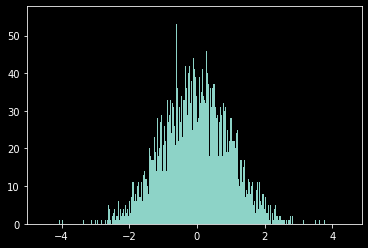

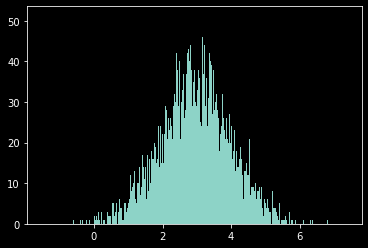

(array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 array([-3.41, -3.41, -3.41, -3.41, -3.41, -3.4, -3.4, -3.4, -3.4, -3.4, -3.4, -3.4, -3.4, -3.39, -3.39, -3.39, -3.39, -3.39, -3.39, -3.39, -3.39, -3.38, -3.38, -3.38, -3.38, -3.38, -3.38, -3.38, -3.38, -3.37, ..., 9.24, 9.24, 9.24, 9.24, 9.24, 9.24, 9.24, 9.25, 9.25, 9.25, 9.25, 9.25, 9.25, 9.25, 9.25, 9.26, 9.26, 9.26, 9.26, 9.26, 9.26, 9.26, 9.26, 9.27, 9.27, 9.27, 9.27, 9.27, 9.27, 9.27]),
 <a list of 10000 Patch objects>)

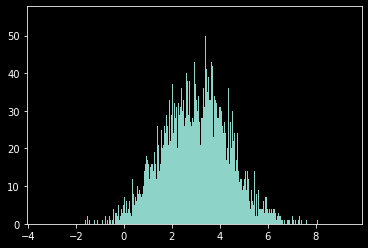

In [14]:
# model
# NUM_SESSIONS, NUM_ITEMS = len(sess_id_to_idx), len(item_id_to_idx)
# embedding_dim = 500

# session_embeddings = tf.Variable(tf.random_normal_initializer(dtype=tf.float64)([NUM_SESSIONS, embedding_dim]))
# item_embeddings = tf.Variable(tf.random_normal_initializer(dtype=tf.float64)([embedding_dim, NUM_ITEMS]))

# session_slice_idxs = tf.placeholder(dtype=tf.int64, shape=[None, 1]) # columns vectors to do tensor slicing
# item_slice_idxs = tf.placeholder(dtype=tf.int64, shape=[None, 1]) # columns vectors to do tensor slicing

# session_embedding_columns = tf.reshape(tf.gather_nd(session_embeddings, session_slice_idxs), [-1, embedding_dim])
# item_embedding_rows = tf.reshape(tf.gather_nd(item_embeddings, session_slice_idxs), [-1, embedding_dim])

# matrix_factorization_layer = session_embedding_columns * item_embedding_rows

# pred_y = tf.nn.sigmoid(matrix_factorization_layer)